In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


In [5]:
# In order to get fields (ra, dec) in bin for any timestamp:
# inputs are df, time
# Map ra, dec to az, el given time
# Map az, el to bin

# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [6]:
binning_method='healpix'
nside=8
bin_space='radec'
specific_years=[2014]
# specific_months=[12],
# specific_days=[15, 16, 17],
include_default_features=True
include_bin_features=False
do_z_score_norm=False
do_cyclical_norm=False

In [7]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    # specific_months=[12],
    # specific_days=[15, 16, 17],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

## Check that normalizations are working

In [8]:
for i, feat_name in enumerate(dataset.state_feature_names):
    print(feat_name, (dataset._df[feat_name].to_numpy() == dataset.next_states[:, i]).all())


ra tensor(True)
dec tensor(True)
az tensor(True)
el tensor(True)
airmass tensor(True)
ha tensor(True)
sun_ra tensor(True)
sun_dec tensor(True)
sun_az tensor(True)
sun_el tensor(True)
moon_ra tensor(True)
moon_dec tensor(True)
moon_az tensor(True)
moon_el tensor(True)
time_fraction_since_start tensor(True)
time_seconds_since_start tensor(True)


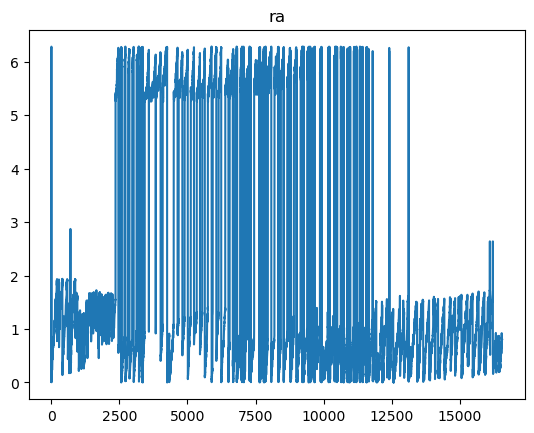

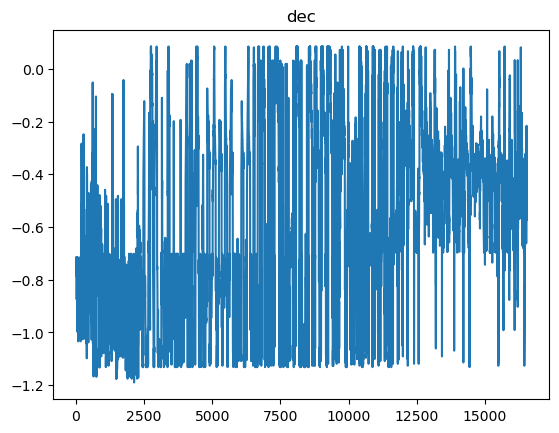

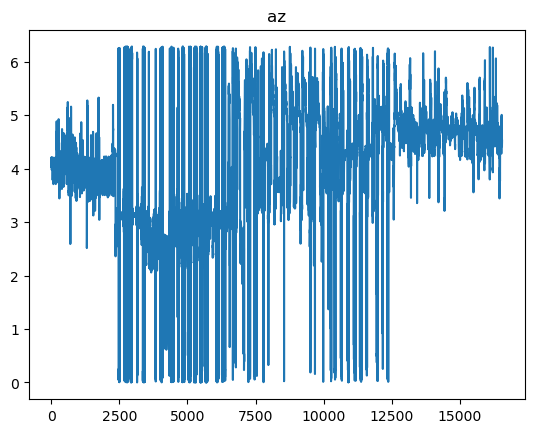

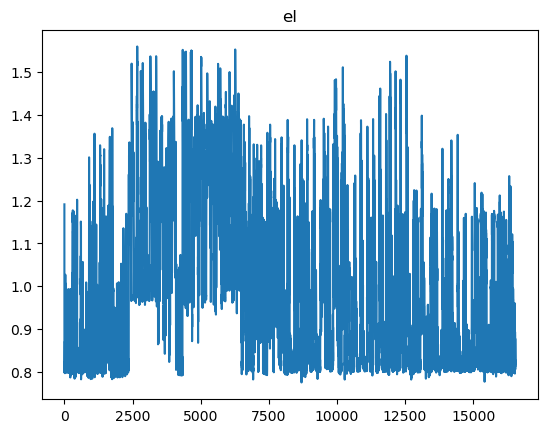

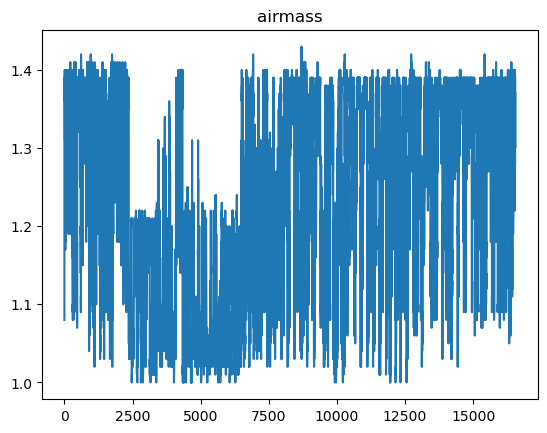

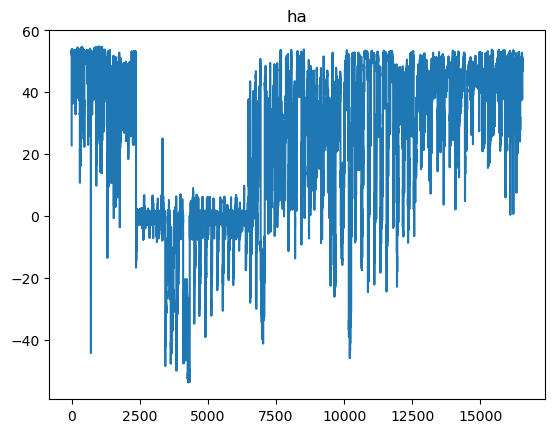

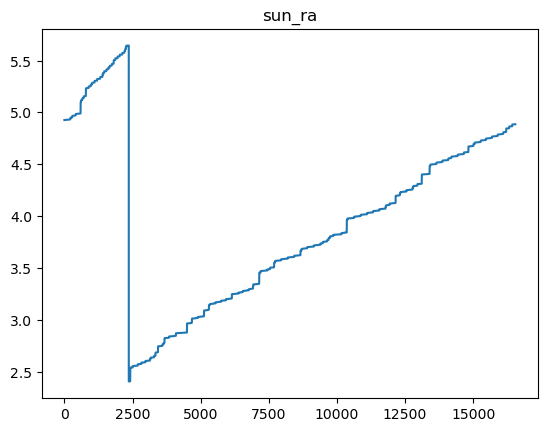

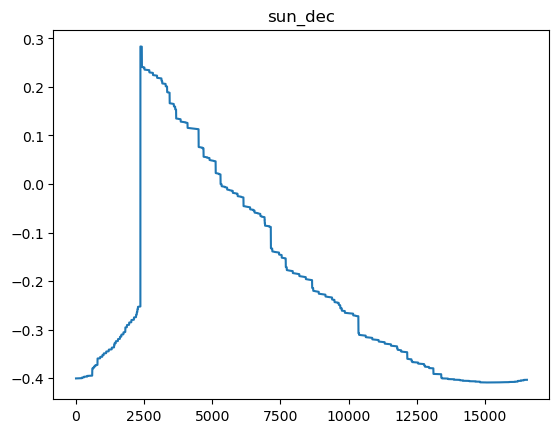

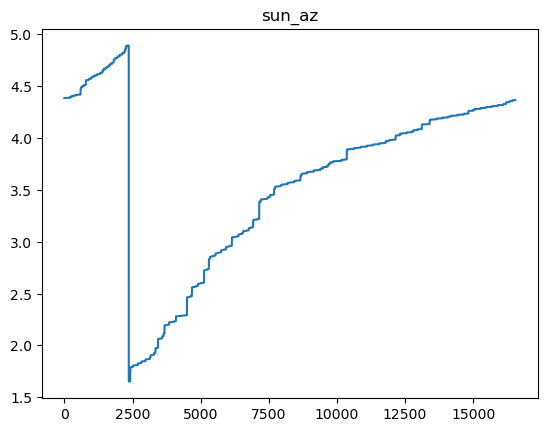

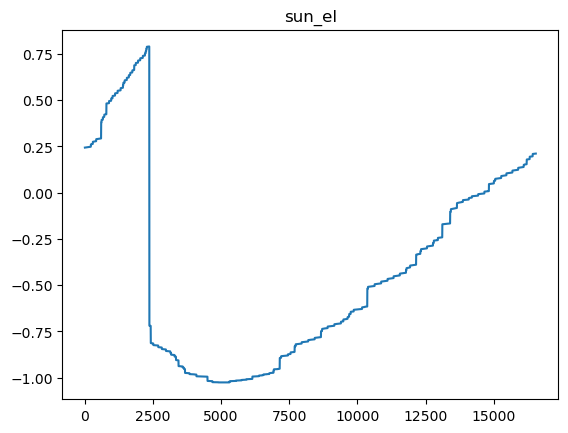

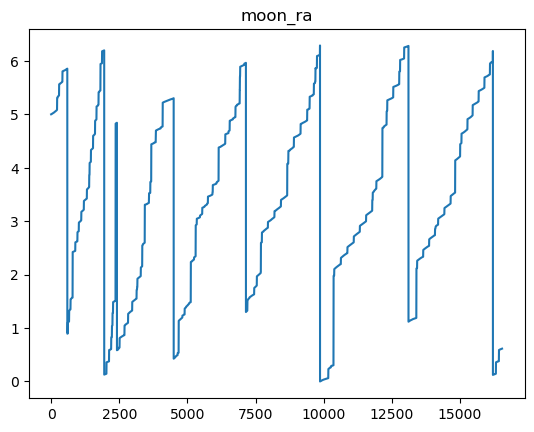

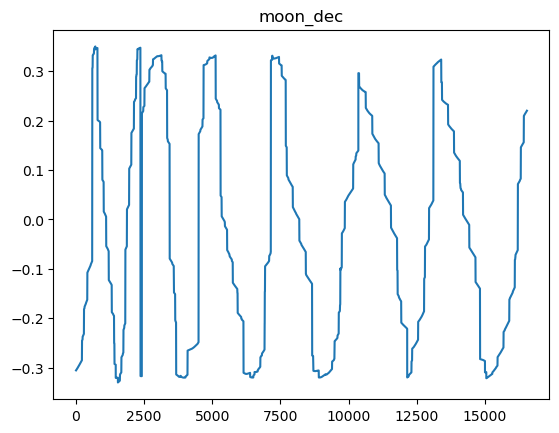

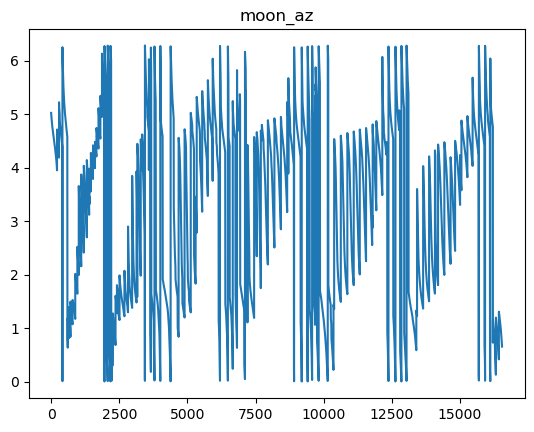

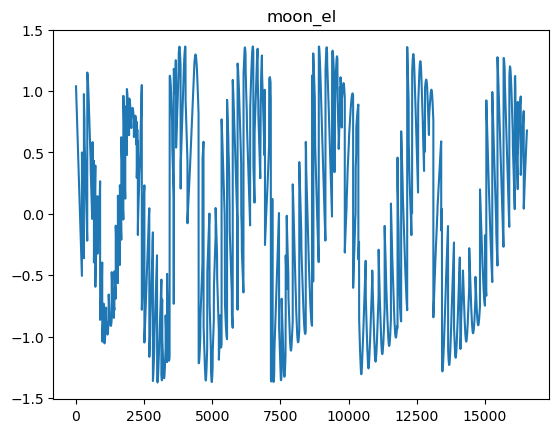

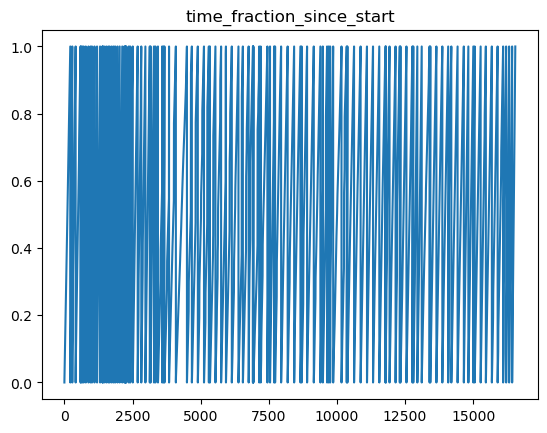

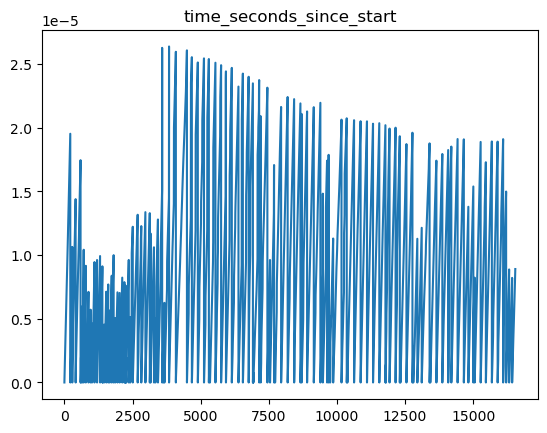

In [9]:
for i, feat_name in enumerate(dataset.state_feature_names):
    plt.plot(dataset._df[feat_name].to_numpy())
    plt.title(feat_name)
    plt.show();

In [17]:
dataset._df.groupby('night')['timestamp'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) )

12643    0.000000
12644    0.006747
12645    0.011503
12646    0.016001
12647    0.020388
           ...   
29185    0.969410
29186    0.975417
29187    0.984823
29188    0.994072
29189    1.000000
Name: timestamp, Length: 16547, dtype: float64

In [10]:
dataset._df['time_seconds_since_start']

12643    0.000000e+00
12644    1.317825e-07
12645    2.246783e-07
12646    3.125333e-07
12647    3.982280e-07
             ...     
29185    8.636618e-06
29186    8.690139e-06
29187    8.773942e-06
29188    8.856337e-06
29189    8.909153e-06
Name: time_seconds_since_start, Length: 16547, dtype: float32

In [11]:
# have ra, dec, object
# want such that we select bin, and then get field_ids
# want field/object name to ra, decs

# Visualize dataset in az, el and ra, dec

In [12]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

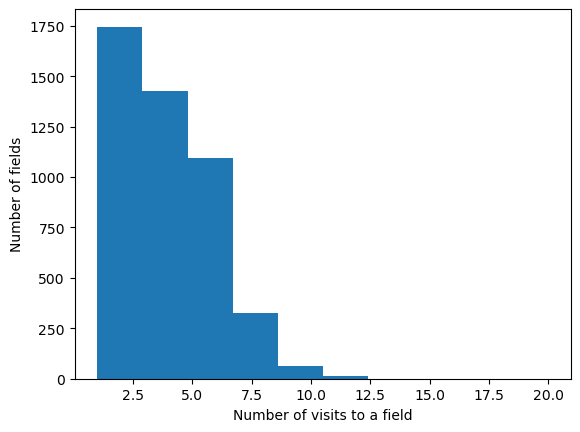

In [13]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

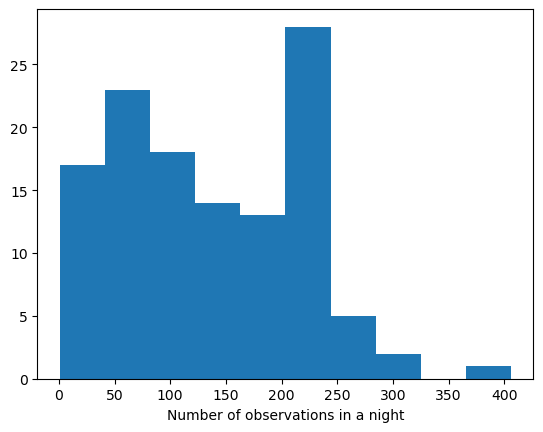

In [14]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

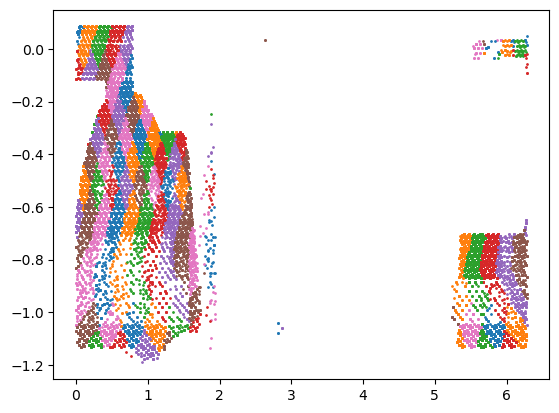

In [15]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [16]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [17]:
dataset.do_z_score_norm

False

In [18]:
dataset.do_cyclical_norm

False

In [24]:
"""Algorithm and Train setup"""
exp_name_prefix = 'Zscore_off_Cyclical_off_'

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 128,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 10,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [26]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [27]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                | 0/165470 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                     | 105/165470 [00:00<05:57, 462.32it/s]

Train step 0: Accuracy = 0.000, Loss = 999.7147, Q-val=0.000
Train step 100: Accuracy = 0.000, Loss = 6.3221, Q-val=0.000
Train step 200: Accuracy = 0.094, Loss = 5.9759, Q-val=0.000


  0%|                                     | 424/165470 [00:00<03:02, 903.21it/s]

Train step 300: Accuracy = 0.000, Loss = 5.7748, Q-val=0.000
Train step 400: Accuracy = 0.062, Loss = 11.7847, Q-val=0.000
Train step 500: Accuracy = 0.000, Loss = 5.4496, Q-val=0.000


  0%|▏                                   | 745/165470 [00:00<02:42, 1014.26it/s]

Train step 600: Accuracy = 0.031, Loss = 5.3103, Q-val=0.000
Train step 700: Accuracy = 0.031, Loss = 5.1909, Q-val=0.000
Train step 800: Accuracy = 0.031, Loss = 5.0704, Q-val=0.000


  1%|▏                                  | 1071/165470 [00:01<02:34, 1064.88it/s]

Train step 900: Accuracy = 0.062, Loss = 4.9600, Q-val=0.000
Train step 1000: Accuracy = 0.031, Loss = 4.8209, Q-val=0.000
Train step 1100: Accuracy = 0.031, Loss = 5.0496, Q-val=0.000


  1%|▎                                  | 1393/165470 [00:01<02:37, 1041.02it/s]

Train step 1200: Accuracy = 0.031, Loss = 4.7566, Q-val=0.000
Train step 1300: Accuracy = 0.031, Loss = 4.8831, Q-val=0.000
Train step 1400: Accuracy = 0.062, Loss = 4.8020, Q-val=0.000


  1%|▎                                  | 1606/165470 [00:01<02:37, 1040.26it/s]

Train step 1500: Accuracy = 0.031, Loss = 4.7357, Q-val=0.000
Train step 1600: Accuracy = 0.062, Loss = 4.6563, Q-val=0.000
Train step 1700: Accuracy = 0.031, Loss = 4.6594, Q-val=0.000


  1%|▍                                  | 1919/165470 [00:02<02:40, 1016.33it/s]

Train step 1800: Accuracy = 0.031, Loss = 4.6720, Q-val=0.000
Train step 1900: Accuracy = 0.000, Loss = 4.5438, Q-val=0.000
Train step 2000: Accuracy = 0.000, Loss = 4.6550, Q-val=0.000


  1%|▍                                  | 2228/165470 [00:02<02:39, 1021.89it/s]

Train step 2100: Accuracy = 0.062, Loss = 4.6563, Q-val=0.000
Train step 2200: Accuracy = 0.000, Loss = 4.9503, Q-val=0.000
Train step 2300: Accuracy = 0.062, Loss = 4.7177, Q-val=0.000


  2%|▌                                  | 2559/165470 [00:02<02:30, 1080.70it/s]

Train step 2400: Accuracy = 0.000, Loss = 4.6037, Q-val=0.000
Train step 2500: Accuracy = 0.031, Loss = 4.7444, Q-val=0.000
Train step 2600: Accuracy = 0.000, Loss = 4.6162, Q-val=0.000


  2%|▌                                  | 2898/165470 [00:02<02:29, 1085.61it/s]

Train step 2700: Accuracy = 0.000, Loss = 4.6842, Q-val=0.000
Train step 2800: Accuracy = 0.000, Loss = 4.6335, Q-val=0.000
Train step 2900: Accuracy = 0.000, Loss = 4.6139, Q-val=0.000


  2%|▋                                  | 3118/165470 [00:03<02:29, 1088.51it/s]

Train step 3000: Accuracy = 0.000, Loss = 4.5626, Q-val=0.000
Train step 3100: Accuracy = 0.000, Loss = 4.4238, Q-val=0.000
Train step 3200: Accuracy = 0.031, Loss = 4.7574, Q-val=0.000


  2%|▋                                  | 3458/165470 [00:03<02:25, 1117.07it/s]

Train step 3300: Accuracy = 0.000, Loss = 4.2635, Q-val=0.000
Train step 3400: Accuracy = 0.062, Loss = 4.4614, Q-val=0.000
Train step 3500: Accuracy = 0.000, Loss = 4.8611, Q-val=0.000


  2%|▊                                  | 3797/165470 [00:03<02:25, 1114.63it/s]

Train step 3600: Accuracy = 0.000, Loss = 4.7176, Q-val=0.000
Train step 3700: Accuracy = 0.000, Loss = 4.6324, Q-val=0.000
Train step 3800: Accuracy = 0.031, Loss = 4.7799, Q-val=0.000


  2%|▊                                  | 4020/165470 [00:03<02:28, 1088.44it/s]

Train step 3900: Accuracy = 0.031, Loss = 4.5912, Q-val=0.000
Train step 4000: Accuracy = 0.031, Loss = 4.6115, Q-val=0.000
Train step 4100: Accuracy = 0.031, Loss = 4.5739, Q-val=0.000


  3%|▉                                  | 4357/165470 [00:04<02:25, 1107.30it/s]

Train step 4200: Accuracy = 0.000, Loss = 4.3017, Q-val=0.000
Train step 4300: Accuracy = 0.094, Loss = 4.6014, Q-val=0.000
Train step 4400: Accuracy = 0.031, Loss = 4.6806, Q-val=0.000


  3%|▉                                  | 4688/165470 [00:04<02:27, 1093.25it/s]

Train step 4500: Accuracy = 0.000, Loss = 4.3602, Q-val=0.000
Train step 4600: Accuracy = 0.031, Loss = 4.5393, Q-val=0.000
Train step 4700: Accuracy = 0.031, Loss = 4.5968, Q-val=0.000


  3%|█                                  | 5018/165470 [00:04<02:27, 1088.85it/s]

Train step 4800: Accuracy = 0.031, Loss = 4.6677, Q-val=0.000
Train step 4900: Accuracy = 0.000, Loss = 4.6236, Q-val=0.000
Train step 5000: Accuracy = 0.031, Loss = 4.7830, Q-val=0.000


  3%|█                                  | 5235/165470 [00:05<02:30, 1061.93it/s]

Train step 5100: Accuracy = 0.094, Loss = 4.5544, Q-val=0.000
Train step 5200: Accuracy = 0.000, Loss = 4.6692, Q-val=0.000
Train step 5300: Accuracy = 0.062, Loss = 4.4992, Q-val=0.000


  3%|█▏                                 | 5557/165470 [00:05<02:32, 1048.95it/s]

Train step 5400: Accuracy = 0.031, Loss = 4.6376, Q-val=0.000
Train step 5500: Accuracy = 0.094, Loss = 4.6453, Q-val=0.000
Train step 5600: Accuracy = 0.031, Loss = 4.5558, Q-val=0.000


  4%|█▏                                 | 5893/165470 [00:05<02:26, 1088.04it/s]

Train step 5700: Accuracy = 0.031, Loss = 4.5485, Q-val=0.000
Train step 5800: Accuracy = 0.094, Loss = 4.5432, Q-val=0.000
Train step 5900: Accuracy = 0.031, Loss = 4.5155, Q-val=0.000


  4%|█▎                                 | 6117/165470 [00:05<02:24, 1101.89it/s]

Train step 6000: Accuracy = 0.000, Loss = 4.5842, Q-val=0.000
Train step 6100: Accuracy = 0.000, Loss = 4.4884, Q-val=0.000
Train step 6200: Accuracy = 0.062, Loss = 4.6092, Q-val=0.000


  4%|█▎                                 | 6455/165470 [00:06<02:22, 1115.27it/s]

Train step 6300: Accuracy = 0.000, Loss = 4.5077, Q-val=0.000
Train step 6400: Accuracy = 0.094, Loss = 4.3681, Q-val=0.000
Train step 6500: Accuracy = 0.031, Loss = 4.5253, Q-val=0.000


  4%|█▍                                 | 6795/165470 [00:06<02:21, 1125.06it/s]

Train step 6600: Accuracy = 0.062, Loss = 4.5063, Q-val=0.000
Train step 6700: Accuracy = 0.000, Loss = 4.7572, Q-val=0.000
Train step 6800: Accuracy = 0.000, Loss = 4.5776, Q-val=0.000


  4%|█▍                                 | 7024/165470 [00:06<02:20, 1127.66it/s]

Train step 6900: Accuracy = 0.062, Loss = 4.6470, Q-val=0.000
Train step 7000: Accuracy = 0.000, Loss = 4.5968, Q-val=0.000
Train step 7100: Accuracy = 0.031, Loss = 4.9061, Q-val=0.000


  4%|█▌                                 | 7362/165470 [00:06<02:21, 1113.76it/s]

Train step 7200: Accuracy = 0.031, Loss = 4.5540, Q-val=0.000
Train step 7300: Accuracy = 0.031, Loss = 4.5185, Q-val=0.000
Train step 7400: Accuracy = 0.000, Loss = 4.8019, Q-val=0.000


  5%|█▋                                 | 7701/165470 [00:07<02:21, 1118.51it/s]

Train step 7500: Accuracy = 0.031, Loss = 4.4700, Q-val=0.000
Train step 7600: Accuracy = 0.062, Loss = 4.6537, Q-val=0.000
Train step 7700: Accuracy = 0.031, Loss = 4.6025, Q-val=0.000


  5%|█▋                                 | 7925/165470 [00:07<02:23, 1101.66it/s]

Train step 7800: Accuracy = 0.000, Loss = 4.5908, Q-val=0.000
Train step 7900: Accuracy = 0.000, Loss = 4.4091, Q-val=0.000
Train step 8000: Accuracy = 0.062, Loss = 4.6848, Q-val=0.000


  5%|█▋                                 | 8271/165470 [00:07<02:19, 1129.33it/s]

Train step 8100: Accuracy = 0.000, Loss = 4.5659, Q-val=0.000
Train step 8200: Accuracy = 0.000, Loss = 4.5125, Q-val=0.000
Train step 8300: Accuracy = 0.062, Loss = 4.4430, Q-val=0.000


  5%|█▊                                 | 8615/165470 [00:08<02:18, 1134.48it/s]

Train step 8400: Accuracy = 0.031, Loss = 4.6182, Q-val=0.000
Train step 8500: Accuracy = 0.031, Loss = 4.7182, Q-val=0.000
Train step 8600: Accuracy = 0.031, Loss = 4.5239, Q-val=0.000


  5%|█▊                                 | 8842/165470 [00:08<02:20, 1114.06it/s]

Train step 8700: Accuracy = 0.000, Loss = 4.3016, Q-val=0.000
Train step 8800: Accuracy = 0.000, Loss = 4.7214, Q-val=0.000
Train step 8900: Accuracy = 0.062, Loss = 4.5208, Q-val=0.000


  6%|█▉                                 | 9187/165470 [00:08<02:19, 1117.31it/s]

Train step 9000: Accuracy = 0.000, Loss = 4.5186, Q-val=0.000
Train step 9100: Accuracy = 0.000, Loss = 4.4887, Q-val=0.000
Train step 9200: Accuracy = 0.000, Loss = 4.4314, Q-val=0.000


  6%|█▉                                 | 9413/165470 [00:08<02:21, 1103.04it/s]

Train step 9300: Accuracy = 0.000, Loss = 4.6502, Q-val=0.000
Train step 9400: Accuracy = 0.031, Loss = 4.6534, Q-val=0.000
Train step 9500: Accuracy = 0.031, Loss = 4.5437, Q-val=0.000


  6%|██                                 | 9747/165470 [00:09<02:22, 1093.04it/s]

Train step 9600: Accuracy = 0.000, Loss = 4.5747, Q-val=0.000
Train step 9700: Accuracy = 0.031, Loss = 4.5855, Q-val=0.000
Train step 9800: Accuracy = 0.031, Loss = 4.7807, Q-val=0.000


  6%|██                                | 10082/165470 [00:09<02:21, 1101.54it/s]

Train step 9900: Accuracy = 0.000, Loss = 4.4587, Q-val=0.000
Train step 10000: Accuracy = 0.031, Loss = 4.5088, Q-val=0.000
Train step 10100: Accuracy = 0.094, Loss = 4.5952, Q-val=0.000


  6%|██▏                               | 10418/165470 [00:09<02:19, 1111.54it/s]

Train step 10200: Accuracy = 0.031, Loss = 4.5117, Q-val=0.000
Train step 10300: Accuracy = 0.031, Loss = 4.5043, Q-val=0.000
Train step 10400: Accuracy = 0.031, Loss = 4.5103, Q-val=0.000


  6%|██▏                               | 10641/165470 [00:09<02:20, 1101.13it/s]

Train step 10500: Accuracy = 0.031, Loss = 4.6385, Q-val=0.000
Train step 10600: Accuracy = 0.031, Loss = 4.5299, Q-val=0.000
Train step 10700: Accuracy = 0.031, Loss = 4.7606, Q-val=0.000


  7%|██▎                               | 10983/165470 [00:10<02:17, 1123.66it/s]

Train step 10800: Accuracy = 0.062, Loss = 4.4435, Q-val=0.000
Train step 10900: Accuracy = 0.000, Loss = 4.4757, Q-val=0.000
Train step 11000: Accuracy = 0.000, Loss = 4.6087, Q-val=0.000


  7%|██▎                               | 11213/165470 [00:10<02:17, 1118.59it/s]

Train step 11100: Accuracy = 0.000, Loss = 4.5422, Q-val=0.000
Train step 11200: Accuracy = 0.031, Loss = 4.4665, Q-val=0.000
Train step 11300: Accuracy = 0.031, Loss = 4.6367, Q-val=0.000


  7%|██▎                               | 11548/165470 [00:10<02:18, 1108.67it/s]

Train step 11400: Accuracy = 0.062, Loss = 4.4867, Q-val=0.000
Train step 11500: Accuracy = 0.031, Loss = 4.5059, Q-val=0.000
Train step 11600: Accuracy = 0.031, Loss = 4.5112, Q-val=0.000


  7%|██▍                               | 11898/165470 [00:11<02:14, 1140.13it/s]

Train step 11700: Accuracy = 0.062, Loss = 4.2965, Q-val=0.000
Train step 11800: Accuracy = 0.062, Loss = 4.6172, Q-val=0.000
Train step 11900: Accuracy = 0.062, Loss = 4.5087, Q-val=0.000


  7%|██▍                               | 12129/165470 [00:11<02:13, 1146.08it/s]

Train step 12000: Accuracy = 0.031, Loss = 4.4254, Q-val=0.000
Train step 12100: Accuracy = 0.062, Loss = 4.6390, Q-val=0.000
Train step 12200: Accuracy = 0.000, Loss = 4.6977, Q-val=0.000


  8%|██▌                               | 12479/165470 [00:11<02:15, 1131.07it/s]

Train step 12300: Accuracy = 0.031, Loss = 4.4631, Q-val=0.000
Train step 12400: Accuracy = 0.031, Loss = 4.6762, Q-val=0.000
Train step 12500: Accuracy = 0.062, Loss = 4.5217, Q-val=0.000


  8%|██▋                               | 12819/165470 [00:11<02:16, 1117.35it/s]

Train step 12600: Accuracy = 0.062, Loss = 4.4828, Q-val=0.000
Train step 12700: Accuracy = 0.031, Loss = 4.5805, Q-val=0.000
Train step 12800: Accuracy = 0.094, Loss = 4.7312, Q-val=0.000


  8%|██▋                               | 13043/165470 [00:12<02:16, 1115.25it/s]

Train step 12900: Accuracy = 0.031, Loss = 4.5473, Q-val=0.000
Train step 13000: Accuracy = 0.000, Loss = 4.4845, Q-val=0.000
Train step 13100: Accuracy = 0.062, Loss = 4.5868, Q-val=0.000


  8%|██▋                               | 13383/165470 [00:12<02:15, 1124.56it/s]

Train step 13200: Accuracy = 0.031, Loss = 4.6457, Q-val=0.000
Train step 13300: Accuracy = 0.000, Loss = 4.5520, Q-val=0.000
Train step 13400: Accuracy = 0.031, Loss = 4.2884, Q-val=0.000


  8%|██▊                               | 13613/165470 [00:12<02:14, 1130.79it/s]

Train step 13500: Accuracy = 0.031, Loss = 4.5364, Q-val=0.000
Train step 13600: Accuracy = 0.000, Loss = 4.8162, Q-val=0.000
Train step 13700: Accuracy = 0.000, Loss = 4.5633, Q-val=0.000


  8%|██▊                               | 13958/165470 [00:12<02:14, 1129.98it/s]

Train step 13800: Accuracy = 0.031, Loss = 4.7294, Q-val=0.000
Train step 13900: Accuracy = 0.000, Loss = 4.7511, Q-val=0.000
Train step 14000: Accuracy = 0.000, Loss = 4.6548, Q-val=0.000


  9%|██▉                               | 14311/165470 [00:13<02:10, 1155.00it/s]

Train step 14100: Accuracy = 0.062, Loss = 4.4838, Q-val=0.000
Train step 14200: Accuracy = 0.156, Loss = 4.7020, Q-val=0.000
Train step 14300: Accuracy = 0.031, Loss = 4.6970, Q-val=0.000


  9%|██▉                               | 14542/165470 [00:13<02:13, 1131.34it/s]

Train step 14400: Accuracy = 0.000, Loss = 4.0648, Q-val=0.000
Train step 14500: Accuracy = 0.031, Loss = 4.4575, Q-val=0.000
Train step 14600: Accuracy = 0.000, Loss = 4.5370, Q-val=0.000


  9%|███                               | 14887/165470 [00:13<02:12, 1136.19it/s]

Train step 14700: Accuracy = 0.031, Loss = 4.5853, Q-val=0.000
Train step 14800: Accuracy = 0.031, Loss = 4.6328, Q-val=0.000
Train step 14900: Accuracy = 0.000, Loss = 4.5330, Q-val=0.000


  9%|███                               | 15115/165470 [00:13<02:12, 1130.70it/s]

Train step 15000: Accuracy = 0.031, Loss = 4.4204, Q-val=0.000
Train step 15100: Accuracy = 0.031, Loss = 4.7276, Q-val=0.000
Train step 15200: Accuracy = 0.094, Loss = 4.5803, Q-val=0.000


  9%|███▏                              | 15454/165470 [00:14<02:15, 1105.19it/s]

Train step 15300: Accuracy = 0.000, Loss = 4.7873, Q-val=0.000
Train step 15400: Accuracy = 0.062, Loss = 4.4588, Q-val=0.000
Train step 15500: Accuracy = 0.000, Loss = 4.5019, Q-val=0.000


 10%|███▏                              | 15793/165470 [00:14<02:13, 1117.10it/s]

Train step 15600: Accuracy = 0.062, Loss = 4.5402, Q-val=0.000
Train step 15700: Accuracy = 0.031, Loss = 4.5636, Q-val=0.000
Train step 15800: Accuracy = 0.000, Loss = 4.7142, Q-val=0.000


 10%|███▎                              | 16017/165470 [00:14<02:14, 1113.21it/s]

Train step 15900: Accuracy = 0.000, Loss = 4.5923, Q-val=0.000
Train step 16000: Accuracy = 0.031, Loss = 4.6806, Q-val=0.000
Train step 16100: Accuracy = 0.094, Loss = 4.6892, Q-val=0.000


 10%|███▎                              | 16357/165470 [00:15<02:15, 1098.48it/s]

Train step 16200: Accuracy = 0.000, Loss = 4.6582, Q-val=0.000
Train step 16300: Accuracy = 0.094, Loss = 4.5756, Q-val=0.000
Train step 16400: Accuracy = 0.000, Loss = 4.7966, Q-val=0.000


 10%|███▍                              | 16703/165470 [00:15<02:11, 1131.54it/s]

Train step 16500: Accuracy = 0.094, Loss = 4.6106, Q-val=0.000
Train step 16600: Accuracy = 0.000, Loss = 4.5499, Q-val=0.000
Train step 16700: Accuracy = 0.000, Loss = 4.4153, Q-val=0.000


 10%|███▍                              | 16937/165470 [00:15<02:09, 1149.05it/s]

Train step 16800: Accuracy = 0.000, Loss = 4.5099, Q-val=0.000
Train step 16900: Accuracy = 0.094, Loss = 4.5604, Q-val=0.000
Train step 17000: Accuracy = 0.000, Loss = 4.6229, Q-val=0.000


 10%|███▌                              | 17283/165470 [00:15<02:10, 1133.26it/s]

Train step 17100: Accuracy = 0.000, Loss = 4.3769, Q-val=0.000
Train step 17200: Accuracy = 0.000, Loss = 4.6535, Q-val=0.000
Train step 17300: Accuracy = 0.031, Loss = 4.7361, Q-val=0.000


 11%|███▌                              | 17626/165470 [00:16<02:10, 1135.15it/s]

Train step 17400: Accuracy = 0.031, Loss = 4.5955, Q-val=0.000
Train step 17500: Accuracy = 0.031, Loss = 4.3648, Q-val=0.000
Train step 17600: Accuracy = 0.031, Loss = 4.5641, Q-val=0.000


 11%|███▋                              | 17860/165470 [00:16<02:08, 1151.61it/s]

Train step 17700: Accuracy = 0.000, Loss = 4.5689, Q-val=0.000
Train step 17800: Accuracy = 0.031, Loss = 4.6722, Q-val=0.000
Train step 17900: Accuracy = 0.000, Loss = 4.4735, Q-val=0.000


 11%|███▋                              | 18209/165470 [00:16<02:07, 1155.50it/s]

Train step 18000: Accuracy = 0.031, Loss = 4.7307, Q-val=0.000
Train step 18100: Accuracy = 0.062, Loss = 4.4537, Q-val=0.000
Train step 18200: Accuracy = 0.000, Loss = 4.6662, Q-val=0.000


 11%|███▊                              | 18442/165470 [00:16<02:07, 1153.29it/s]

Train step 18300: Accuracy = 0.031, Loss = 4.7714, Q-val=0.000
Train step 18400: Accuracy = 0.031, Loss = 4.5186, Q-val=0.000
Train step 18500: Accuracy = 0.031, Loss = 4.4905, Q-val=0.000


 11%|███▊                              | 18790/165470 [00:17<02:08, 1144.59it/s]

Train step 18600: Accuracy = 0.000, Loss = 4.6206, Q-val=0.000
Train step 18700: Accuracy = 0.062, Loss = 4.6045, Q-val=0.000
Train step 18800: Accuracy = 0.031, Loss = 4.4677, Q-val=0.000


 11%|███▉                              | 19026/165470 [00:17<02:06, 1159.66it/s]

Train step 18900: Accuracy = 0.000, Loss = 4.5595, Q-val=0.000
Train step 19000: Accuracy = 0.000, Loss = 4.3510, Q-val=0.000
Train step 19100: Accuracy = 0.062, Loss = 4.6138, Q-val=0.000


 12%|███▉                              | 19376/165470 [00:17<02:06, 1150.55it/s]

Train step 19200: Accuracy = 0.031, Loss = 4.6395, Q-val=0.000
Train step 19300: Accuracy = 0.000, Loss = 4.7189, Q-val=0.000
Train step 19400: Accuracy = 0.031, Loss = 4.7588, Q-val=0.000


 12%|████                              | 19723/165470 [00:17<02:08, 1131.99it/s]

Train step 19500: Accuracy = 0.062, Loss = 4.6129, Q-val=0.000
Train step 19600: Accuracy = 0.000, Loss = 4.5745, Q-val=0.000
Train step 19700: Accuracy = 0.062, Loss = 4.5329, Q-val=0.000


 12%|████                              | 19952/165470 [00:18<02:09, 1125.85it/s]

Train step 19800: Accuracy = 0.000, Loss = 4.8147, Q-val=0.000
Train step 19900: Accuracy = 0.094, Loss = 4.5422, Q-val=0.000
Train step 20000: Accuracy = 0.031, Loss = 4.7947, Q-val=0.000


 12%|████▏                             | 20291/165470 [00:18<02:09, 1119.08it/s]

Train step 20100: Accuracy = 0.000, Loss = 4.5312, Q-val=0.000
Train step 20200: Accuracy = 0.062, Loss = 4.6059, Q-val=0.000
Train step 20300: Accuracy = 0.062, Loss = 4.6550, Q-val=0.000


 12%|████▏                             | 20519/165470 [00:18<02:08, 1123.70it/s]

Train step 20400: Accuracy = 0.000, Loss = 4.5468, Q-val=0.000
Train step 20500: Accuracy = 0.031, Loss = 4.7273, Q-val=0.000
Train step 20600: Accuracy = 0.031, Loss = 4.4618, Q-val=0.000


 13%|████▎                             | 20864/165470 [00:18<02:06, 1140.56it/s]

Train step 20700: Accuracy = 0.000, Loss = 4.8697, Q-val=0.000
Train step 20800: Accuracy = 0.031, Loss = 4.6013, Q-val=0.000
Train step 20900: Accuracy = 0.031, Loss = 4.4826, Q-val=0.000


 13%|████▎                             | 21209/165470 [00:19<02:08, 1123.71it/s]

Train step 21000: Accuracy = 0.031, Loss = 4.5152, Q-val=0.000
Train step 21100: Accuracy = 0.031, Loss = 4.4731, Q-val=0.000
Train step 21200: Accuracy = 0.000, Loss = 4.7071, Q-val=0.000


 13%|████▍                             | 21441/165470 [00:19<02:06, 1141.40it/s]

Train step 21300: Accuracy = 0.000, Loss = 4.5115, Q-val=0.000
Train step 21400: Accuracy = 0.031, Loss = 4.5074, Q-val=0.000
Train step 21500: Accuracy = 0.062, Loss = 4.4462, Q-val=0.000


 13%|████▍                             | 21786/165470 [00:19<02:07, 1130.01it/s]

Train step 21600: Accuracy = 0.000, Loss = 4.5032, Q-val=0.000
Train step 21700: Accuracy = 0.031, Loss = 4.5870, Q-val=0.000
Train step 21800: Accuracy = 0.000, Loss = 4.6535, Q-val=0.000


 13%|████▌                             | 22018/165470 [00:19<02:05, 1142.91it/s]

Train step 21900: Accuracy = 0.031, Loss = 4.5497, Q-val=0.000
Train step 22000: Accuracy = 0.062, Loss = 4.7491, Q-val=0.000
Train step 22100: Accuracy = 0.000, Loss = 4.7337, Q-val=0.000


 14%|████▌                             | 22363/165470 [00:20<02:05, 1142.49it/s]

Train step 22200: Accuracy = 0.062, Loss = 4.4381, Q-val=0.000
Train step 22300: Accuracy = 0.031, Loss = 4.5028, Q-val=0.000
Train step 22400: Accuracy = 0.031, Loss = 4.4434, Q-val=0.000


 14%|████▋                             | 22707/165470 [00:20<02:05, 1134.50it/s]

Train step 22500: Accuracy = 0.000, Loss = 4.5327, Q-val=0.000
Train step 22600: Accuracy = 0.031, Loss = 4.4784, Q-val=0.000
Train step 22700: Accuracy = 0.031, Loss = 4.5042, Q-val=0.000


 14%|████▋                             | 22934/165470 [00:20<02:08, 1109.16it/s]

Train step 22800: Accuracy = 0.000, Loss = 4.6326, Q-val=0.000
Train step 22900: Accuracy = 0.062, Loss = 4.6038, Q-val=0.000
Train step 23000: Accuracy = 0.031, Loss = 4.6683, Q-val=0.000


 14%|████▊                             | 23272/165470 [00:21<02:06, 1121.33it/s]

Train step 23100: Accuracy = 0.000, Loss = 4.4245, Q-val=0.000
Train step 23200: Accuracy = 0.125, Loss = 4.6964, Q-val=0.000
Train step 23300: Accuracy = 0.031, Loss = 4.5518, Q-val=0.000


 14%|████▊                             | 23612/165470 [00:21<02:07, 1109.57it/s]

Train step 23400: Accuracy = 0.062, Loss = 4.6214, Q-val=0.000
Train step 23500: Accuracy = 0.000, Loss = 4.4961, Q-val=0.000
Train step 23600: Accuracy = 0.062, Loss = 4.5851, Q-val=0.000


 14%|████▉                             | 23839/165470 [00:21<02:06, 1120.13it/s]

Train step 23700: Accuracy = 0.000, Loss = 4.7474, Q-val=0.000
Train step 23800: Accuracy = 0.031, Loss = 4.6912, Q-val=0.000
Train step 23900: Accuracy = 0.000, Loss = 4.8179, Q-val=0.000


 15%|████▉                             | 24187/165470 [00:21<02:03, 1141.24it/s]

Train step 24000: Accuracy = 0.000, Loss = 4.4992, Q-val=0.000
Train step 24100: Accuracy = 0.031, Loss = 4.4730, Q-val=0.000
Train step 24200: Accuracy = 0.031, Loss = 4.2133, Q-val=0.000


 15%|█████                             | 24417/165470 [00:22<02:03, 1137.91it/s]

Train step 24300: Accuracy = 0.031, Loss = 4.8171, Q-val=0.000
Train step 24400: Accuracy = 0.031, Loss = 4.4076, Q-val=0.000
Train step 24500: Accuracy = 0.031, Loss = 4.6306, Q-val=0.000


 15%|█████                             | 24764/165470 [00:22<02:03, 1139.80it/s]

Train step 24600: Accuracy = 0.031, Loss = 4.5590, Q-val=0.000
Train step 24700: Accuracy = 0.000, Loss = 4.5489, Q-val=0.000
Train step 24800: Accuracy = 0.031, Loss = 4.7516, Q-val=0.000


 15%|█████▏                            | 25106/165470 [00:22<02:04, 1124.75it/s]

Train step 24900: Accuracy = 0.000, Loss = 4.5455, Q-val=0.000
Train step 25000: Accuracy = 0.000, Loss = 4.7306, Q-val=0.000
Train step 25100: Accuracy = 0.031, Loss = 4.5638, Q-val=0.000


 15%|█████▏                            | 25332/165470 [00:22<02:05, 1120.35it/s]

Train step 25200: Accuracy = 0.031, Loss = 4.5661, Q-val=0.000
Train step 25300: Accuracy = 0.031, Loss = 4.5335, Q-val=0.000
Train step 25400: Accuracy = 0.031, Loss = 4.7599, Q-val=0.000


 16%|█████▎                            | 25676/165470 [00:23<02:02, 1136.70it/s]

Train step 25500: Accuracy = 0.031, Loss = 4.7587, Q-val=0.000
Train step 25600: Accuracy = 0.031, Loss = 4.5750, Q-val=0.000
Train step 25700: Accuracy = 0.062, Loss = 4.6339, Q-val=0.000


 16%|█████▎                            | 26018/165470 [00:23<02:03, 1132.34it/s]

Train step 25800: Accuracy = 0.062, Loss = 4.5458, Q-val=0.000
Train step 25900: Accuracy = 0.062, Loss = 4.4605, Q-val=0.000
Train step 26000: Accuracy = 0.000, Loss = 4.8018, Q-val=0.000


 16%|█████▍                            | 26250/165470 [00:23<02:02, 1136.13it/s]

Train step 26100: Accuracy = 0.000, Loss = 4.8768, Q-val=0.000
Train step 26200: Accuracy = 0.062, Loss = 4.5414, Q-val=0.000
Train step 26300: Accuracy = 0.062, Loss = 4.6382, Q-val=0.000


 16%|█████▍                            | 26602/165470 [00:24<02:00, 1155.01it/s]

Train step 26400: Accuracy = 0.000, Loss = 4.3067, Q-val=0.000
Train step 26500: Accuracy = 0.000, Loss = 4.8539, Q-val=0.000
Train step 26600: Accuracy = 0.000, Loss = 4.5456, Q-val=0.000


 16%|█████▌                            | 26834/165470 [00:24<02:00, 1148.88it/s]

Train step 26700: Accuracy = 0.031, Loss = 4.6168, Q-val=0.000
Train step 26800: Accuracy = 0.031, Loss = 4.5743, Q-val=0.000
Train step 26900: Accuracy = 0.000, Loss = 4.8015, Q-val=0.000


 16%|█████▌                            | 27178/165470 [00:24<02:03, 1123.55it/s]

Train step 27000: Accuracy = 0.000, Loss = 4.6991, Q-val=0.000
Train step 27100: Accuracy = 0.000, Loss = 4.5456, Q-val=0.000
Train step 27200: Accuracy = 0.000, Loss = 4.6010, Q-val=0.000


 17%|█████▋                            | 27519/165470 [00:24<02:03, 1120.24it/s]

Train step 27300: Accuracy = 0.000, Loss = 4.4279, Q-val=0.000
Train step 27400: Accuracy = 0.031, Loss = 4.7305, Q-val=0.000
Train step 27500: Accuracy = 0.031, Loss = 4.4796, Q-val=0.000


 17%|█████▋                            | 27749/165470 [00:25<02:01, 1129.62it/s]

Train step 27600: Accuracy = 0.031, Loss = 4.7102, Q-val=0.000
Train step 27700: Accuracy = 0.031, Loss = 4.7082, Q-val=0.000
Train step 27800: Accuracy = 0.000, Loss = 4.7563, Q-val=0.000


 17%|█████▊                            | 28099/165470 [00:25<02:00, 1139.04it/s]

Train step 27900: Accuracy = 0.000, Loss = 4.6430, Q-val=0.000
Train step 28000: Accuracy = 0.000, Loss = 4.5305, Q-val=0.000
Train step 28100: Accuracy = 0.031, Loss = 4.5374, Q-val=0.000


 17%|█████▊                            | 28330/165470 [00:25<02:00, 1139.94it/s]

Train step 28200: Accuracy = 0.000, Loss = 4.6496, Q-val=0.000
Train step 28300: Accuracy = 0.031, Loss = 4.5079, Q-val=0.000
Train step 28400: Accuracy = 0.000, Loss = 4.6060, Q-val=0.000


 17%|█████▉                            | 28672/165470 [00:25<02:01, 1123.59it/s]

Train step 28500: Accuracy = 0.062, Loss = 4.7677, Q-val=0.000
Train step 28600: Accuracy = 0.031, Loss = 4.4358, Q-val=0.000
Train step 28700: Accuracy = 0.031, Loss = 4.4331, Q-val=0.000


 18%|█████▉                            | 29016/165470 [00:26<02:00, 1132.94it/s]

Train step 28800: Accuracy = 0.000, Loss = 4.2937, Q-val=0.000
Train step 28900: Accuracy = 0.031, Loss = 4.3733, Q-val=0.000
Train step 29000: Accuracy = 0.094, Loss = 4.6565, Q-val=0.000


 18%|██████                            | 29248/165470 [00:26<01:59, 1135.25it/s]

Train step 29100: Accuracy = 0.031, Loss = 4.5363, Q-val=0.000
Train step 29200: Accuracy = 0.031, Loss = 4.5541, Q-val=0.000
Train step 29300: Accuracy = 0.062, Loss = 4.5226, Q-val=0.000


 18%|██████                            | 29594/165470 [00:26<01:58, 1142.19it/s]

Train step 29400: Accuracy = 0.000, Loss = 4.8080, Q-val=0.000
Train step 29500: Accuracy = 0.031, Loss = 4.7153, Q-val=0.000
Train step 29600: Accuracy = 0.031, Loss = 4.5504, Q-val=0.000


 18%|██████▏                           | 29829/165470 [00:26<01:57, 1155.68it/s]

Train step 29700: Accuracy = 0.000, Loss = 4.5402, Q-val=0.000
Train step 29800: Accuracy = 0.000, Loss = 4.4180, Q-val=0.000
Train step 29900: Accuracy = 0.031, Loss = 4.5725, Q-val=0.000


 18%|██████▏                           | 30176/165470 [00:27<01:58, 1143.76it/s]

Train step 30000: Accuracy = 0.062, Loss = 4.5558, Q-val=0.000
Train step 30100: Accuracy = 0.031, Loss = 4.7228, Q-val=0.000
Train step 30200: Accuracy = 0.094, Loss = 4.7526, Q-val=0.000


 18%|██████▎                           | 30521/165470 [00:27<01:59, 1130.70it/s]

Train step 30300: Accuracy = 0.000, Loss = 4.5647, Q-val=0.000
Train step 30400: Accuracy = 0.031, Loss = 4.5101, Q-val=0.000
Train step 30500: Accuracy = 0.062, Loss = 4.8554, Q-val=0.000


 19%|██████▎                           | 30754/165470 [00:27<01:57, 1148.68it/s]

Train step 30600: Accuracy = 0.000, Loss = 4.7028, Q-val=0.000
Train step 30700: Accuracy = 0.000, Loss = 4.4358, Q-val=0.000
Train step 30800: Accuracy = 0.031, Loss = 4.6048, Q-val=0.000


 19%|██████▍                           | 31101/165470 [00:28<01:56, 1150.55it/s]

Train step 30900: Accuracy = 0.031, Loss = 4.6486, Q-val=0.000
Train step 31000: Accuracy = 0.031, Loss = 4.7367, Q-val=0.000
Train step 31100: Accuracy = 0.000, Loss = 4.7907, Q-val=0.000


 19%|██████▍                           | 31340/165470 [00:28<01:54, 1169.90it/s]

Train step 31200: Accuracy = 0.031, Loss = 4.3983, Q-val=0.000
Train step 31300: Accuracy = 0.031, Loss = 4.4319, Q-val=0.000
Train step 31400: Accuracy = 0.000, Loss = 4.6569, Q-val=0.000


 19%|██████▌                           | 31691/165470 [00:28<01:56, 1148.56it/s]

Train step 31500: Accuracy = 0.031, Loss = 4.5504, Q-val=0.000
Train step 31600: Accuracy = 0.031, Loss = 4.9899, Q-val=0.000
Train step 31700: Accuracy = 0.094, Loss = 4.4733, Q-val=0.000


 19%|██████▌                           | 31920/165470 [00:28<01:57, 1133.54it/s]

Train step 31800: Accuracy = 0.031, Loss = 4.6624, Q-val=0.000
Train step 31900: Accuracy = 0.094, Loss = 4.8019, Q-val=0.000
Train step 32000: Accuracy = 0.062, Loss = 4.6336, Q-val=0.000


 19%|██████▋                           | 32262/165470 [00:29<01:58, 1124.50it/s]

Train step 32100: Accuracy = 0.031, Loss = 4.4238, Q-val=0.000
Train step 32200: Accuracy = 0.031, Loss = 4.4564, Q-val=0.000
Train step 32300: Accuracy = 0.000, Loss = 4.9169, Q-val=0.000


 20%|██████▋                           | 32607/165470 [00:29<01:57, 1128.44it/s]

Train step 32400: Accuracy = 0.062, Loss = 4.7972, Q-val=0.000
Train step 32500: Accuracy = 0.031, Loss = 4.5169, Q-val=0.000
Train step 32600: Accuracy = 0.000, Loss = 4.4302, Q-val=0.000


 20%|██████▋                           | 32833/165470 [00:29<01:58, 1119.15it/s]

Train step 32700: Accuracy = 0.031, Loss = 4.6245, Q-val=0.000
Train step 32800: Accuracy = 0.000, Loss = 4.4951, Q-val=0.000
Train step 32900: Accuracy = 0.062, Loss = 4.5445, Q-val=0.000


 20%|██████▊                           | 33181/165470 [00:29<01:55, 1145.35it/s]

Train step 33000: Accuracy = 0.031, Loss = 4.4532, Q-val=0.000
Train step 33100: Accuracy = 0.000, Loss = 4.6582, Q-val=0.000
Train step 33200: Accuracy = 0.000, Loss = 4.5088, Q-val=0.000


 20%|██████▉                           | 33533/165470 [00:30<01:53, 1157.51it/s]

Train step 33300: Accuracy = 0.031, Loss = 4.6824, Q-val=0.000
Train step 33400: Accuracy = 0.031, Loss = 4.7532, Q-val=0.000
Train step 33500: Accuracy = 0.031, Loss = 4.4607, Q-val=0.000


 20%|██████▉                           | 33767/165470 [00:30<01:54, 1150.64it/s]

Train step 33600: Accuracy = 0.000, Loss = 4.5004, Q-val=0.000
Train step 33700: Accuracy = 0.031, Loss = 4.3786, Q-val=0.000
Train step 33800: Accuracy = 0.000, Loss = 4.7926, Q-val=0.000


 21%|███████                           | 34117/165470 [00:30<01:54, 1151.12it/s]

Train step 33900: Accuracy = 0.031, Loss = 4.5719, Q-val=0.000
Train step 34000: Accuracy = 0.062, Loss = 4.6665, Q-val=0.000
Train step 34100: Accuracy = 0.031, Loss = 4.5054, Q-val=0.000


 21%|███████                           | 34350/165470 [00:30<01:54, 1142.60it/s]

Train step 34200: Accuracy = 0.000, Loss = 4.7664, Q-val=0.000
Train step 34300: Accuracy = 0.062, Loss = 4.5242, Q-val=0.000
Train step 34400: Accuracy = 0.031, Loss = 4.4667, Q-val=0.000


 21%|███████▏                          | 34694/165470 [00:31<01:55, 1136.92it/s]

Train step 34500: Accuracy = 0.031, Loss = 4.6060, Q-val=0.000
Train step 34600: Accuracy = 0.062, Loss = 4.5388, Q-val=0.000
Train step 34700: Accuracy = 0.031, Loss = 4.6534, Q-val=0.000


 21%|███████▏                          | 34922/165470 [00:31<01:55, 1126.81it/s]

Train step 34800: Accuracy = 0.000, Loss = 4.7537, Q-val=0.000
Train step 34900: Accuracy = 0.031, Loss = 4.6364, Q-val=0.000
Train step 35000: Accuracy = 0.031, Loss = 4.3956, Q-val=0.000


 21%|███████▏                          | 35266/165470 [00:31<01:55, 1131.94it/s]

Train step 35100: Accuracy = 0.000, Loss = 4.6110, Q-val=0.000
Train step 35200: Accuracy = 0.031, Loss = 4.7676, Q-val=0.000
Train step 35300: Accuracy = 0.031, Loss = 4.7441, Q-val=0.000


 22%|███████▎                          | 35608/165470 [00:31<01:54, 1130.68it/s]

Train step 35400: Accuracy = 0.031, Loss = 4.6556, Q-val=0.000
Train step 35500: Accuracy = 0.031, Loss = 4.5369, Q-val=0.000
Train step 35600: Accuracy = 0.031, Loss = 4.5581, Q-val=0.000


 22%|███████▎                          | 35836/165470 [00:32<01:54, 1131.67it/s]

Train step 35700: Accuracy = 0.031, Loss = 4.5738, Q-val=0.000
Train step 35800: Accuracy = 0.156, Loss = 4.3991, Q-val=0.000
Train step 35900: Accuracy = 0.000, Loss = 4.6359, Q-val=0.000


 22%|███████▍                          | 36177/165470 [00:32<01:55, 1117.51it/s]

Train step 36000: Accuracy = 0.031, Loss = 4.5650, Q-val=0.000
Train step 36100: Accuracy = 0.062, Loss = 4.5369, Q-val=0.000
Train step 36200: Accuracy = 0.000, Loss = 4.6402, Q-val=0.000


 22%|███████▌                          | 36512/165470 [00:32<01:56, 1103.54it/s]

Train step 36300: Accuracy = 0.062, Loss = 4.4944, Q-val=0.000
Train step 36400: Accuracy = 0.000, Loss = 4.5599, Q-val=0.000
Train step 36500: Accuracy = 0.000, Loss = 4.5483, Q-val=0.000


 22%|███████▌                          | 36736/165470 [00:32<01:56, 1108.01it/s]

Train step 36600: Accuracy = 0.031, Loss = 4.5647, Q-val=0.000
Train step 36700: Accuracy = 0.094, Loss = 4.6278, Q-val=0.000
Train step 36800: Accuracy = 0.000, Loss = 4.4966, Q-val=0.000


 22%|███████▌                          | 37083/165470 [00:33<01:52, 1139.25it/s]

Train step 36900: Accuracy = 0.062, Loss = 4.6301, Q-val=0.000
Train step 37000: Accuracy = 0.031, Loss = 4.5013, Q-val=0.000
Train step 37100: Accuracy = 0.062, Loss = 4.7068, Q-val=0.000


 23%|███████▋                          | 37315/165470 [00:33<01:51, 1149.33it/s]

Train step 37200: Accuracy = 0.031, Loss = 4.4763, Q-val=0.000
Train step 37300: Accuracy = 0.062, Loss = 4.4528, Q-val=0.000
Train step 37400: Accuracy = 0.031, Loss = 4.4766, Q-val=0.000


 23%|███████▋                          | 37657/165470 [00:33<01:54, 1116.22it/s]

Train step 37500: Accuracy = 0.094, Loss = 4.5414, Q-val=0.000
Train step 37600: Accuracy = 0.000, Loss = 4.6933, Q-val=0.000
Train step 37700: Accuracy = 0.031, Loss = 4.4857, Q-val=0.000


 23%|███████▊                          | 38000/165470 [00:34<01:52, 1132.22it/s]

Train step 37800: Accuracy = 0.000, Loss = 4.7446, Q-val=0.000
Train step 37900: Accuracy = 0.000, Loss = 4.4991, Q-val=0.000
Train step 38000: Accuracy = 0.031, Loss = 4.6727, Q-val=0.000


 23%|███████▊                          | 38228/165470 [00:34<01:52, 1130.02it/s]

Train step 38100: Accuracy = 0.094, Loss = 4.6832, Q-val=0.000
Train step 38200: Accuracy = 0.031, Loss = 4.5250, Q-val=0.000
Train step 38300: Accuracy = 0.031, Loss = 4.2868, Q-val=0.000


 23%|███████▉                          | 38569/165470 [00:34<01:52, 1128.44it/s]

Train step 38400: Accuracy = 0.000, Loss = 4.7171, Q-val=0.000
Train step 38500: Accuracy = 0.000, Loss = 4.5539, Q-val=0.000
Train step 38600: Accuracy = 0.031, Loss = 4.5675, Q-val=0.000


 24%|███████▉                          | 38910/165470 [00:34<01:53, 1111.48it/s]

Train step 38700: Accuracy = 0.031, Loss = 4.4968, Q-val=0.000
Train step 38800: Accuracy = 0.031, Loss = 4.5383, Q-val=0.000
Train step 38900: Accuracy = 0.000, Loss = 4.8732, Q-val=0.000


 24%|████████                          | 39140/165470 [00:35<01:51, 1128.21it/s]

Train step 39000: Accuracy = 0.000, Loss = 4.6962, Q-val=0.000
Train step 39100: Accuracy = 0.000, Loss = 4.5414, Q-val=0.000
Train step 39200: Accuracy = 0.062, Loss = 4.7702, Q-val=0.000


 24%|████████                          | 39493/165470 [00:35<01:50, 1143.95it/s]

Train step 39300: Accuracy = 0.062, Loss = 4.7901, Q-val=0.000
Train step 39400: Accuracy = 0.031, Loss = 4.6353, Q-val=0.000
Train step 39500: Accuracy = 0.062, Loss = 4.4504, Q-val=0.000


 24%|████████▏                         | 39728/165470 [00:35<01:48, 1156.25it/s]

Train step 39600: Accuracy = 0.000, Loss = 4.5814, Q-val=0.000
Train step 39700: Accuracy = 0.031, Loss = 4.6527, Q-val=0.000
Train step 39800: Accuracy = 0.031, Loss = 4.5320, Q-val=0.000


 24%|████████▏                         | 40073/165470 [00:35<01:50, 1135.06it/s]

Train step 39900: Accuracy = 0.031, Loss = 4.7391, Q-val=0.000
Train step 40000: Accuracy = 0.000, Loss = 4.5858, Q-val=0.000
Train step 40100: Accuracy = 0.094, Loss = 4.5530, Q-val=0.000


 24%|████████▎                         | 40416/165470 [00:36<01:51, 1124.47it/s]

Train step 40200: Accuracy = 0.000, Loss = 4.5768, Q-val=0.000
Train step 40300: Accuracy = 0.094, Loss = 4.5693, Q-val=0.000
Train step 40400: Accuracy = 0.000, Loss = 4.4383, Q-val=0.000


 25%|████████▎                         | 40644/165470 [00:36<01:50, 1125.35it/s]

Train step 40500: Accuracy = 0.062, Loss = 4.6015, Q-val=0.000
Train step 40600: Accuracy = 0.031, Loss = 4.7216, Q-val=0.000
Train step 40700: Accuracy = 0.094, Loss = 4.4493, Q-val=0.000


 25%|████████▍                         | 40995/165470 [00:36<01:48, 1148.96it/s]

Train step 40800: Accuracy = 0.031, Loss = 4.3302, Q-val=0.000
Train step 40900: Accuracy = 0.031, Loss = 4.6323, Q-val=0.000
Train step 41000: Accuracy = 0.000, Loss = 4.7618, Q-val=0.000


 25%|████████▍                         | 41228/165470 [00:36<01:48, 1147.69it/s]

Train step 41100: Accuracy = 0.031, Loss = 4.5425, Q-val=0.000
Train step 41200: Accuracy = 0.062, Loss = 4.5576, Q-val=0.000
Train step 41300: Accuracy = 0.031, Loss = 4.5535, Q-val=0.000


 25%|████████▌                         | 41573/165470 [00:37<01:49, 1130.82it/s]

Train step 41400: Accuracy = 0.031, Loss = 4.5477, Q-val=0.000
Train step 41500: Accuracy = 0.000, Loss = 4.4466, Q-val=0.000
Train step 41600: Accuracy = 0.062, Loss = 4.5500, Q-val=0.000


 25%|████████▌                         | 41914/165470 [00:37<01:50, 1118.99it/s]

Train step 41700: Accuracy = 0.094, Loss = 4.6970, Q-val=0.000
Train step 41800: Accuracy = 0.000, Loss = 4.4734, Q-val=0.000
Train step 41900: Accuracy = 0.031, Loss = 4.6181, Q-val=0.000


 25%|████████▋                         | 42141/165470 [00:37<01:49, 1124.21it/s]

Train step 42000: Accuracy = 0.031, Loss = 4.5869, Q-val=0.000
Train step 42100: Accuracy = 0.000, Loss = 4.4511, Q-val=0.000
Train step 42200: Accuracy = 0.000, Loss = 4.3721, Q-val=0.000


 26%|████████▋                         | 42485/165470 [00:38<01:50, 1114.52it/s]

Train step 42300: Accuracy = 0.125, Loss = 4.6536, Q-val=0.000
Train step 42400: Accuracy = 0.031, Loss = 4.5181, Q-val=0.000
Train step 42500: Accuracy = 0.000, Loss = 4.5711, Q-val=0.000


 26%|████████▊                         | 42826/165470 [00:38<01:48, 1126.79it/s]

Train step 42600: Accuracy = 0.000, Loss = 4.7362, Q-val=0.000
Train step 42700: Accuracy = 0.062, Loss = 4.4554, Q-val=0.000
Train step 42800: Accuracy = 0.031, Loss = 4.4486, Q-val=0.000


 26%|████████▊                         | 43057/165470 [00:38<01:47, 1139.94it/s]

Train step 42900: Accuracy = 0.031, Loss = 4.4743, Q-val=0.000
Train step 43000: Accuracy = 0.000, Loss = 4.6547, Q-val=0.000
Train step 43100: Accuracy = 0.000, Loss = 4.5706, Q-val=0.000


 26%|████████▉                         | 43403/165470 [00:38<01:47, 1135.21it/s]

Train step 43200: Accuracy = 0.031, Loss = 4.5041, Q-val=0.000
Train step 43300: Accuracy = 0.031, Loss = 4.5236, Q-val=0.000
Train step 43400: Accuracy = 0.000, Loss = 4.4669, Q-val=0.000


 26%|████████▉                         | 43633/165470 [00:39<01:46, 1140.23it/s]

Train step 43500: Accuracy = 0.031, Loss = 4.4553, Q-val=0.000
Train step 43600: Accuracy = 0.000, Loss = 4.6954, Q-val=0.000
Train step 43700: Accuracy = 0.062, Loss = 4.6102, Q-val=0.000


 27%|█████████                         | 43976/165470 [00:39<01:47, 1128.98it/s]

Train step 43800: Accuracy = 0.000, Loss = 4.4757, Q-val=0.000
Train step 43900: Accuracy = 0.000, Loss = 4.5859, Q-val=0.000
Train step 44000: Accuracy = 0.031, Loss = 4.5504, Q-val=0.000


 27%|█████████                         | 44314/165470 [00:39<01:50, 1101.18it/s]

Train step 44100: Accuracy = 0.062, Loss = 4.5046, Q-val=0.000
Train step 44200: Accuracy = 0.062, Loss = 4.7175, Q-val=0.000
Train step 44300: Accuracy = 0.000, Loss = 4.7735, Q-val=0.000


 27%|█████████▏                        | 44540/165470 [00:39<01:48, 1112.09it/s]

Train step 44400: Accuracy = 0.062, Loss = 4.5918, Q-val=0.000
Train step 44500: Accuracy = 0.062, Loss = 4.6751, Q-val=0.000
Train step 44600: Accuracy = 0.000, Loss = 4.6133, Q-val=0.000


 27%|█████████▏                        | 44882/165470 [00:40<01:47, 1125.61it/s]

Train step 44700: Accuracy = 0.062, Loss = 4.5738, Q-val=0.000
Train step 44800: Accuracy = 0.031, Loss = 4.6423, Q-val=0.000
Train step 44900: Accuracy = 0.000, Loss = 4.6966, Q-val=0.000


 27%|█████████▎                        | 45112/165470 [00:40<01:47, 1121.15it/s]

Train step 45000: Accuracy = 0.031, Loss = 4.5608, Q-val=0.000
Train step 45100: Accuracy = 0.031, Loss = 4.7491, Q-val=0.000
Train step 45200: Accuracy = 0.031, Loss = 4.6676, Q-val=0.000


 27%|█████████▎                        | 45450/165470 [00:40<01:48, 1103.70it/s]

Train step 45300: Accuracy = 0.031, Loss = 4.4219, Q-val=0.000
Train step 45400: Accuracy = 0.062, Loss = 4.7675, Q-val=0.000
Train step 45500: Accuracy = 0.031, Loss = 4.2950, Q-val=0.000


 28%|█████████▍                        | 45794/165470 [00:41<01:46, 1121.24it/s]

Train step 45600: Accuracy = 0.000, Loss = 4.5929, Q-val=0.000
Train step 45700: Accuracy = 0.062, Loss = 4.7652, Q-val=0.000
Train step 45800: Accuracy = 0.031, Loss = 4.5791, Q-val=0.000


 28%|█████████▍                        | 46020/165470 [00:41<01:46, 1117.56it/s]

Train step 45900: Accuracy = 0.000, Loss = 4.5271, Q-val=0.000
Train step 46000: Accuracy = 0.031, Loss = 4.5656, Q-val=0.000
Train step 46100: Accuracy = 0.031, Loss = 4.5392, Q-val=0.000


 28%|█████████▌                        | 46357/165470 [00:41<01:47, 1113.03it/s]

Train step 46200: Accuracy = 0.000, Loss = 4.3649, Q-val=0.000
Train step 46300: Accuracy = 0.000, Loss = 4.5354, Q-val=0.000
Train step 46400: Accuracy = 0.062, Loss = 4.5177, Q-val=0.000


 28%|█████████▌                        | 46695/165470 [00:41<01:46, 1118.11it/s]

Train step 46500: Accuracy = 0.031, Loss = 4.7965, Q-val=0.000
Train step 46600: Accuracy = 0.000, Loss = 4.5549, Q-val=0.000
Train step 46700: Accuracy = 0.000, Loss = 4.5919, Q-val=0.000


 28%|█████████▋                        | 46920/165470 [00:42<01:46, 1115.65it/s]

Train step 46800: Accuracy = 0.031, Loss = 4.3176, Q-val=0.000
Train step 46900: Accuracy = 0.031, Loss = 4.5243, Q-val=0.000
Train step 47000: Accuracy = 0.031, Loss = 4.3010, Q-val=0.000


 29%|█████████▋                        | 47255/165470 [00:42<01:46, 1109.30it/s]

Train step 47100: Accuracy = 0.062, Loss = 4.7027, Q-val=0.000
Train step 47200: Accuracy = 0.000, Loss = 4.6277, Q-val=0.000
Train step 47300: Accuracy = 0.031, Loss = 4.4089, Q-val=0.000


 29%|█████████▊                        | 47593/165470 [00:42<01:46, 1104.96it/s]

Train step 47400: Accuracy = 0.000, Loss = 4.6175, Q-val=0.000
Train step 47500: Accuracy = 0.000, Loss = 4.6150, Q-val=0.000
Train step 47600: Accuracy = 0.000, Loss = 4.5943, Q-val=0.000


 29%|█████████▊                        | 47820/165470 [00:42<01:45, 1118.53it/s]

Train step 47700: Accuracy = 0.000, Loss = 4.5516, Q-val=0.000
Train step 47800: Accuracy = 0.031, Loss = 4.5422, Q-val=0.000
Train step 47900: Accuracy = 0.000, Loss = 4.6209, Q-val=0.000


 29%|█████████▉                        | 48156/165470 [00:43<01:46, 1106.16it/s]

Train step 48000: Accuracy = 0.000, Loss = 4.6235, Q-val=0.000
Train step 48100: Accuracy = 0.000, Loss = 4.5526, Q-val=0.000
Train step 48200: Accuracy = 0.062, Loss = 4.6171, Q-val=0.000


 29%|█████████▉                        | 48492/165470 [00:43<01:45, 1110.89it/s]

Train step 48300: Accuracy = 0.031, Loss = 4.4388, Q-val=0.000
Train step 48400: Accuracy = 0.000, Loss = 4.4679, Q-val=0.000
Train step 48500: Accuracy = 0.000, Loss = 4.5761, Q-val=0.000


 29%|██████████                        | 48718/165470 [00:43<01:44, 1114.93it/s]

Train step 48600: Accuracy = 0.000, Loss = 4.6926, Q-val=0.000
Train step 48700: Accuracy = 0.062, Loss = 4.6485, Q-val=0.000
Train step 48800: Accuracy = 0.000, Loss = 4.5500, Q-val=0.000


 30%|██████████                        | 49054/165470 [00:43<01:44, 1113.29it/s]

Train step 48900: Accuracy = 0.031, Loss = 4.5539, Q-val=0.000
Train step 49000: Accuracy = 0.031, Loss = 4.5335, Q-val=0.000
Train step 49100: Accuracy = 0.000, Loss = 4.7091, Q-val=0.000


 30%|██████████▏                       | 49394/165470 [00:44<01:44, 1115.41it/s]

Train step 49200: Accuracy = 0.031, Loss = 4.5638, Q-val=0.000
Train step 49300: Accuracy = 0.000, Loss = 4.6999, Q-val=0.000
Train step 49400: Accuracy = 0.000, Loss = 4.5610, Q-val=0.000


 30%|██████████▏                       | 49617/165470 [00:44<01:44, 1106.74it/s]

Train step 49500: Accuracy = 0.062, Loss = 4.4526, Q-val=0.000
Train step 49600: Accuracy = 0.000, Loss = 4.8505, Q-val=0.000
Train step 49700: Accuracy = 0.000, Loss = 4.6354, Q-val=0.000


 30%|██████████▎                       | 49956/165470 [00:44<01:43, 1117.07it/s]

Train step 49800: Accuracy = 0.031, Loss = 4.6295, Q-val=0.000
Train step 49900: Accuracy = 0.031, Loss = 4.4855, Q-val=0.000
Train step 50000: Accuracy = 0.000, Loss = 4.6486, Q-val=0.000


 30%|██████████▎                       | 50298/165470 [00:45<01:42, 1126.76it/s]

Train step 50100: Accuracy = 0.031, Loss = 4.6130, Q-val=0.000
Train step 50200: Accuracy = 0.031, Loss = 4.5487, Q-val=0.000
Train step 50300: Accuracy = 0.000, Loss = 4.5859, Q-val=0.000


 31%|██████████▍                       | 50526/165470 [00:45<01:42, 1119.04it/s]

Train step 50400: Accuracy = 0.031, Loss = 4.6970, Q-val=0.000
Train step 50500: Accuracy = 0.094, Loss = 4.7412, Q-val=0.000
Train step 50600: Accuracy = 0.031, Loss = 4.6801, Q-val=0.000


 31%|██████████▍                       | 50871/165470 [00:45<01:40, 1139.83it/s]

Train step 50700: Accuracy = 0.031, Loss = 4.4222, Q-val=0.000
Train step 50800: Accuracy = 0.031, Loss = 4.5037, Q-val=0.000
Train step 50900: Accuracy = 0.000, Loss = 4.5638, Q-val=0.000


 31%|██████████▌                       | 51221/165470 [00:45<01:39, 1142.98it/s]

Train step 51000: Accuracy = 0.031, Loss = 4.5623, Q-val=0.000
Train step 51100: Accuracy = 0.031, Loss = 4.7483, Q-val=0.000
Train step 51200: Accuracy = 0.062, Loss = 4.5813, Q-val=0.000


 31%|██████████▌                       | 51450/165470 [00:46<01:40, 1131.19it/s]

Train step 51300: Accuracy = 0.031, Loss = 4.4614, Q-val=0.000
Train step 51400: Accuracy = 0.094, Loss = 4.5516, Q-val=0.000
Train step 51500: Accuracy = 0.062, Loss = 4.8065, Q-val=0.000


 31%|██████████▋                       | 51785/165470 [00:46<01:45, 1080.44it/s]

Train step 51600: Accuracy = 0.000, Loss = 4.5140, Q-val=0.000
Train step 51700: Accuracy = 0.000, Loss = 4.5452, Q-val=0.000
Train step 51800: Accuracy = 0.031, Loss = 4.7111, Q-val=0.000


 31%|██████████▋                       | 52113/165470 [00:46<01:44, 1081.08it/s]

Train step 51900: Accuracy = 0.031, Loss = 4.5834, Q-val=0.000
Train step 52000: Accuracy = 0.094, Loss = 4.5284, Q-val=0.000
Train step 52100: Accuracy = 0.000, Loss = 4.5501, Q-val=0.000


 32%|██████████▊                       | 52335/165470 [00:46<01:45, 1077.47it/s]

Train step 52200: Accuracy = 0.000, Loss = 4.8158, Q-val=0.000
Train step 52300: Accuracy = 0.000, Loss = 4.7431, Q-val=0.000
Train step 52400: Accuracy = 0.000, Loss = 4.8000, Q-val=0.000


 32%|██████████▊                       | 52681/165470 [00:47<01:40, 1121.96it/s]

Train step 52500: Accuracy = 0.031, Loss = 4.4699, Q-val=0.000
Train step 52600: Accuracy = 0.000, Loss = 4.5193, Q-val=0.000
Train step 52700: Accuracy = 0.031, Loss = 4.5462, Q-val=0.000


 32%|██████████▉                       | 53018/165470 [00:47<01:41, 1108.30it/s]

Train step 52800: Accuracy = 0.031, Loss = 4.7024, Q-val=0.000
Train step 52900: Accuracy = 0.062, Loss = 4.5972, Q-val=0.000
Train step 53000: Accuracy = 0.000, Loss = 4.7532, Q-val=0.000


 32%|██████████▉                       | 53243/165470 [00:47<01:40, 1117.24it/s]

Train step 53100: Accuracy = 0.031, Loss = 4.4374, Q-val=0.000
Train step 53200: Accuracy = 0.031, Loss = 4.5455, Q-val=0.000
Train step 53300: Accuracy = 0.000, Loss = 4.6103, Q-val=0.000


 32%|███████████                       | 53579/165470 [00:48<01:40, 1107.84it/s]

Train step 53400: Accuracy = 0.031, Loss = 4.7640, Q-val=0.000
Train step 53500: Accuracy = 0.031, Loss = 4.5075, Q-val=0.000
Train step 53600: Accuracy = 0.000, Loss = 4.4164, Q-val=0.000


 33%|███████████                       | 53920/165470 [00:48<01:39, 1123.56it/s]

Train step 53700: Accuracy = 0.000, Loss = 4.8257, Q-val=0.000
Train step 53800: Accuracy = 0.031, Loss = 4.3630, Q-val=0.000
Train step 53900: Accuracy = 0.062, Loss = 4.3820, Q-val=0.000


 33%|███████████▏                      | 54150/165470 [00:48<01:38, 1134.26it/s]

Train step 54000: Accuracy = 0.062, Loss = 4.5749, Q-val=0.000
Train step 54100: Accuracy = 0.000, Loss = 4.5927, Q-val=0.000
Train step 54200: Accuracy = 0.094, Loss = 4.6693, Q-val=0.000


 33%|███████████▏                      | 54492/165470 [00:48<01:39, 1117.87it/s]

Train step 54300: Accuracy = 0.062, Loss = 4.3154, Q-val=0.000
Train step 54400: Accuracy = 0.062, Loss = 4.3363, Q-val=0.000
Train step 54500: Accuracy = 0.062, Loss = 4.4671, Q-val=0.000


 33%|███████████▏                      | 54718/165470 [00:49<01:39, 1114.79it/s]

Train step 54600: Accuracy = 0.062, Loss = 4.6382, Q-val=0.000
Train step 54700: Accuracy = 0.000, Loss = 4.4877, Q-val=0.000
Train step 54800: Accuracy = 0.062, Loss = 4.4547, Q-val=0.000


 33%|███████████▎                      | 55066/165470 [00:49<01:37, 1136.09it/s]

Train step 54900: Accuracy = 0.062, Loss = 4.5609, Q-val=0.000
Train step 55000: Accuracy = 0.000, Loss = 4.7445, Q-val=0.000
Train step 55100: Accuracy = 0.062, Loss = 4.9917, Q-val=0.000


 33%|███████████▍                      | 55407/165470 [00:49<01:37, 1131.31it/s]

Train step 55200: Accuracy = 0.031, Loss = 4.4405, Q-val=0.000
Train step 55300: Accuracy = 0.031, Loss = 4.6419, Q-val=0.000
Train step 55400: Accuracy = 0.062, Loss = 4.5347, Q-val=0.000


 34%|███████████▍                      | 55634/165470 [00:49<01:38, 1116.95it/s]

Train step 55500: Accuracy = 0.031, Loss = 4.6038, Q-val=0.000
Train step 55600: Accuracy = 0.000, Loss = 4.5731, Q-val=0.000
Train step 55700: Accuracy = 0.031, Loss = 4.6774, Q-val=0.000


 34%|███████████▌                      | 55968/165470 [00:50<01:38, 1106.82it/s]

Train step 55800: Accuracy = 0.062, Loss = 4.7733, Q-val=0.000
Train step 55900: Accuracy = 0.062, Loss = 4.4847, Q-val=0.000
Train step 56000: Accuracy = 0.000, Loss = 4.4506, Q-val=0.000


 34%|███████████▌                      | 56300/165470 [00:50<01:39, 1091.79it/s]

Train step 56100: Accuracy = 0.062, Loss = 4.7319, Q-val=0.000
Train step 56200: Accuracy = 0.000, Loss = 4.4881, Q-val=0.000
Train step 56300: Accuracy = 0.000, Loss = 4.2201, Q-val=0.000


 34%|███████████▌                      | 56530/165470 [00:50<01:37, 1117.21it/s]

Train step 56400: Accuracy = 0.000, Loss = 4.6403, Q-val=0.000
Train step 56500: Accuracy = 0.000, Loss = 4.5289, Q-val=0.000
Train step 56600: Accuracy = 0.000, Loss = 4.5482, Q-val=0.000


 34%|███████████▋                      | 56872/165470 [00:50<01:36, 1126.00it/s]

Train step 56700: Accuracy = 0.000, Loss = 4.6605, Q-val=0.000
Train step 56800: Accuracy = 0.062, Loss = 4.6116, Q-val=0.000
Train step 56900: Accuracy = 0.000, Loss = 4.8336, Q-val=0.000


 35%|███████████▊                      | 57211/165470 [00:51<01:37, 1115.98it/s]

Train step 57000: Accuracy = 0.031, Loss = 4.5676, Q-val=0.000
Train step 57100: Accuracy = 0.031, Loss = 4.4534, Q-val=0.000
Train step 57200: Accuracy = 0.031, Loss = 4.6889, Q-val=0.000


 35%|███████████▊                      | 57435/165470 [00:51<01:36, 1115.37it/s]

Train step 57300: Accuracy = 0.031, Loss = 4.5575, Q-val=0.000
Train step 57400: Accuracy = 0.031, Loss = 4.5208, Q-val=0.000
Train step 57500: Accuracy = 0.000, Loss = 4.4369, Q-val=0.000


 35%|███████████▊                      | 57774/165470 [00:51<01:35, 1123.10it/s]

Train step 57600: Accuracy = 0.031, Loss = 4.7371, Q-val=0.000
Train step 57700: Accuracy = 0.031, Loss = 4.5168, Q-val=0.000
Train step 57800: Accuracy = 0.000, Loss = 4.8210, Q-val=0.000


 35%|███████████▉                      | 58114/165470 [00:52<01:35, 1118.50it/s]

Train step 57900: Accuracy = 0.000, Loss = 4.6799, Q-val=0.000
Train step 58000: Accuracy = 0.062, Loss = 4.6075, Q-val=0.000
Train step 58100: Accuracy = 0.062, Loss = 4.6334, Q-val=0.000


 35%|███████████▉                      | 58340/165470 [00:52<01:36, 1109.64it/s]

Train step 58200: Accuracy = 0.094, Loss = 4.5688, Q-val=0.000
Train step 58300: Accuracy = 0.031, Loss = 4.4462, Q-val=0.000
Train step 58400: Accuracy = 0.000, Loss = 4.7105, Q-val=0.000


 35%|████████████                      | 58677/165470 [00:52<01:36, 1110.20it/s]

Train step 58500: Accuracy = 0.031, Loss = 4.5931, Q-val=0.000
Train step 58600: Accuracy = 0.000, Loss = 4.3446, Q-val=0.000
Train step 58700: Accuracy = 0.062, Loss = 4.4098, Q-val=0.000


 36%|████████████▏                     | 59013/165470 [00:52<01:36, 1107.43it/s]

Train step 58800: Accuracy = 0.031, Loss = 4.6175, Q-val=0.000
Train step 58900: Accuracy = 0.062, Loss = 4.7185, Q-val=0.000
Train step 59000: Accuracy = 0.062, Loss = 4.5851, Q-val=0.000


 36%|████████████▏                     | 59235/165470 [00:53<01:36, 1100.33it/s]

Train step 59100: Accuracy = 0.000, Loss = 4.6606, Q-val=0.000
Train step 59200: Accuracy = 0.031, Loss = 4.8321, Q-val=0.000
Train step 59300: Accuracy = 0.062, Loss = 4.6130, Q-val=0.000


 36%|████████████▏                     | 59567/165470 [00:53<01:36, 1093.41it/s]

Train step 59400: Accuracy = 0.031, Loss = 4.4238, Q-val=0.000
Train step 59500: Accuracy = 0.031, Loss = 4.5693, Q-val=0.000
Train step 59600: Accuracy = 0.000, Loss = 4.5995, Q-val=0.000


 36%|████████████▎                     | 59907/165470 [00:53<01:34, 1114.81it/s]

Train step 59700: Accuracy = 0.031, Loss = 4.7555, Q-val=0.000
Train step 59800: Accuracy = 0.000, Loss = 4.5076, Q-val=0.000
Train step 59900: Accuracy = 0.062, Loss = 4.7223, Q-val=0.000


 36%|████████████▎                     | 60138/165470 [00:53<01:34, 1115.23it/s]

Train step 60000: Accuracy = 0.000, Loss = 4.4822, Q-val=0.000
Train step 60100: Accuracy = 0.031, Loss = 4.3921, Q-val=0.000
Train step 60200: Accuracy = 0.062, Loss = 4.5900, Q-val=0.000


 37%|████████████▍                     | 60480/165470 [00:54<01:33, 1127.76it/s]

Train step 60300: Accuracy = 0.062, Loss = 4.5399, Q-val=0.000
Train step 60400: Accuracy = 0.031, Loss = 4.6582, Q-val=0.000
Train step 60500: Accuracy = 0.031, Loss = 4.7392, Q-val=0.000


 37%|████████████▍                     | 60818/165470 [00:54<01:35, 1094.71it/s]

Train step 60600: Accuracy = 0.000, Loss = 4.4456, Q-val=0.000
Train step 60700: Accuracy = 0.031, Loss = 4.6355, Q-val=0.000
Train step 60800: Accuracy = 0.031, Loss = 4.3474, Q-val=0.000


 37%|████████████▌                     | 61037/165470 [00:54<01:36, 1078.14it/s]

Train step 60900: Accuracy = 0.031, Loss = 4.4995, Q-val=0.000
Train step 61000: Accuracy = 0.000, Loss = 4.5501, Q-val=0.000
Train step 61100: Accuracy = 0.062, Loss = 4.5139, Q-val=0.000


 37%|████████████▌                     | 61361/165470 [00:55<01:37, 1065.60it/s]

Train step 61200: Accuracy = 0.031, Loss = 4.4415, Q-val=0.000
Train step 61300: Accuracy = 0.031, Loss = 4.6334, Q-val=0.000
Train step 61400: Accuracy = 0.062, Loss = 4.6376, Q-val=0.000


 37%|████████████▋                     | 61690/165470 [00:55<01:36, 1080.64it/s]

Train step 61500: Accuracy = 0.031, Loss = 4.5779, Q-val=0.000
Train step 61600: Accuracy = 0.062, Loss = 4.4655, Q-val=0.000
Train step 61700: Accuracy = 0.031, Loss = 4.4960, Q-val=0.000


 37%|████████████▋                     | 61908/165470 [00:55<01:36, 1071.42it/s]

Train step 61800: Accuracy = 0.000, Loss = 4.7312, Q-val=0.000
Train step 61900: Accuracy = 0.000, Loss = 4.4554, Q-val=0.000
Train step 62000: Accuracy = 0.062, Loss = 4.5940, Q-val=0.000


 38%|████████████▊                     | 62241/165470 [00:55<01:34, 1094.14it/s]

Train step 62100: Accuracy = 0.094, Loss = 4.7466, Q-val=0.000
Train step 62200: Accuracy = 0.094, Loss = 4.5484, Q-val=0.000
Train step 62300: Accuracy = 0.031, Loss = 4.6013, Q-val=0.000


 38%|████████████▊                     | 62575/165470 [00:56<01:33, 1102.43it/s]

Train step 62400: Accuracy = 0.000, Loss = 4.6119, Q-val=0.000
Train step 62500: Accuracy = 0.031, Loss = 4.7341, Q-val=0.000
Train step 62600: Accuracy = 0.031, Loss = 4.4980, Q-val=0.000


 38%|████████████▉                     | 62915/165470 [00:56<01:31, 1122.20it/s]

Train step 62700: Accuracy = 0.000, Loss = 4.5921, Q-val=0.000
Train step 62800: Accuracy = 0.031, Loss = 4.6526, Q-val=0.000
Train step 62900: Accuracy = 0.062, Loss = 4.4130, Q-val=0.000


 38%|████████████▉                     | 63140/165470 [00:56<01:32, 1111.82it/s]

Train step 63000: Accuracy = 0.000, Loss = 4.5610, Q-val=0.000
Train step 63100: Accuracy = 0.062, Loss = 4.5744, Q-val=0.000
Train step 63200: Accuracy = 0.031, Loss = 4.6476, Q-val=0.000


 38%|█████████████                     | 63487/165470 [00:56<01:31, 1115.11it/s]

Train step 63300: Accuracy = 0.031, Loss = 4.5018, Q-val=0.000
Train step 63400: Accuracy = 0.094, Loss = 4.6516, Q-val=0.000
Train step 63500: Accuracy = 0.031, Loss = 4.6829, Q-val=0.000


 39%|█████████████                     | 63716/165470 [00:57<01:30, 1127.94it/s]

Train step 63600: Accuracy = 0.062, Loss = 4.5678, Q-val=0.000
Train step 63700: Accuracy = 0.062, Loss = 4.5653, Q-val=0.000
Train step 63800: Accuracy = 0.031, Loss = 4.7456, Q-val=0.000


 39%|█████████████▏                    | 64056/165470 [00:57<01:30, 1121.99it/s]

Train step 63900: Accuracy = 0.062, Loss = 4.6114, Q-val=0.000
Train step 64000: Accuracy = 0.000, Loss = 4.5499, Q-val=0.000
Train step 64100: Accuracy = 0.031, Loss = 4.1204, Q-val=0.000


 39%|█████████████▏                    | 64394/165470 [00:57<01:30, 1116.06it/s]

Train step 64200: Accuracy = 0.031, Loss = 4.4850, Q-val=0.000
Train step 64300: Accuracy = 0.031, Loss = 4.6827, Q-val=0.000
Train step 64400: Accuracy = 0.031, Loss = 4.6347, Q-val=0.000


 39%|█████████████▎                    | 64619/165470 [00:57<01:31, 1108.08it/s]

Train step 64500: Accuracy = 0.094, Loss = 4.4371, Q-val=0.000
Train step 64600: Accuracy = 0.062, Loss = 4.5144, Q-val=0.000
Train step 64700: Accuracy = 0.000, Loss = 4.7153, Q-val=0.000


 39%|█████████████▎                    | 64959/165470 [00:58<01:29, 1120.64it/s]

Train step 64800: Accuracy = 0.000, Loss = 4.6538, Q-val=0.000
Train step 64900: Accuracy = 0.000, Loss = 4.5816, Q-val=0.000
Train step 65000: Accuracy = 0.031, Loss = 4.6206, Q-val=0.000


 39%|█████████████▍                    | 65295/165470 [00:58<01:32, 1085.51it/s]

Train step 65100: Accuracy = 0.031, Loss = 4.6317, Q-val=0.000
Train step 65200: Accuracy = 0.031, Loss = 4.7106, Q-val=0.000
Train step 65300: Accuracy = 0.000, Loss = 4.4139, Q-val=0.000


 40%|█████████████▍                    | 65514/165470 [00:58<01:32, 1082.91it/s]

Train step 65400: Accuracy = 0.000, Loss = 4.6710, Q-val=0.000
Train step 65500: Accuracy = 0.062, Loss = 4.6179, Q-val=0.000
Train step 65600: Accuracy = 0.062, Loss = 4.5430, Q-val=0.000


 40%|█████████████▌                    | 65843/165470 [00:59<01:33, 1068.94it/s]

Train step 65700: Accuracy = 0.000, Loss = 4.6042, Q-val=0.000
Train step 65800: Accuracy = 0.000, Loss = 4.6060, Q-val=0.000
Train step 65900: Accuracy = 0.000, Loss = 4.8019, Q-val=0.000


 40%|█████████████▌                    | 66177/165470 [00:59<01:30, 1098.54it/s]

Train step 66000: Accuracy = 0.031, Loss = 4.7356, Q-val=0.000
Train step 66100: Accuracy = 0.000, Loss = 4.7892, Q-val=0.000
Train step 66200: Accuracy = 0.031, Loss = 4.4563, Q-val=0.000


 40%|█████████████▋                    | 66508/165470 [00:59<01:30, 1092.82it/s]

Train step 66300: Accuracy = 0.000, Loss = 4.4852, Q-val=0.000
Train step 66400: Accuracy = 0.000, Loss = 4.7015, Q-val=0.000
Train step 66500: Accuracy = 0.000, Loss = 4.7062, Q-val=0.000


 40%|█████████████▋                    | 66732/165470 [00:59<01:29, 1103.47it/s]

Train step 66600: Accuracy = 0.031, Loss = 4.5036, Q-val=0.000
Train step 66700: Accuracy = 0.000, Loss = 4.7093, Q-val=0.000
Train step 66800: Accuracy = 0.031, Loss = 4.5447, Q-val=0.000


 41%|█████████████▊                    | 67075/165470 [01:00<01:27, 1126.34it/s]

Train step 66900: Accuracy = 0.031, Loss = 4.5448, Q-val=0.000
Train step 67000: Accuracy = 0.031, Loss = 4.6691, Q-val=0.000
Train step 67100: Accuracy = 0.031, Loss = 4.6694, Q-val=0.000


 41%|█████████████▊                    | 67414/165470 [01:00<01:27, 1126.00it/s]

Train step 67200: Accuracy = 0.031, Loss = 4.5991, Q-val=0.000
Train step 67300: Accuracy = 0.031, Loss = 4.6391, Q-val=0.000
Train step 67400: Accuracy = 0.000, Loss = 4.7570, Q-val=0.000


 41%|█████████████▉                    | 67640/165470 [01:00<01:28, 1106.18it/s]

Train step 67500: Accuracy = 0.000, Loss = 4.6475, Q-val=0.000
Train step 67600: Accuracy = 0.000, Loss = 4.3411, Q-val=0.000
Train step 67700: Accuracy = 0.062, Loss = 4.4392, Q-val=0.000


 41%|█████████████▉                    | 67978/165470 [01:01<01:27, 1117.25it/s]

Train step 67800: Accuracy = 0.000, Loss = 4.5975, Q-val=0.000
Train step 67900: Accuracy = 0.031, Loss = 4.5722, Q-val=0.000
Train step 68000: Accuracy = 0.031, Loss = 4.5982, Q-val=0.000


 41%|██████████████                    | 68211/165470 [01:01<01:26, 1121.26it/s]

Train step 68100: Accuracy = 0.031, Loss = 4.5545, Q-val=0.000
Train step 68200: Accuracy = 0.031, Loss = 4.4921, Q-val=0.000
Train step 68300: Accuracy = 0.031, Loss = 4.8143, Q-val=0.000


 41%|██████████████                    | 68546/165470 [01:01<01:31, 1056.85it/s]

Train step 68400: Accuracy = 0.000, Loss = 4.6212, Q-val=0.000
Train step 68500: Accuracy = 0.000, Loss = 4.3413, Q-val=0.000


 42%|██████████████▏                   | 68760/165470 [01:01<01:32, 1043.61it/s]

Train step 68600: Accuracy = 0.000, Loss = 4.6241, Q-val=0.000
Train step 68700: Accuracy = 0.062, Loss = 4.5197, Q-val=0.000
Train step 68800: Accuracy = 0.062, Loss = 4.8243, Q-val=0.000


 42%|██████████████▏                   | 68970/165470 [01:01<01:33, 1027.08it/s]

Train step 68900: Accuracy = 0.062, Loss = 4.6787, Q-val=0.000
Train step 69000: Accuracy = 0.031, Loss = 4.7214, Q-val=0.000


 42%|██████████████▏                   | 69074/165470 [01:02<01:33, 1028.44it/s]

Train step 69100: Accuracy = 0.000, Loss = 4.8106, Q-val=0.000


 42%|██████████████▏                   | 69284/165470 [01:02<01:33, 1028.21it/s]

Train step 69200: Accuracy = 0.062, Loss = 4.4474, Q-val=0.000
Train step 69300: Accuracy = 0.031, Loss = 4.6209, Q-val=0.000


 42%|██████████████▎                   | 69389/165470 [01:02<01:32, 1034.58it/s]

Train step 69400: Accuracy = 0.062, Loss = 4.2859, Q-val=0.000


 42%|██████████████▎                   | 69597/165470 [01:02<01:33, 1025.72it/s]

Train step 69500: Accuracy = 0.000, Loss = 4.5933, Q-val=0.000
Train step 69600: Accuracy = 0.000, Loss = 4.5657, Q-val=0.000


 42%|██████████████▎                   | 69702/165470 [01:02<01:32, 1032.82it/s]

Train step 69700: Accuracy = 0.000, Loss = 4.6070, Q-val=0.000


 42%|██████████████▎                   | 69806/165470 [01:02<01:33, 1023.63it/s]

Train step 69800: Accuracy = 0.031, Loss = 4.6644, Q-val=0.000


 42%|██████████████▊                    | 69909/165470 [01:02<01:44, 910.77it/s]

Train step 69900: Accuracy = 0.031, Loss = 4.4098, Q-val=0.000


 42%|██████████████▊                    | 70013/165470 [01:03<01:41, 944.36it/s]

Train step 70000: Accuracy = 0.000, Loss = 4.3351, Q-val=0.000
Train step 70100: Accuracy = 0.031, Loss = 4.6015, Q-val=0.000


 42%|██████████████▊                    | 70119/165470 [01:03<01:37, 976.24it/s]

Train step 70200: Accuracy = 0.031, Loss = 4.5680, Q-val=0.000


 43%|██████████████▍                   | 70327/165470 [01:03<01:34, 1004.88it/s]

Train step 70300: Accuracy = 0.094, Loss = 4.6985, Q-val=0.000
Train step 70400: Accuracy = 0.031, Loss = 4.5732, Q-val=0.000


 43%|██████████████▍                   | 70432/165470 [01:03<01:33, 1016.47it/s]

Train step 70500: Accuracy = 0.062, Loss = 4.7910, Q-val=0.000


 43%|██████████████▌                   | 70649/165470 [01:03<01:30, 1048.36it/s]

Train step 70600: Accuracy = 0.000, Loss = 4.6177, Q-val=0.000
Train step 70700: Accuracy = 0.031, Loss = 4.5629, Q-val=0.000


 43%|██████████████▌                   | 70756/165470 [01:03<01:29, 1052.77it/s]

Train step 70800: Accuracy = 0.062, Loss = 4.6065, Q-val=0.000


 43%|██████████████▌                   | 70968/165470 [01:03<01:30, 1049.67it/s]

Train step 70900: Accuracy = 0.031, Loss = 4.4164, Q-val=0.000
Train step 71000: Accuracy = 0.062, Loss = 4.4837, Q-val=0.000


 43%|██████████████▌                   | 71074/165470 [01:04<01:30, 1047.49it/s]

Train step 71100: Accuracy = 0.000, Loss = 4.7542, Q-val=0.000


 43%|██████████████▋                   | 71286/165470 [01:04<01:29, 1053.97it/s]

Train step 71200: Accuracy = 0.000, Loss = 4.4614, Q-val=0.000
Train step 71300: Accuracy = 0.062, Loss = 4.4650, Q-val=0.000


 43%|██████████████▋                   | 71392/165470 [01:04<01:30, 1038.56it/s]

Train step 71400: Accuracy = 0.000, Loss = 4.6256, Q-val=0.000


 43%|██████████████▋                   | 71606/165470 [01:04<01:29, 1044.14it/s]

Train step 71500: Accuracy = 0.031, Loss = 4.7532, Q-val=0.000
Train step 71600: Accuracy = 0.000, Loss = 4.4843, Q-val=0.000


 43%|██████████████▋                   | 71716/165470 [01:04<01:28, 1059.34it/s]

Train step 71700: Accuracy = 0.000, Loss = 4.6237, Q-val=0.000


 43%|██████████████▊                   | 71830/165470 [01:04<01:26, 1081.89it/s]

Train step 71800: Accuracy = 0.031, Loss = 4.4574, Q-val=0.000
Train step 71900: Accuracy = 0.094, Loss = 4.7539, Q-val=0.000


 43%|██████████████▊                   | 71946/165470 [01:04<01:24, 1102.91it/s]

Train step 72000: Accuracy = 0.094, Loss = 4.6987, Q-val=0.000


 44%|██████████████▊                   | 72175/165470 [01:05<01:23, 1123.78it/s]

Train step 72100: Accuracy = 0.000, Loss = 4.4518, Q-val=0.000
Train step 72200: Accuracy = 0.094, Loss = 4.5605, Q-val=0.000


 44%|██████████████▊                   | 72289/165470 [01:05<01:22, 1126.85it/s]

Train step 72300: Accuracy = 0.062, Loss = 4.5574, Q-val=0.000


 44%|██████████████▉                   | 72515/165470 [01:05<01:23, 1112.92it/s]

Train step 72400: Accuracy = 0.062, Loss = 4.6468, Q-val=0.000
Train step 72500: Accuracy = 0.000, Loss = 4.3522, Q-val=0.000
Train step 72600: Accuracy = 0.031, Loss = 4.6778, Q-val=0.000


 44%|██████████████▉                   | 72738/165470 [01:05<01:25, 1089.87it/s]

Train step 72700: Accuracy = 0.031, Loss = 4.7537, Q-val=0.000
Train step 72800: Accuracy = 0.000, Loss = 4.7183, Q-val=0.000


 44%|██████████████▉                   | 72848/165470 [01:05<01:24, 1091.70it/s]

Train step 72900: Accuracy = 0.031, Loss = 4.5859, Q-val=0.000


 44%|███████████████                   | 73070/165470 [01:05<01:24, 1093.25it/s]

Train step 73000: Accuracy = 0.062, Loss = 4.5062, Q-val=0.000
Train step 73100: Accuracy = 0.062, Loss = 4.5979, Q-val=0.000


 44%|███████████████                   | 73180/165470 [01:05<01:25, 1083.80it/s]

Train step 73200: Accuracy = 0.000, Loss = 4.6709, Q-val=0.000


 44%|███████████████                   | 73403/165470 [01:06<01:24, 1093.57it/s]

Train step 73300: Accuracy = 0.000, Loss = 4.3663, Q-val=0.000
Train step 73400: Accuracy = 0.000, Loss = 4.4937, Q-val=0.000


 44%|███████████████                   | 73518/165470 [01:06<01:22, 1109.25it/s]

Train step 73500: Accuracy = 0.125, Loss = 4.6130, Q-val=0.000


 44%|███████████████▏                  | 73633/165470 [01:06<01:21, 1120.73it/s]

Train step 73600: Accuracy = 0.031, Loss = 4.6231, Q-val=0.000
Train step 73700: Accuracy = 0.000, Loss = 4.6075, Q-val=0.000


 45%|███████████████▏                  | 73746/165470 [01:06<01:21, 1119.31it/s]

Train step 73800: Accuracy = 0.094, Loss = 4.5982, Q-val=0.000


 45%|███████████████▏                  | 73972/165470 [01:06<01:22, 1110.22it/s]

Train step 73900: Accuracy = 0.094, Loss = 4.6453, Q-val=0.000
Train step 74000: Accuracy = 0.062, Loss = 4.4830, Q-val=0.000


 45%|███████████████▏                  | 74084/165470 [01:06<01:23, 1097.20it/s]

Train step 74100: Accuracy = 0.000, Loss = 4.6295, Q-val=0.000


 45%|███████████████▎                  | 74308/165470 [01:06<01:22, 1108.67it/s]

Train step 74200: Accuracy = 0.062, Loss = 4.4419, Q-val=0.000
Train step 74300: Accuracy = 0.062, Loss = 4.8927, Q-val=0.000


 45%|███████████████▎                  | 74423/165470 [01:07<01:21, 1120.16it/s]

Train step 74400: Accuracy = 0.000, Loss = 4.5557, Q-val=0.000


 45%|███████████████▎                  | 74536/165470 [01:07<01:21, 1122.47it/s]

Train step 74500: Accuracy = 0.031, Loss = 4.3182, Q-val=0.000
Train step 74600: Accuracy = 0.000, Loss = 4.4842, Q-val=0.000


 45%|███████████████▎                  | 74653/165470 [01:07<01:20, 1134.09it/s]

Train step 74700: Accuracy = 0.000, Loss = 4.4138, Q-val=0.000


 45%|███████████████▍                  | 74882/165470 [01:07<01:19, 1137.01it/s]

Train step 74800: Accuracy = 0.031, Loss = 4.5574, Q-val=0.000
Train step 74900: Accuracy = 0.031, Loss = 4.5597, Q-val=0.000


 45%|███████████████▍                  | 74998/165470 [01:07<01:19, 1140.03it/s]

Train step 75000: Accuracy = 0.000, Loss = 4.3838, Q-val=0.000


 45%|███████████████▍                  | 75113/165470 [01:07<01:19, 1135.17it/s]

Train step 75100: Accuracy = 0.031, Loss = 4.5837, Q-val=0.000
Train step 75200: Accuracy = 0.062, Loss = 4.5041, Q-val=0.000


 45%|███████████████▍                  | 75227/165470 [01:07<01:21, 1112.91it/s]

Train step 75300: Accuracy = 0.031, Loss = 4.7386, Q-val=0.000


 46%|███████████████▌                  | 75450/165470 [01:07<01:22, 1087.25it/s]

Train step 75400: Accuracy = 0.000, Loss = 4.5867, Q-val=0.000
Train step 75500: Accuracy = 0.000, Loss = 4.7304, Q-val=0.000


 46%|███████████████▌                  | 75563/165470 [01:08<01:21, 1097.36it/s]

Train step 75600: Accuracy = 0.094, Loss = 4.5951, Q-val=0.000


 46%|███████████████▌                  | 75786/165470 [01:08<01:21, 1100.56it/s]

Train step 75700: Accuracy = 0.000, Loss = 4.5477, Q-val=0.000
Train step 75800: Accuracy = 0.031, Loss = 4.6902, Q-val=0.000


 46%|███████████████▌                  | 75898/165470 [01:08<01:21, 1104.49it/s]

Train step 75900: Accuracy = 0.000, Loss = 4.7212, Q-val=0.000


 46%|███████████████▌                  | 76011/165470 [01:08<01:20, 1110.36it/s]

Train step 76000: Accuracy = 0.062, Loss = 4.8408, Q-val=0.000
Train step 76100: Accuracy = 0.031, Loss = 4.7257, Q-val=0.000


 46%|███████████████▋                  | 76123/165470 [01:08<01:22, 1087.21it/s]

Train step 76200: Accuracy = 0.000, Loss = 4.5313, Q-val=0.000


 46%|███████████████▋                  | 76356/165470 [01:08<01:19, 1125.93it/s]

Train step 76300: Accuracy = 0.062, Loss = 4.6626, Q-val=0.000
Train step 76400: Accuracy = 0.031, Loss = 4.8225, Q-val=0.000


 46%|███████████████▋                  | 76469/165470 [01:08<01:19, 1114.28it/s]

Train step 76500: Accuracy = 0.062, Loss = 4.5704, Q-val=0.000


 46%|███████████████▊                  | 76697/165470 [01:09<01:18, 1126.46it/s]

Train step 76600: Accuracy = 0.031, Loss = 4.6563, Q-val=0.000
Train step 76700: Accuracy = 0.000, Loss = 4.6643, Q-val=0.000


 46%|███████████████▊                  | 76812/165470 [01:09<01:18, 1132.84it/s]

Train step 76800: Accuracy = 0.000, Loss = 4.3555, Q-val=0.000


 46%|███████████████▊                  | 76928/165470 [01:09<01:17, 1140.35it/s]

Train step 76900: Accuracy = 0.031, Loss = 4.5917, Q-val=0.000
Train step 77000: Accuracy = 0.062, Loss = 4.8176, Q-val=0.000


 47%|███████████████▊                  | 77045/165470 [01:09<01:17, 1147.78it/s]

Train step 77100: Accuracy = 0.031, Loss = 4.5248, Q-val=0.000


 47%|███████████████▉                  | 77278/165470 [01:09<01:16, 1146.76it/s]

Train step 77200: Accuracy = 0.000, Loss = 4.6424, Q-val=0.000
Train step 77300: Accuracy = 0.000, Loss = 4.8024, Q-val=0.000


 47%|███████████████▉                  | 77395/165470 [01:09<01:16, 1151.71it/s]

Train step 77400: Accuracy = 0.031, Loss = 4.7592, Q-val=0.000


 47%|███████████████▉                  | 77511/165470 [01:09<01:17, 1131.37it/s]

Train step 77500: Accuracy = 0.000, Loss = 4.6155, Q-val=0.000
Train step 77600: Accuracy = 0.000, Loss = 4.2486, Q-val=0.000


 47%|███████████████▉                  | 77625/165470 [01:09<01:17, 1131.93it/s]

Train step 77700: Accuracy = 0.000, Loss = 4.4547, Q-val=0.000


 47%|███████████████▉                  | 77853/165470 [01:10<01:17, 1128.88it/s]

Train step 77800: Accuracy = 0.094, Loss = 4.7103, Q-val=0.000
Train step 77900: Accuracy = 0.062, Loss = 4.5584, Q-val=0.000


 47%|████████████████                  | 77967/165470 [01:10<01:17, 1129.41it/s]

Train step 78000: Accuracy = 0.062, Loss = 4.6824, Q-val=0.000


 47%|████████████████                  | 78195/165470 [01:10<01:18, 1118.68it/s]

Train step 78100: Accuracy = 0.000, Loss = 4.5673, Q-val=0.000
Train step 78200: Accuracy = 0.031, Loss = 4.6136, Q-val=0.000


 47%|████████████████                  | 78307/165470 [01:10<01:18, 1107.81it/s]

Train step 78300: Accuracy = 0.031, Loss = 4.5450, Q-val=0.000


 47%|████████████████                  | 78418/165470 [01:10<01:19, 1098.54it/s]

Train step 78400: Accuracy = 0.062, Loss = 4.6243, Q-val=0.000
Train step 78500: Accuracy = 0.031, Loss = 4.5295, Q-val=0.000


 47%|████████████████▏                 | 78528/165470 [01:10<01:19, 1091.07it/s]

Train step 78600: Accuracy = 0.031, Loss = 4.7899, Q-val=0.000


 48%|████████████████▏                 | 78750/165470 [01:10<01:19, 1095.09it/s]

Train step 78700: Accuracy = 0.031, Loss = 4.5654, Q-val=0.000
Train step 78800: Accuracy = 0.094, Loss = 4.5666, Q-val=0.000


 48%|████████████████▏                 | 78868/165470 [01:11<01:17, 1117.86it/s]

Train step 78900: Accuracy = 0.062, Loss = 4.8193, Q-val=0.000


 48%|████████████████▎                 | 79101/165470 [01:11<01:16, 1136.26it/s]

Train step 79000: Accuracy = 0.000, Loss = 4.4062, Q-val=0.000
Train step 79100: Accuracy = 0.062, Loss = 4.8227, Q-val=0.000


 48%|████████████████▎                 | 79215/165470 [01:11<01:16, 1122.71it/s]

Train step 79200: Accuracy = 0.031, Loss = 4.4654, Q-val=0.000


 48%|████████████████▎                 | 79332/165470 [01:11<01:15, 1135.53it/s]

Train step 79300: Accuracy = 0.000, Loss = 4.6348, Q-val=0.000
Train step 79400: Accuracy = 0.000, Loss = 4.5959, Q-val=0.000


 48%|████████████████▎                 | 79447/165470 [01:11<01:15, 1139.28it/s]

Train step 79500: Accuracy = 0.031, Loss = 4.6060, Q-val=0.000


 48%|████████████████▎                 | 79676/165470 [01:11<01:15, 1138.50it/s]

Train step 79600: Accuracy = 0.000, Loss = 4.7080, Q-val=0.000
Train step 79700: Accuracy = 0.000, Loss = 4.5471, Q-val=0.000


 48%|████████████████▍                 | 79790/165470 [01:11<01:15, 1138.50it/s]

Train step 79800: Accuracy = 0.031, Loss = 4.3192, Q-val=0.000


 48%|████████████████▍                 | 80018/165470 [01:12<01:16, 1123.29it/s]

Train step 79900: Accuracy = 0.000, Loss = 4.6348, Q-val=0.000
Train step 80000: Accuracy = 0.031, Loss = 4.6476, Q-val=0.000
Train step 80100: Accuracy = 0.000, Loss = 4.6622, Q-val=0.000


 48%|████████████████▍                 | 80242/165470 [01:12<01:18, 1088.60it/s]

Train step 80200: Accuracy = 0.000, Loss = 4.5576, Q-val=0.000
Train step 80300: Accuracy = 0.031, Loss = 4.5271, Q-val=0.000


 49%|████████████████▌                 | 80353/165470 [01:12<01:17, 1094.00it/s]

Train step 80400: Accuracy = 0.000, Loss = 4.6928, Q-val=0.000


 49%|████████████████▌                 | 80581/165470 [01:12<01:16, 1113.96it/s]

Train step 80500: Accuracy = 0.000, Loss = 4.4322, Q-val=0.000
Train step 80600: Accuracy = 0.094, Loss = 4.5590, Q-val=0.000


 49%|████████████████▌                 | 80694/165470 [01:12<01:15, 1117.90it/s]

Train step 80700: Accuracy = 0.062, Loss = 4.5059, Q-val=0.000


 49%|████████████████▋                 | 80921/165470 [01:12<01:15, 1122.43it/s]

Train step 80800: Accuracy = 0.000, Loss = 4.3886, Q-val=0.000
Train step 80900: Accuracy = 0.094, Loss = 83.0671, Q-val=0.000
Train step 81000: Accuracy = 0.031, Loss = 4.4418, Q-val=0.000


 49%|████████████████▋                 | 81149/165470 [01:13<01:14, 1129.74it/s]

Train step 81100: Accuracy = 0.031, Loss = 4.5087, Q-val=0.000
Train step 81200: Accuracy = 0.000, Loss = 4.4485, Q-val=0.000


 49%|████████████████▋                 | 81267/165470 [01:13<01:13, 1142.62it/s]

Train step 81300: Accuracy = 0.062, Loss = 4.5481, Q-val=0.000


 49%|████████████████▋                 | 81497/165470 [01:13<01:13, 1141.06it/s]

Train step 81400: Accuracy = 0.000, Loss = 4.4961, Q-val=0.000
Train step 81500: Accuracy = 0.000, Loss = 4.5179, Q-val=0.000


 49%|████████████████▊                 | 81612/165470 [01:13<01:15, 1114.71it/s]

Train step 81600: Accuracy = 0.031, Loss = 4.4264, Q-val=0.000


 49%|████████████████▊                 | 81724/165470 [01:13<01:15, 1115.91it/s]

Train step 81700: Accuracy = 0.031, Loss = 4.4874, Q-val=0.000
Train step 81800: Accuracy = 0.031, Loss = 4.5627, Q-val=0.000


 49%|████████████████▊                 | 81837/165470 [01:13<01:14, 1118.28it/s]

Train step 81900: Accuracy = 0.031, Loss = 4.7591, Q-val=0.000


 50%|████████████████▊                 | 82061/165470 [01:13<01:15, 1105.63it/s]

Train step 82000: Accuracy = 0.062, Loss = 4.4781, Q-val=0.000
Train step 82100: Accuracy = 0.062, Loss = 4.7109, Q-val=0.000


 50%|████████████████▉                 | 82172/165470 [01:13<01:16, 1091.58it/s]

Train step 82200: Accuracy = 0.031, Loss = 4.5650, Q-val=0.000


 50%|████████████████▉                 | 82394/165470 [01:14<01:16, 1084.09it/s]

Train step 82300: Accuracy = 0.000, Loss = 4.6927, Q-val=0.000
Train step 82400: Accuracy = 0.031, Loss = 4.6533, Q-val=0.000


 50%|████████████████▉                 | 82508/165470 [01:14<01:15, 1099.74it/s]

Train step 82500: Accuracy = 0.031, Loss = 4.6046, Q-val=0.000


 50%|████████████████▉                 | 82619/165470 [01:14<01:16, 1081.83it/s]

Train step 82600: Accuracy = 0.000, Loss = 4.3518, Q-val=0.000
Train step 82700: Accuracy = 0.094, Loss = 4.5553, Q-val=0.000


 50%|████████████████▉                 | 82729/165470 [01:14<01:16, 1086.66it/s]

Train step 82800: Accuracy = 0.000, Loss = 4.5549, Q-val=0.000


 50%|█████████████████                 | 82838/165470 [01:14<01:16, 1086.31it/s]

Train step 82900: Accuracy = 0.031, Loss = 4.6091, Q-val=0.000


 50%|█████████████████                 | 82950/165470 [01:14<01:15, 1095.08it/s]

Train step 83000: Accuracy = 0.000, Loss = 4.4881, Q-val=0.000


 50%|█████████████████                 | 83060/165470 [01:14<01:15, 1089.72it/s]

Train step 83100: Accuracy = 0.000, Loss = 4.4977, Q-val=0.000


 50%|█████████████████                 | 83173/165470 [01:14<01:14, 1098.90it/s]

Train step 83200: Accuracy = 0.000, Loss = 4.6759, Q-val=0.000


 50%|█████████████████                 | 83283/165470 [01:15<01:15, 1088.49it/s]

Train step 83300: Accuracy = 0.031, Loss = 4.4888, Q-val=0.000


 50%|█████████████████▏                | 83398/165470 [01:15<01:14, 1104.22it/s]

Train step 83400: Accuracy = 0.094, Loss = 4.3991, Q-val=0.000


 50%|█████████████████▏                | 83509/165470 [01:15<01:15, 1090.51it/s]

Train step 83500: Accuracy = 0.031, Loss = 4.5764, Q-val=0.000
Train step 83600: Accuracy = 0.000, Loss = 4.3473, Q-val=0.000


 51%|█████████████████▏                | 83619/165470 [01:15<01:16, 1065.22it/s]

Train step 83700: Accuracy = 0.031, Loss = 4.5213, Q-val=0.000


 51%|█████████████████▏                | 83726/165470 [01:15<01:17, 1049.65it/s]

Train step 83800: Accuracy = 0.062, Loss = 4.5695, Q-val=0.000


 51%|█████████████████▏                | 83834/165470 [01:15<01:17, 1057.96it/s]

Train step 83900: Accuracy = 0.000, Loss = 4.6198, Q-val=0.000


 51%|█████████████████▏                | 83945/165470 [01:15<01:15, 1072.88it/s]

Train step 84000: Accuracy = 0.000, Loss = 4.5109, Q-val=0.000


 51%|█████████████████▎                | 84058/165470 [01:15<01:14, 1087.82it/s]

Train step 84100: Accuracy = 0.000, Loss = 4.6529, Q-val=0.000


 51%|█████████████████▎                | 84167/165470 [01:15<01:14, 1084.36it/s]

Train step 84200: Accuracy = 0.031, Loss = 4.4461, Q-val=0.000


 51%|█████████████████▎                | 84276/165470 [01:15<01:14, 1085.29it/s]

Train step 84300: Accuracy = 0.031, Loss = 4.7200, Q-val=0.000


 51%|█████████████████▎                | 84385/165470 [01:16<01:16, 1066.40it/s]

Train step 84400: Accuracy = 0.000, Loss = 4.4399, Q-val=0.000


 51%|█████████████████▎                | 84492/165470 [01:16<01:16, 1059.21it/s]

Train step 84500: Accuracy = 0.031, Loss = 4.4809, Q-val=0.000


 51%|█████████████████▍                | 84599/165470 [01:16<01:16, 1062.20it/s]

Train step 84600: Accuracy = 0.031, Loss = 4.4424, Q-val=0.000


 51%|█████████████████▍                | 84706/165470 [01:16<01:16, 1061.71it/s]

Train step 84700: Accuracy = 0.031, Loss = 4.5969, Q-val=0.000


 51%|█████████████████▍                | 84815/165470 [01:16<01:15, 1069.79it/s]

Train step 84800: Accuracy = 0.094, Loss = 4.4992, Q-val=0.000
Train step 84900: Accuracy = 0.000, Loss = 4.4294, Q-val=0.000


 51%|█████████████████▍                | 84923/165470 [01:16<01:15, 1065.54it/s]

Train step 85000: Accuracy = 0.000, Loss = 4.5217, Q-val=0.000


 51%|█████████████████▍                | 85031/165470 [01:16<01:15, 1069.68it/s]

Train step 85100: Accuracy = 0.062, Loss = 4.5923, Q-val=0.000


 51%|█████████████████▍                | 85138/165470 [01:16<01:15, 1064.18it/s]

Train step 85200: Accuracy = 0.062, Loss = 4.6191, Q-val=0.000


 52%|█████████████████▌                | 85246/165470 [01:16<01:15, 1067.05it/s]

Train step 85300: Accuracy = 0.000, Loss = 4.5738, Q-val=0.000


 52%|█████████████████▌                | 85355/165470 [01:16<01:14, 1073.12it/s]

Train step 85400: Accuracy = 0.000, Loss = 4.4319, Q-val=0.000


 52%|█████████████████▌                | 85463/165470 [01:17<01:14, 1070.87it/s]

Train step 85500: Accuracy = 0.125, Loss = 4.3263, Q-val=0.000


 52%|█████████████████▌                | 85571/165470 [01:17<01:14, 1066.88it/s]

Train step 85600: Accuracy = 0.000, Loss = 4.8999, Q-val=0.000


 52%|█████████████████▌                | 85682/165470 [01:17<01:13, 1078.81it/s]

Train step 85700: Accuracy = 0.031, Loss = 4.3674, Q-val=0.000


 52%|█████████████████▋                | 85790/165470 [01:17<01:15, 1061.37it/s]

Train step 85800: Accuracy = 0.000, Loss = 4.3779, Q-val=0.000


 52%|█████████████████▋                | 85897/165470 [01:17<01:14, 1061.31it/s]

Train step 85900: Accuracy = 0.031, Loss = 4.6904, Q-val=0.000


 52%|█████████████████▋                | 86007/165470 [01:17<01:14, 1071.34it/s]

Train step 86000: Accuracy = 0.031, Loss = 4.5350, Q-val=0.000


 52%|█████████████████▋                | 86119/165470 [01:17<01:13, 1085.13it/s]

Train step 86100: Accuracy = 0.000, Loss = 4.5122, Q-val=0.000
Train step 86200: Accuracy = 0.031, Loss = 4.5311, Q-val=0.000


 52%|█████████████████▋                | 86228/165470 [01:17<01:13, 1085.11it/s]

Train step 86300: Accuracy = 0.031, Loss = 4.5715, Q-val=0.000


 52%|█████████████████▋                | 86338/165470 [01:17<01:12, 1087.05it/s]

Train step 86400: Accuracy = 0.031, Loss = 4.4892, Q-val=0.000


 52%|█████████████████▊                | 86450/165470 [01:17<01:12, 1094.02it/s]

Train step 86500: Accuracy = 0.031, Loss = 4.4876, Q-val=0.000


 52%|█████████████████▊                | 86560/165470 [01:18<01:12, 1086.84it/s]

Train step 86600: Accuracy = 0.031, Loss = 4.8283, Q-val=0.000


 52%|█████████████████▊                | 86674/165470 [01:18<01:11, 1102.12it/s]

Train step 86700: Accuracy = 0.000, Loss = 4.6487, Q-val=0.000


 52%|█████████████████▊                | 86785/165470 [01:18<01:12, 1091.96it/s]

Train step 86800: Accuracy = 0.062, Loss = 4.4286, Q-val=0.000


 53%|█████████████████▊                | 86895/165470 [01:18<01:12, 1080.72it/s]

Train step 86900: Accuracy = 0.031, Loss = 4.5822, Q-val=0.000


 53%|█████████████████▉                | 87004/165470 [01:18<01:13, 1071.36it/s]

Train step 87000: Accuracy = 0.062, Loss = 4.6989, Q-val=0.000


 53%|█████████████████▉                | 87116/165470 [01:18<01:12, 1083.50it/s]

Train step 87100: Accuracy = 0.062, Loss = 4.5223, Q-val=0.000
Train step 87200: Accuracy = 0.031, Loss = 4.5857, Q-val=0.000


 53%|█████████████████▉                | 87229/165470 [01:18<01:11, 1095.92it/s]

Train step 87300: Accuracy = 0.031, Loss = 4.5917, Q-val=0.000


 53%|█████████████████▉                | 87339/165470 [01:18<01:12, 1084.93it/s]

Train step 87400: Accuracy = 0.062, Loss = 4.6817, Q-val=0.000


 53%|█████████████████▉                | 87451/165470 [01:18<01:11, 1093.24it/s]

Train step 87500: Accuracy = 0.000, Loss = 4.5707, Q-val=0.000


 53%|█████████████████▉                | 87566/165470 [01:18<01:10, 1107.03it/s]

Train step 87600: Accuracy = 0.000, Loss = 4.7963, Q-val=0.000


 53%|██████████████████                | 87677/165470 [01:19<01:10, 1099.39it/s]

Train step 87700: Accuracy = 0.125, Loss = 4.6214, Q-val=0.000


 53%|██████████████████                | 87789/165470 [01:19<01:10, 1103.37it/s]

Train step 87800: Accuracy = 0.000, Loss = 4.2978, Q-val=0.000


 53%|██████████████████                | 87902/165470 [01:19<01:09, 1110.28it/s]

Train step 87900: Accuracy = 0.000, Loss = 4.6166, Q-val=0.000


 53%|██████████████████                | 88014/165470 [01:19<01:09, 1111.08it/s]

Train step 88000: Accuracy = 0.062, Loss = 4.6779, Q-val=0.000
Train step 88100: Accuracy = 0.031, Loss = 4.6107, Q-val=0.000


 53%|██████████████████                | 88126/165470 [01:19<01:10, 1096.48it/s]

Train step 88200: Accuracy = 0.125, Loss = 4.6420, Q-val=0.000


 53%|██████████████████▏               | 88238/165470 [01:19<01:10, 1101.66it/s]

Train step 88300: Accuracy = 0.062, Loss = 4.5850, Q-val=0.000


 53%|██████████████████▏               | 88350/165470 [01:19<01:09, 1106.04it/s]

Train step 88400: Accuracy = 0.062, Loss = 4.5651, Q-val=0.000


 53%|██████████████████▏               | 88464/165470 [01:19<01:09, 1114.70it/s]

Train step 88500: Accuracy = 0.062, Loss = 4.6130, Q-val=0.000


 54%|██████████████████▏               | 88576/165470 [01:19<01:10, 1096.48it/s]

Train step 88600: Accuracy = 0.000, Loss = 4.6476, Q-val=0.000


 54%|██████████████████▏               | 88686/165470 [01:19<01:10, 1093.50it/s]

Train step 88700: Accuracy = 0.031, Loss = 4.5088, Q-val=0.000


 54%|██████████████████▏               | 88798/165470 [01:20<01:09, 1099.29it/s]

Train step 88800: Accuracy = 0.031, Loss = 4.5752, Q-val=0.000


 54%|██████████████████▎               | 88915/165470 [01:20<01:08, 1120.08it/s]

Train step 88900: Accuracy = 0.031, Loss = 4.6870, Q-val=0.000
Train step 89000: Accuracy = 0.062, Loss = 4.2127, Q-val=0.000


 54%|██████████████████▎               | 89028/165470 [01:20<01:09, 1105.42it/s]

Train step 89100: Accuracy = 0.031, Loss = 4.4364, Q-val=0.000


 54%|██████████████████▎               | 89139/165470 [01:20<01:09, 1091.80it/s]

Train step 89200: Accuracy = 0.000, Loss = 4.9291, Q-val=0.000


 54%|██████████████████▎               | 89249/165470 [01:20<01:09, 1091.74it/s]

Train step 89300: Accuracy = 0.000, Loss = 4.6656, Q-val=0.000


 54%|██████████████████▎               | 89359/165470 [01:20<01:09, 1088.49it/s]

Train step 89400: Accuracy = 0.000, Loss = 4.5247, Q-val=0.000


 54%|██████████████████▍               | 89468/165470 [01:20<01:09, 1087.35it/s]

Train step 89500: Accuracy = 0.000, Loss = 4.6533, Q-val=0.000


 54%|██████████████████▍               | 89577/165470 [01:20<01:09, 1085.81it/s]

Train step 89600: Accuracy = 0.000, Loss = 4.6195, Q-val=0.000


 54%|██████████████████▍               | 89687/165470 [01:20<01:09, 1089.51it/s]

Train step 89700: Accuracy = 0.000, Loss = 4.7344, Q-val=0.000


 54%|██████████████████▍               | 89801/165470 [01:21<01:08, 1101.27it/s]

Train step 89800: Accuracy = 0.000, Loss = 4.7155, Q-val=0.000


 54%|██████████████████▍               | 89917/165470 [01:21<01:07, 1115.47it/s]

Train step 89900: Accuracy = 0.031, Loss = 4.4764, Q-val=0.000
Train step 90000: Accuracy = 0.031, Loss = 4.7026, Q-val=0.000


 54%|██████████████████▍               | 90029/165470 [01:21<01:08, 1102.53it/s]

Train step 90100: Accuracy = 0.000, Loss = 4.6051, Q-val=0.000


 54%|██████████████████▌               | 90140/165470 [01:21<01:08, 1094.40it/s]

Train step 90200: Accuracy = 0.031, Loss = 4.6464, Q-val=0.000


 55%|██████████████████▌               | 90250/165470 [01:21<01:09, 1086.64it/s]

Train step 90300: Accuracy = 0.031, Loss = 4.6397, Q-val=0.000


 55%|██████████████████▌               | 90359/165470 [01:21<01:09, 1079.59it/s]

Train step 90400: Accuracy = 0.000, Loss = 4.7392, Q-val=0.000


 55%|██████████████████▌               | 90469/165470 [01:21<01:09, 1084.80it/s]

Train step 90500: Accuracy = 0.062, Loss = 4.5252, Q-val=0.000


 55%|██████████████████▌               | 90578/165470 [01:21<01:09, 1071.42it/s]

Train step 90600: Accuracy = 0.031, Loss = 4.6150, Q-val=0.000


 55%|██████████████████▋               | 90691/165470 [01:21<01:08, 1086.36it/s]

Train step 90700: Accuracy = 0.000, Loss = 4.4776, Q-val=0.000


 55%|██████████████████▋               | 90801/165470 [01:21<01:08, 1088.70it/s]

Train step 90800: Accuracy = 0.000, Loss = 4.5983, Q-val=0.000


 55%|██████████████████▋               | 90913/165470 [01:22<01:07, 1097.32it/s]

Train step 90900: Accuracy = 0.000, Loss = 4.5553, Q-val=0.000


 55%|██████████████████▋               | 91024/165470 [01:22<01:07, 1100.36it/s]

Train step 91000: Accuracy = 0.000, Loss = 4.6161, Q-val=0.000
Train step 91100: Accuracy = 0.000, Loss = 4.5900, Q-val=0.000


 55%|██████████████████▋               | 91141/165470 [01:22<01:06, 1120.63it/s]

Train step 91200: Accuracy = 0.094, Loss = 4.4583, Q-val=0.000


 55%|██████████████████▊               | 91255/165470 [01:22<01:06, 1123.87it/s]

Train step 91300: Accuracy = 0.000, Loss = 4.3992, Q-val=0.000


 55%|██████████████████▊               | 91368/165470 [01:22<01:06, 1114.77it/s]

Train step 91400: Accuracy = 0.094, Loss = 4.4224, Q-val=0.000


 55%|██████████████████▊               | 91480/165470 [01:22<01:06, 1112.18it/s]

Train step 91500: Accuracy = 0.062, Loss = 4.5968, Q-val=0.000


 55%|██████████████████▊               | 91592/165470 [01:22<01:07, 1100.41it/s]

Train step 91600: Accuracy = 0.062, Loss = 4.6035, Q-val=0.000


 55%|██████████████████▊               | 91703/165470 [01:22<01:07, 1097.78it/s]

Train step 91700: Accuracy = 0.000, Loss = 4.8197, Q-val=0.000


 55%|██████████████████▊               | 91813/165470 [01:22<01:07, 1083.70it/s]

Train step 91800: Accuracy = 0.000, Loss = 4.4745, Q-val=0.000
Train step 91900: Accuracy = 0.062, Loss = 4.5161, Q-val=0.000


 56%|██████████████████▉               | 91922/165470 [01:22<01:08, 1074.38it/s]

Train step 92000: Accuracy = 0.031, Loss = 4.3469, Q-val=0.000


 56%|██████████████████▉               | 92035/165470 [01:23<01:07, 1087.72it/s]

Train step 92100: Accuracy = 0.031, Loss = 4.1794, Q-val=0.000


 56%|██████████████████▉               | 92145/165470 [01:23<01:07, 1089.69it/s]

Train step 92200: Accuracy = 0.031, Loss = 4.5624, Q-val=0.000


 56%|██████████████████▉               | 92255/165470 [01:23<01:07, 1081.57it/s]

Train step 92300: Accuracy = 0.031, Loss = 4.6243, Q-val=0.000


 56%|██████████████████▉               | 92366/165470 [01:23<01:07, 1087.52it/s]

Train step 92400: Accuracy = 0.000, Loss = 4.5357, Q-val=0.000


 56%|███████████████████               | 92481/165470 [01:23<01:06, 1105.63it/s]

Train step 92500: Accuracy = 0.031, Loss = 4.5303, Q-val=0.000


 56%|███████████████████               | 92597/165470 [01:23<01:05, 1120.82it/s]

Train step 92600: Accuracy = 0.000, Loss = 4.7989, Q-val=0.000


 56%|███████████████████               | 92711/165470 [01:23<01:04, 1126.03it/s]

Train step 92700: Accuracy = 0.062, Loss = 4.6631, Q-val=0.000


 56%|███████████████████               | 92831/165470 [01:23<01:03, 1146.82it/s]

Train step 92800: Accuracy = 0.031, Loss = 4.5115, Q-val=0.000
Train step 92900: Accuracy = 0.031, Loss = 4.6396, Q-val=0.000


 56%|███████████████████               | 92946/165470 [01:23<01:03, 1145.16it/s]

Train step 93000: Accuracy = 0.031, Loss = 4.3329, Q-val=0.000


 56%|███████████████████               | 93061/165470 [01:23<01:03, 1145.11it/s]

Train step 93100: Accuracy = 0.031, Loss = 4.4425, Q-val=0.000


 56%|███████████████████▏              | 93176/165470 [01:24<01:03, 1143.21it/s]

Train step 93200: Accuracy = 0.062, Loss = 4.6585, Q-val=0.000


 56%|███████████████████▏              | 93291/165470 [01:24<01:03, 1137.18it/s]

Train step 93300: Accuracy = 0.000, Loss = 4.5655, Q-val=0.000


 56%|███████████████████▏              | 93405/165470 [01:24<01:03, 1134.03it/s]

Train step 93400: Accuracy = 0.125, Loss = 4.5867, Q-val=0.000


 57%|███████████████████▏              | 93520/165470 [01:24<01:03, 1136.92it/s]

Train step 93500: Accuracy = 0.062, Loss = 4.5044, Q-val=0.000
Train step 93600: Accuracy = 0.094, Loss = 4.5583, Q-val=0.000


 57%|███████████████████▏              | 93634/165470 [01:24<01:03, 1128.68it/s]

Train step 93700: Accuracy = 0.000, Loss = 4.6368, Q-val=0.000


 57%|███████████████████▎              | 93748/165470 [01:24<01:03, 1128.42it/s]

Train step 93800: Accuracy = 0.031, Loss = 4.6262, Q-val=0.000


 57%|███████████████████▎              | 93863/165470 [01:24<01:03, 1132.56it/s]

Train step 93900: Accuracy = 0.000, Loss = 4.6441, Q-val=0.000


 57%|███████████████████▎              | 93977/165470 [01:24<01:03, 1123.74it/s]

Train step 94000: Accuracy = 0.031, Loss = 4.5671, Q-val=0.000


 57%|███████████████████▎              | 94090/165470 [01:24<01:04, 1107.02it/s]

Train step 94100: Accuracy = 0.031, Loss = 4.3771, Q-val=0.000


 57%|███████████████████▎              | 94201/165470 [01:24<01:05, 1094.72it/s]

Train step 94200: Accuracy = 0.031, Loss = 4.2641, Q-val=0.000


 57%|███████████████████▍              | 94314/165470 [01:25<01:04, 1102.98it/s]

Train step 94300: Accuracy = 0.000, Loss = 4.5076, Q-val=0.000
Train step 94400: Accuracy = 0.031, Loss = 4.4097, Q-val=0.000


 57%|███████████████████▍              | 94425/165470 [01:25<01:04, 1099.49it/s]

Train step 94500: Accuracy = 0.062, Loss = 4.7226, Q-val=0.000


 57%|███████████████████▍              | 94536/165470 [01:25<01:04, 1100.44it/s]

Train step 94600: Accuracy = 0.031, Loss = 4.6981, Q-val=0.000


 57%|███████████████████▍              | 94647/165470 [01:25<01:04, 1097.19it/s]

Train step 94700: Accuracy = 0.000, Loss = 4.5639, Q-val=0.000


 57%|███████████████████▍              | 94757/165470 [01:25<01:04, 1097.74it/s]

Train step 94800: Accuracy = 0.000, Loss = 4.7380, Q-val=0.000


 57%|███████████████████▍              | 94867/165470 [01:25<01:04, 1096.83it/s]

Train step 94900: Accuracy = 0.062, Loss = 4.5999, Q-val=0.000


 57%|███████████████████▌              | 94980/165470 [01:25<01:03, 1106.33it/s]

Train step 95000: Accuracy = 0.000, Loss = 4.4818, Q-val=0.000


 57%|███████████████████▌              | 95092/165470 [01:25<01:03, 1109.91it/s]

Train step 95100: Accuracy = 0.000, Loss = 4.4842, Q-val=0.000


 58%|███████████████████▌              | 95208/165470 [01:25<01:02, 1123.71it/s]

Train step 95200: Accuracy = 0.031, Loss = 4.7379, Q-val=0.000


 58%|███████████████████▌              | 95323/165470 [01:25<01:02, 1130.72it/s]

Train step 95300: Accuracy = 0.000, Loss = 4.4177, Q-val=0.000
Train step 95400: Accuracy = 0.000, Loss = 4.3091, Q-val=0.000


 58%|███████████████████▌              | 95437/165470 [01:26<01:02, 1123.12it/s]

Train step 95500: Accuracy = 0.062, Loss = 4.6811, Q-val=0.000


 58%|███████████████████▋              | 95550/165470 [01:26<01:03, 1102.55it/s]

Train step 95600: Accuracy = 0.000, Loss = 4.6950, Q-val=0.000


 58%|███████████████████▋              | 95661/165470 [01:26<01:03, 1103.53it/s]

Train step 95700: Accuracy = 0.000, Loss = 4.5840, Q-val=0.000


 58%|███████████████████▋              | 95774/165470 [01:26<01:02, 1109.64it/s]

Train step 95800: Accuracy = 0.000, Loss = 4.4992, Q-val=0.000


 58%|███████████████████▋              | 95887/165470 [01:26<01:02, 1115.67it/s]

Train step 95900: Accuracy = 0.031, Loss = 4.4971, Q-val=0.000


 58%|███████████████████▋              | 96003/165470 [01:26<01:01, 1126.73it/s]

Train step 96000: Accuracy = 0.031, Loss = 4.5577, Q-val=0.000


 58%|███████████████████▋              | 96118/165470 [01:26<01:01, 1133.53it/s]

Train step 96100: Accuracy = 0.031, Loss = 4.6127, Q-val=0.000
Train step 96200: Accuracy = 0.000, Loss = 4.4990, Q-val=0.000


 58%|███████████████████▊              | 96234/165470 [01:26<01:00, 1139.18it/s]

Train step 96300: Accuracy = 0.031, Loss = 4.5578, Q-val=0.000


 58%|███████████████████▊              | 96349/165470 [01:26<01:00, 1139.17it/s]

Train step 96400: Accuracy = 0.031, Loss = 4.6661, Q-val=0.000


 58%|███████████████████▊              | 96468/165470 [01:27<00:59, 1152.26it/s]

Train step 96500: Accuracy = 0.000, Loss = 4.3718, Q-val=0.000


 58%|███████████████████▊              | 96584/165470 [01:27<00:59, 1148.36it/s]

Train step 96600: Accuracy = 0.031, Loss = 4.5671, Q-val=0.000


 58%|███████████████████▊              | 96700/165470 [01:27<00:59, 1150.39it/s]

Train step 96700: Accuracy = 0.031, Loss = 4.5533, Q-val=0.000


 59%|███████████████████▉              | 96816/165470 [01:27<00:59, 1144.94it/s]

Train step 96800: Accuracy = 0.031, Loss = 4.7572, Q-val=0.000
Train step 96900: Accuracy = 0.000, Loss = 4.7858, Q-val=0.000


 59%|███████████████████▉              | 96931/165470 [01:27<01:00, 1139.34it/s]

Train step 97000: Accuracy = 0.000, Loss = 4.5251, Q-val=0.000


 59%|███████████████████▉              | 97045/165470 [01:27<01:00, 1129.87it/s]

Train step 97100: Accuracy = 0.094, Loss = 4.5560, Q-val=0.000


 59%|███████████████████▉              | 97159/165470 [01:27<01:00, 1124.14it/s]

Train step 97200: Accuracy = 0.031, Loss = 4.6590, Q-val=0.000


 59%|███████████████████▉              | 97272/165470 [01:27<01:01, 1114.21it/s]

Train step 97300: Accuracy = 0.000, Loss = 4.6599, Q-val=0.000


 59%|████████████████████              | 97387/165470 [01:27<01:00, 1122.51it/s]

Train step 97400: Accuracy = 0.031, Loss = 4.5251, Q-val=0.000


 59%|████████████████████              | 97500/165470 [01:27<01:01, 1103.88it/s]

Train step 97500: Accuracy = 0.000, Loss = 4.7249, Q-val=0.000


 59%|████████████████████              | 97614/165470 [01:28<01:00, 1112.88it/s]

Train step 97600: Accuracy = 0.062, Loss = 4.5608, Q-val=0.000


 59%|████████████████████              | 97728/165470 [01:28<01:00, 1120.03it/s]

Train step 97700: Accuracy = 0.000, Loss = 4.6704, Q-val=0.000
Train step 97800: Accuracy = 0.031, Loss = 4.6481, Q-val=0.000


 59%|████████████████████              | 97847/165470 [01:28<00:59, 1140.40it/s]

Train step 97900: Accuracy = 0.000, Loss = 4.6878, Q-val=0.000


 59%|████████████████████▏             | 97963/165470 [01:28<00:58, 1146.11it/s]

Train step 98000: Accuracy = 0.000, Loss = 4.5247, Q-val=0.000


 59%|████████████████████▏             | 98078/165470 [01:28<00:59, 1130.37it/s]

Train step 98100: Accuracy = 0.031, Loss = 4.8937, Q-val=0.000


 59%|████████████████████▏             | 98192/165470 [01:28<00:59, 1127.66it/s]

Train step 98200: Accuracy = 0.000, Loss = 4.3672, Q-val=0.000


 59%|████████████████████▏             | 98307/165470 [01:28<00:59, 1133.45it/s]

Train step 98300: Accuracy = 0.000, Loss = 4.4132, Q-val=0.000


 59%|████████████████████▏             | 98421/165470 [01:28<00:59, 1121.56it/s]

Train step 98400: Accuracy = 0.062, Loss = 4.4973, Q-val=0.000
Train step 98500: Accuracy = 0.000, Loss = 4.7134, Q-val=0.000


 60%|████████████████████▏             | 98534/165470 [01:28<00:59, 1116.46it/s]

Train step 98600: Accuracy = 0.031, Loss = 4.6975, Q-val=0.000


 60%|████████████████████▎             | 98648/165470 [01:28<00:59, 1121.70it/s]

Train step 98700: Accuracy = 0.062, Loss = 4.3483, Q-val=0.000


 60%|████████████████████▎             | 98761/165470 [01:29<00:59, 1119.50it/s]

Train step 98800: Accuracy = 0.031, Loss = 4.4586, Q-val=0.000


 60%|████████████████████▎             | 98873/165470 [01:29<00:59, 1116.69it/s]

Train step 98900: Accuracy = 0.031, Loss = 4.7253, Q-val=0.000


 60%|████████████████████▎             | 98985/165470 [01:29<00:59, 1115.04it/s]

Train step 99000: Accuracy = 0.062, Loss = 4.6653, Q-val=0.000


 60%|████████████████████▎             | 99099/165470 [01:29<00:59, 1120.23it/s]

Train step 99100: Accuracy = 0.000, Loss = 4.5585, Q-val=0.000


 60%|████████████████████▍             | 99212/165470 [01:29<00:59, 1116.18it/s]

Train step 99200: Accuracy = 0.062, Loss = 4.7998, Q-val=0.000


 60%|████████████████████▍             | 99328/165470 [01:29<00:58, 1127.40it/s]

Train step 99300: Accuracy = 0.062, Loss = 4.5405, Q-val=0.000
Train step 99400: Accuracy = 0.062, Loss = 4.5911, Q-val=0.000


 60%|████████████████████▍             | 99443/165470 [01:29<00:58, 1133.16it/s]

Train step 99500: Accuracy = 0.000, Loss = 4.6082, Q-val=0.000


 60%|████████████████████▍             | 99557/165470 [01:29<00:58, 1122.77it/s]

Train step 99600: Accuracy = 0.031, Loss = 4.5666, Q-val=0.000


 60%|████████████████████▍             | 99670/165470 [01:29<00:59, 1105.36it/s]

Train step 99700: Accuracy = 0.000, Loss = 4.4008, Q-val=0.000


 60%|████████████████████▌             | 99781/165470 [01:29<00:59, 1100.35it/s]

Train step 99800: Accuracy = 0.031, Loss = 4.7111, Q-val=0.000


 60%|████████████████████▌             | 99892/165470 [01:30<01:00, 1092.21it/s]

Train step 99900: Accuracy = 0.062, Loss = 4.4329, Q-val=0.000


 60%|███████████████████▉             | 100002/165470 [01:30<01:00, 1088.62it/s]

Train step 100000: Accuracy = 0.000, Loss = 4.6973, Q-val=0.000


 61%|███████████████████▉             | 100117/165470 [01:30<00:59, 1103.28it/s]

Train step 100100: Accuracy = 0.031, Loss = 4.7160, Q-val=0.000
Train step 100200: Accuracy = 0.062, Loss = 4.7186, Q-val=0.000


 61%|███████████████████▉             | 100229/165470 [01:30<00:59, 1105.71it/s]

Train step 100300: Accuracy = 0.062, Loss = 4.3391, Q-val=0.000


 61%|████████████████████             | 100347/165470 [01:30<00:57, 1126.19it/s]

Train step 100400: Accuracy = 0.062, Loss = 4.4042, Q-val=0.000


 61%|████████████████████             | 100462/165470 [01:30<00:57, 1133.03it/s]

Train step 100500: Accuracy = 0.000, Loss = 4.7659, Q-val=0.000


 61%|████████████████████             | 100576/165470 [01:30<00:57, 1130.31it/s]

Train step 100600: Accuracy = 0.000, Loss = 4.8799, Q-val=0.000


 61%|████████████████████             | 100690/165470 [01:30<00:57, 1128.84it/s]

Train step 100700: Accuracy = 0.000, Loss = 4.6841, Q-val=0.000


 61%|████████████████████             | 100805/165470 [01:30<00:57, 1133.48it/s]

Train step 100800: Accuracy = 0.031, Loss = 4.5705, Q-val=0.000


 61%|████████████████████▏            | 100919/165470 [01:30<00:57, 1128.47it/s]

Train step 100900: Accuracy = 0.062, Loss = 4.4398, Q-val=0.000
Train step 101000: Accuracy = 0.031, Loss = 4.4051, Q-val=0.000


 61%|████████████████████▏            | 101032/165470 [01:31<00:57, 1116.39it/s]

Train step 101100: Accuracy = 0.000, Loss = 4.6336, Q-val=0.000


 61%|████████████████████▏            | 101144/165470 [01:31<00:57, 1115.95it/s]

Train step 101200: Accuracy = 0.031, Loss = 4.5073, Q-val=0.000


 61%|████████████████████▏            | 101256/165470 [01:31<00:58, 1104.76it/s]

Train step 101300: Accuracy = 0.000, Loss = 4.7235, Q-val=0.000


 61%|████████████████████▏            | 101369/165470 [01:31<00:57, 1111.12it/s]

Train step 101400: Accuracy = 0.031, Loss = 4.4430, Q-val=0.000


 61%|████████████████████▏            | 101481/165470 [01:31<00:57, 1108.99it/s]

Train step 101500: Accuracy = 0.000, Loss = 4.4189, Q-val=0.000


 61%|████████████████████▎            | 101598/165470 [01:31<00:56, 1125.32it/s]

Train step 101600: Accuracy = 0.062, Loss = 4.6149, Q-val=0.000


 61%|████████████████████▎            | 101711/165470 [01:31<00:57, 1117.21it/s]

Train step 101700: Accuracy = 0.062, Loss = 4.4493, Q-val=0.000
Train step 101800: Accuracy = 0.000, Loss = 4.6135, Q-val=0.000


 62%|████████████████████▎            | 101823/165470 [01:31<00:57, 1103.71it/s]

Train step 101900: Accuracy = 0.031, Loss = 4.6003, Q-val=0.000


 62%|████████████████████▎            | 101934/165470 [01:31<00:57, 1095.67it/s]

Train step 102000: Accuracy = 0.031, Loss = 4.4647, Q-val=0.000


 62%|████████████████████▎            | 102047/165470 [01:31<00:57, 1103.37it/s]

Train step 102100: Accuracy = 0.062, Loss = 4.6219, Q-val=0.000


 62%|████████████████████▎            | 102162/165470 [01:32<00:56, 1114.98it/s]

Train step 102200: Accuracy = 0.094, Loss = 4.7424, Q-val=0.000


 62%|████████████████████▍            | 102277/165470 [01:32<00:56, 1123.82it/s]

Train step 102300: Accuracy = 0.031, Loss = 4.7106, Q-val=0.000


 62%|████████████████████▍            | 102390/165470 [01:32<00:56, 1110.85it/s]

Train step 102400: Accuracy = 0.094, Loss = 4.8212, Q-val=0.000


 62%|████████████████████▍            | 102502/165470 [01:32<00:57, 1099.40it/s]

Train step 102500: Accuracy = 0.031, Loss = 4.5928, Q-val=0.000


 62%|████████████████████▍            | 102612/165470 [01:32<00:57, 1099.09it/s]

Train step 102600: Accuracy = 0.031, Loss = 4.6695, Q-val=0.000
Train step 102700: Accuracy = 0.094, Loss = 4.6316, Q-val=0.000


 62%|████████████████████▍            | 102722/165470 [01:32<00:57, 1090.80it/s]

Train step 102800: Accuracy = 0.031, Loss = 4.6054, Q-val=0.000


 62%|████████████████████▌            | 102832/165470 [01:32<00:57, 1081.47it/s]

Train step 102900: Accuracy = 0.062, Loss = 4.3589, Q-val=0.000


 62%|████████████████████▌            | 102946/165470 [01:32<00:56, 1097.50it/s]

Train step 103000: Accuracy = 0.031, Loss = 4.6099, Q-val=0.000


 62%|████████████████████▌            | 103057/165470 [01:32<00:56, 1098.07it/s]

Train step 103100: Accuracy = 0.000, Loss = 4.6181, Q-val=0.000


 62%|████████████████████▌            | 103168/165470 [01:33<00:56, 1101.53it/s]

Train step 103200: Accuracy = 0.031, Loss = 4.8717, Q-val=0.000


 62%|████████████████████▌            | 103279/165470 [01:33<00:56, 1091.26it/s]

Train step 103300: Accuracy = 0.000, Loss = 4.7240, Q-val=0.000


 62%|████████████████████▌            | 103389/165470 [01:33<00:56, 1093.51it/s]

Train step 103400: Accuracy = 0.000, Loss = 4.5801, Q-val=0.000


 63%|████████████████████▋            | 103501/165470 [01:33<00:56, 1097.04it/s]

Train step 103500: Accuracy = 0.062, Loss = 4.6130, Q-val=0.000


 63%|████████████████████▋            | 103611/165470 [01:33<00:56, 1093.77it/s]

Train step 103600: Accuracy = 0.031, Loss = 4.5584, Q-val=0.000
Train step 103700: Accuracy = 0.031, Loss = 4.5580, Q-val=0.000


 63%|████████████████████▋            | 103723/165470 [01:33<00:56, 1100.52it/s]

Train step 103800: Accuracy = 0.062, Loss = 4.5630, Q-val=0.000


 63%|████████████████████▋            | 103834/165470 [01:33<00:55, 1103.06it/s]

Train step 103900: Accuracy = 0.000, Loss = 4.8238, Q-val=0.000


 63%|████████████████████▋            | 103950/165470 [01:33<00:55, 1118.21it/s]

Train step 104000: Accuracy = 0.031, Loss = 4.6657, Q-val=0.000


 63%|████████████████████▊            | 104062/165470 [01:33<00:55, 1112.97it/s]

Train step 104100: Accuracy = 0.062, Loss = 4.5225, Q-val=0.000


 63%|████████████████████▊            | 104175/165470 [01:33<00:54, 1116.63it/s]

Train step 104200: Accuracy = 0.062, Loss = 4.5577, Q-val=0.000


 63%|████████████████████▊            | 104287/165470 [01:34<00:54, 1115.58it/s]

Train step 104300: Accuracy = 0.062, Loss = 4.5738, Q-val=0.000


 63%|████████████████████▊            | 104402/165470 [01:34<00:54, 1125.01it/s]

Train step 104400: Accuracy = 0.031, Loss = 4.5916, Q-val=0.000


 63%|████████████████████▊            | 104515/165470 [01:34<00:54, 1119.05it/s]

Train step 104500: Accuracy = 0.000, Loss = 4.7279, Q-val=0.000
Train step 104600: Accuracy = 0.031, Loss = 4.5338, Q-val=0.000


 63%|████████████████████▊            | 104627/165470 [01:34<00:54, 1117.52it/s]

Train step 104700: Accuracy = 0.031, Loss = 4.3543, Q-val=0.000


 63%|████████████████████▉            | 104739/165470 [01:34<00:55, 1103.44it/s]

Train step 104800: Accuracy = 0.062, Loss = 4.6626, Q-val=0.000


 63%|████████████████████▉            | 104850/165470 [01:34<00:55, 1098.90it/s]

Train step 104900: Accuracy = 0.031, Loss = 4.4450, Q-val=0.000


 63%|████████████████████▉            | 104960/165470 [01:34<00:55, 1093.20it/s]

Train step 105000: Accuracy = 0.031, Loss = 4.3895, Q-val=0.000


 63%|████████████████████▉            | 105070/165470 [01:34<00:55, 1084.74it/s]

Train step 105100: Accuracy = 0.094, Loss = 4.5741, Q-val=0.000


 64%|████████████████████▉            | 105184/165470 [01:34<00:54, 1099.12it/s]

Train step 105200: Accuracy = 0.031, Loss = 4.4564, Q-val=0.000


 64%|████████████████████▉            | 105299/165470 [01:34<00:54, 1111.97it/s]

Train step 105300: Accuracy = 0.031, Loss = 4.6851, Q-val=0.000


 64%|█████████████████████            | 105411/165470 [01:35<00:53, 1113.32it/s]

Train step 105400: Accuracy = 0.000, Loss = 4.5784, Q-val=0.000


 64%|█████████████████████            | 105526/165470 [01:35<00:53, 1123.12it/s]

Train step 105500: Accuracy = 0.031, Loss = 4.5686, Q-val=0.000
Train step 105600: Accuracy = 0.031, Loss = 4.5404, Q-val=0.000


 64%|█████████████████████            | 105641/165470 [01:35<00:52, 1130.19it/s]

Train step 105700: Accuracy = 0.031, Loss = 4.6851, Q-val=0.000


 64%|█████████████████████            | 105755/165470 [01:35<00:53, 1124.96it/s]

Train step 105800: Accuracy = 0.031, Loss = 4.5464, Q-val=0.000


 64%|█████████████████████            | 105868/165470 [01:35<00:52, 1125.10it/s]

Train step 105900: Accuracy = 0.062, Loss = 4.7379, Q-val=0.000


 64%|█████████████████████▏           | 105981/165470 [01:35<00:53, 1114.62it/s]

Train step 106000: Accuracy = 0.000, Loss = 4.4991, Q-val=0.000


 64%|█████████████████████▏           | 106093/165470 [01:35<00:53, 1112.15it/s]

Train step 106100: Accuracy = 0.062, Loss = 4.6212, Q-val=0.000


 64%|█████████████████████▏           | 106206/165470 [01:35<00:53, 1115.45it/s]

Train step 106200: Accuracy = 0.000, Loss = 4.5578, Q-val=0.000


 64%|█████████████████████▏           | 106318/165470 [01:35<00:53, 1104.73it/s]

Train step 106300: Accuracy = 0.031, Loss = 4.7005, Q-val=0.000
Train step 106400: Accuracy = 0.031, Loss = 4.7414, Q-val=0.000


 64%|█████████████████████▏           | 106430/165470 [01:35<00:53, 1107.55it/s]

Train step 106500: Accuracy = 0.062, Loss = 4.7934, Q-val=0.000


 64%|█████████████████████▏           | 106541/165470 [01:36<00:53, 1097.63it/s]

Train step 106600: Accuracy = 0.000, Loss = 4.5203, Q-val=0.000


 64%|█████████████████████▎           | 106653/165470 [01:36<00:53, 1102.82it/s]

Train step 106700: Accuracy = 0.031, Loss = 4.5280, Q-val=0.000


 65%|█████████████████████▎           | 106767/165470 [01:36<00:52, 1113.79it/s]

Train step 106800: Accuracy = 0.031, Loss = 4.3691, Q-val=0.000


 65%|█████████████████████▎           | 106879/165470 [01:36<00:53, 1096.24it/s]

Train step 106900: Accuracy = 0.062, Loss = 4.4164, Q-val=0.000


 65%|█████████████████████▎           | 106991/165470 [01:36<00:53, 1101.11it/s]

Train step 107000: Accuracy = 0.031, Loss = 4.6857, Q-val=0.000


 65%|█████████████████████▎           | 107102/165470 [01:36<00:53, 1090.64it/s]

Train step 107100: Accuracy = 0.000, Loss = 4.4799, Q-val=0.000


 65%|█████████████████████▍           | 107216/165470 [01:36<00:52, 1103.52it/s]

Train step 107200: Accuracy = 0.094, Loss = 4.7922, Q-val=0.000
Train step 107300: Accuracy = 0.000, Loss = 4.5777, Q-val=0.000


 65%|█████████████████████▍           | 107328/165470 [01:36<00:52, 1107.62it/s]

Train step 107400: Accuracy = 0.031, Loss = 4.6377, Q-val=0.000


 65%|█████████████████████▍           | 107443/165470 [01:36<00:51, 1118.72it/s]

Train step 107500: Accuracy = 0.031, Loss = 4.4374, Q-val=0.000


 65%|█████████████████████▍           | 107555/165470 [01:36<00:51, 1118.89it/s]

Train step 107600: Accuracy = 0.031, Loss = 4.6033, Q-val=0.000


 65%|█████████████████████▍           | 107669/165470 [01:37<00:51, 1122.96it/s]

Train step 107700: Accuracy = 0.000, Loss = 4.5420, Q-val=0.000


 65%|█████████████████████▍           | 107782/165470 [01:37<00:51, 1114.43it/s]

Train step 107800: Accuracy = 0.031, Loss = 4.6591, Q-val=0.000


 65%|█████████████████████▌           | 107897/165470 [01:37<00:51, 1123.33it/s]

Train step 107900: Accuracy = 0.031, Loss = 4.5483, Q-val=0.000


 65%|█████████████████████▌           | 108010/165470 [01:37<00:51, 1123.16it/s]

Train step 108000: Accuracy = 0.031, Loss = 4.4437, Q-val=0.000


 65%|█████████████████████▌           | 108123/165470 [01:37<00:51, 1112.06it/s]

Train step 108100: Accuracy = 0.031, Loss = 4.4778, Q-val=0.000
Train step 108200: Accuracy = 0.031, Loss = 4.5607, Q-val=0.000


 65%|█████████████████████▌           | 108236/165470 [01:37<00:51, 1115.27it/s]

Train step 108300: Accuracy = 0.000, Loss = 4.5303, Q-val=0.000


 65%|█████████████████████▌           | 108352/165470 [01:37<00:50, 1127.42it/s]

Train step 108400: Accuracy = 0.000, Loss = 4.6347, Q-val=0.000


 66%|█████████████████████▋           | 108465/165470 [01:37<00:50, 1126.26it/s]

Train step 108500: Accuracy = 0.062, Loss = 4.4990, Q-val=0.000


 66%|█████████████████████▋           | 108578/165470 [01:37<00:50, 1119.63it/s]

Train step 108600: Accuracy = 0.000, Loss = 4.9295, Q-val=0.000


 66%|█████████████████████▋           | 108694/165470 [01:37<00:50, 1129.37it/s]

Train step 108700: Accuracy = 0.000, Loss = 4.6724, Q-val=0.000


 66%|█████████████████████▋           | 108807/165470 [01:38<00:51, 1108.08it/s]

Train step 108800: Accuracy = 0.094, Loss = 4.9271, Q-val=0.000
Train step 108900: Accuracy = 0.031, Loss = 4.5318, Q-val=0.000


 66%|█████████████████████▋           | 108918/165470 [01:38<00:51, 1094.39it/s]

Train step 109000: Accuracy = 0.062, Loss = 4.4955, Q-val=0.000


 66%|█████████████████████▋           | 109028/165470 [01:38<00:51, 1088.73it/s]

Train step 109100: Accuracy = 0.000, Loss = 4.7476, Q-val=0.000


 66%|█████████████████████▊           | 109138/165470 [01:38<00:51, 1089.68it/s]

Train step 109200: Accuracy = 0.031, Loss = 4.5646, Q-val=0.000


 66%|█████████████████████▊           | 109248/165470 [01:38<00:51, 1091.08it/s]

Train step 109300: Accuracy = 0.031, Loss = 4.7196, Q-val=0.000


 66%|█████████████████████▊           | 109360/165470 [01:38<00:51, 1097.58it/s]

Train step 109400: Accuracy = 0.031, Loss = 4.6295, Q-val=0.000


 66%|█████████████████████▊           | 109470/165470 [01:38<00:50, 1098.14it/s]

Train step 109500: Accuracy = 0.094, Loss = 4.5749, Q-val=0.000


 66%|█████████████████████▊           | 109585/165470 [01:38<00:50, 1112.17it/s]

Train step 109600: Accuracy = 0.062, Loss = 4.5307, Q-val=0.000


 66%|█████████████████████▉           | 109697/165470 [01:38<00:50, 1103.48it/s]

Train step 109700: Accuracy = 0.000, Loss = 4.6770, Q-val=0.000


 66%|█████████████████████▉           | 109809/165470 [01:39<00:50, 1106.79it/s]

Train step 109800: Accuracy = 0.062, Loss = 4.2868, Q-val=0.000


 66%|█████████████████████▉           | 109920/165470 [01:39<00:50, 1107.58it/s]

Train step 109900: Accuracy = 0.000, Loss = 4.5830, Q-val=0.000
Train step 110000: Accuracy = 0.000, Loss = 4.6296, Q-val=0.000


 66%|█████████████████████▉           | 110034/165470 [01:39<00:49, 1114.71it/s]

Train step 110100: Accuracy = 0.062, Loss = 4.5409, Q-val=0.000


 67%|█████████████████████▉           | 110150/165470 [01:39<00:49, 1127.58it/s]

Train step 110200: Accuracy = 0.031, Loss = 4.7015, Q-val=0.000


 67%|█████████████████████▉           | 110263/165470 [01:39<00:49, 1125.82it/s]

Train step 110300: Accuracy = 0.000, Loss = 4.5198, Q-val=0.000


 67%|██████████████████████           | 110376/165470 [01:39<00:49, 1113.07it/s]

Train step 110400: Accuracy = 0.000, Loss = 4.7022, Q-val=0.000


 67%|██████████████████████           | 110488/165470 [01:39<00:49, 1109.33it/s]

Train step 110500: Accuracy = 0.000, Loss = 4.6911, Q-val=0.000


 67%|██████████████████████           | 110602/165470 [01:39<00:49, 1117.89it/s]

Train step 110600: Accuracy = 0.062, Loss = 4.6569, Q-val=0.000


 67%|██████████████████████           | 110718/165470 [01:39<00:48, 1128.28it/s]

Train step 110700: Accuracy = 0.031, Loss = 4.5034, Q-val=0.000
Train step 110800: Accuracy = 0.062, Loss = 4.3744, Q-val=0.000


 67%|██████████████████████           | 110834/165470 [01:39<00:48, 1135.42it/s]

Train step 110900: Accuracy = 0.125, Loss = 4.5470, Q-val=0.000


 67%|██████████████████████▏          | 110948/165470 [01:40<00:48, 1132.24it/s]

Train step 111000: Accuracy = 0.031, Loss = 4.5909, Q-val=0.000


 67%|██████████████████████▏          | 111064/165470 [01:40<00:47, 1138.36it/s]

Train step 111100: Accuracy = 0.094, Loss = 4.2962, Q-val=0.000


 67%|██████████████████████▏          | 111180/165470 [01:40<00:47, 1144.70it/s]

Train step 111200: Accuracy = 0.031, Loss = 4.5845, Q-val=0.000


 67%|██████████████████████▏          | 111295/165470 [01:40<00:47, 1145.00it/s]

Train step 111300: Accuracy = 0.000, Loss = 4.5520, Q-val=0.000


 67%|██████████████████████▏          | 111410/165470 [01:40<00:47, 1129.03it/s]

Train step 111400: Accuracy = 0.000, Loss = 4.3150, Q-val=0.000


 67%|██████████████████████▏          | 111523/165470 [01:40<00:47, 1126.22it/s]

Train step 111500: Accuracy = 0.062, Loss = 4.5994, Q-val=0.000
Train step 111600: Accuracy = 0.000, Loss = 4.6786, Q-val=0.000


 67%|██████████████████████▎          | 111636/165470 [01:40<00:48, 1120.25it/s]

Train step 111700: Accuracy = 0.000, Loss = 4.8164, Q-val=0.000


 68%|██████████████████████▎          | 111750/165470 [01:40<00:47, 1125.60it/s]

Train step 111800: Accuracy = 0.031, Loss = 4.5935, Q-val=0.000


 68%|██████████████████████▎          | 111863/165470 [01:40<00:47, 1122.12it/s]

Train step 111900: Accuracy = 0.031, Loss = 4.2240, Q-val=0.000


 68%|██████████████████████▎          | 111976/165470 [01:40<00:47, 1117.51it/s]

Train step 112000: Accuracy = 0.000, Loss = 4.4305, Q-val=0.000


 68%|██████████████████████▎          | 112095/165470 [01:41<00:46, 1138.56it/s]

Train step 112100: Accuracy = 0.000, Loss = 4.6575, Q-val=0.000


 68%|██████████████████████▍          | 112209/165470 [01:41<00:46, 1133.68it/s]

Train step 112200: Accuracy = 0.000, Loss = 4.6002, Q-val=0.000


 68%|██████████████████████▍          | 112324/165470 [01:41<00:46, 1137.29it/s]

Train step 112300: Accuracy = 0.000, Loss = 4.6648, Q-val=0.000
Train step 112400: Accuracy = 0.031, Loss = 4.7521, Q-val=0.000


 68%|██████████████████████▍          | 112438/165470 [01:41<00:46, 1134.41it/s]

Train step 112500: Accuracy = 0.000, Loss = 4.8102, Q-val=0.000


 68%|██████████████████████▍          | 112552/165470 [01:41<00:46, 1129.97it/s]

Train step 112600: Accuracy = 0.031, Loss = 4.7486, Q-val=0.000


 68%|██████████████████████▍          | 112666/165470 [01:41<00:46, 1132.28it/s]

Train step 112700: Accuracy = 0.000, Loss = 4.5670, Q-val=0.000


 68%|██████████████████████▍          | 112781/165470 [01:41<00:46, 1134.90it/s]

Train step 112800: Accuracy = 0.031, Loss = 4.4933, Q-val=0.000


 68%|██████████████████████▌          | 112895/165470 [01:41<00:46, 1136.00it/s]

Train step 112900: Accuracy = 0.000, Loss = 4.4896, Q-val=0.000


 68%|██████████████████████▌          | 113009/165470 [01:41<00:46, 1121.74it/s]

Train step 113000: Accuracy = 0.062, Loss = 4.6132, Q-val=0.000


 68%|██████████████████████▌          | 113125/165470 [01:41<00:46, 1130.20it/s]

Train step 113100: Accuracy = 0.000, Loss = 4.6382, Q-val=0.000
Train step 113200: Accuracy = 0.000, Loss = 4.5957, Q-val=0.000


 68%|██████████████████████▌          | 113239/165470 [01:42<00:46, 1130.29it/s]

Train step 113300: Accuracy = 0.062, Loss = 4.6462, Q-val=0.000


 69%|██████████████████████▌          | 113353/165470 [01:42<00:46, 1112.57it/s]

Train step 113400: Accuracy = 0.000, Loss = 4.6617, Q-val=0.000


 69%|██████████████████████▋          | 113466/165470 [01:42<00:46, 1114.73it/s]

Train step 113500: Accuracy = 0.062, Loss = 4.4634, Q-val=0.000


 69%|██████████████████████▋          | 113578/165470 [01:42<00:47, 1103.72it/s]

Train step 113600: Accuracy = 0.031, Loss = 4.5836, Q-val=0.000


 69%|██████████████████████▋          | 113689/165470 [01:42<00:46, 1104.96it/s]

Train step 113700: Accuracy = 0.062, Loss = 4.5720, Q-val=0.000


 69%|██████████████████████▋          | 113801/165470 [01:42<00:46, 1107.44it/s]

Train step 113800: Accuracy = 0.125, Loss = 4.4759, Q-val=0.000


 69%|██████████████████████▋          | 113915/165470 [01:42<00:46, 1114.67it/s]

Train step 113900: Accuracy = 0.000, Loss = 4.6755, Q-val=0.000


 69%|██████████████████████▋          | 114029/165470 [01:42<00:45, 1120.99it/s]

Train step 114000: Accuracy = 0.062, Loss = 4.6270, Q-val=0.000
Train step 114100: Accuracy = 0.062, Loss = 4.6543, Q-val=0.000


 69%|██████████████████████▊          | 114142/165470 [01:42<00:46, 1112.66it/s]

Train step 114200: Accuracy = 0.062, Loss = 4.7818, Q-val=0.000


 69%|██████████████████████▊          | 114254/165470 [01:42<00:46, 1102.71it/s]

Train step 114300: Accuracy = 0.000, Loss = 4.7874, Q-val=0.000


 69%|██████████████████████▊          | 114366/165470 [01:43<00:46, 1104.99it/s]

Train step 114400: Accuracy = 0.000, Loss = 4.2624, Q-val=0.000


 69%|██████████████████████▊          | 114477/165470 [01:43<00:46, 1095.79it/s]

Train step 114500: Accuracy = 0.000, Loss = 4.7103, Q-val=0.000


 69%|██████████████████████▊          | 114590/165470 [01:43<00:46, 1104.38it/s]

Train step 114600: Accuracy = 0.062, Loss = 4.7059, Q-val=0.000


 69%|██████████████████████▉          | 114702/165470 [01:43<00:45, 1106.16it/s]

Train step 114700: Accuracy = 0.000, Loss = 4.6386, Q-val=0.000


 69%|██████████████████████▉          | 114814/165470 [01:43<00:45, 1109.79it/s]

Train step 114800: Accuracy = 0.031, Loss = 4.8637, Q-val=0.000
Train step 114900: Accuracy = 0.031, Loss = 4.5361, Q-val=0.000


 69%|██████████████████████▉          | 114925/165470 [01:43<00:45, 1106.87it/s]

Train step 115000: Accuracy = 0.031, Loss = 4.7357, Q-val=0.000


 70%|██████████████████████▉          | 115036/165470 [01:43<00:46, 1081.89it/s]

Train step 115100: Accuracy = 0.094, Loss = 4.7204, Q-val=0.000


 70%|██████████████████████▉          | 115145/165470 [01:43<00:46, 1072.22it/s]

Train step 115200: Accuracy = 0.000, Loss = 4.6234, Q-val=0.000


 70%|██████████████████████▉          | 115254/165470 [01:43<00:46, 1076.96it/s]

Train step 115300: Accuracy = 0.094, Loss = 4.8274, Q-val=0.000


 70%|███████████████████████          | 115364/165470 [01:43<00:46, 1083.63it/s]

Train step 115400: Accuracy = 0.000, Loss = 4.3949, Q-val=0.000


 70%|███████████████████████          | 115477/165470 [01:44<00:45, 1095.41it/s]

Train step 115500: Accuracy = 0.000, Loss = 4.5928, Q-val=0.000


 70%|███████████████████████          | 115591/165470 [01:44<00:44, 1108.54it/s]

Train step 115600: Accuracy = 0.000, Loss = 4.6298, Q-val=0.000


 70%|███████████████████████          | 115703/165470 [01:44<00:44, 1110.37it/s]

Train step 115700: Accuracy = 0.000, Loss = 4.4736, Q-val=0.000


 70%|███████████████████████          | 115815/165470 [01:44<00:44, 1105.48it/s]

Train step 115800: Accuracy = 0.031, Loss = 4.4432, Q-val=0.000
Train step 115900: Accuracy = 0.000, Loss = 4.5904, Q-val=0.000


 70%|███████████████████████          | 115927/165470 [01:44<00:44, 1107.37it/s]

Train step 116000: Accuracy = 0.031, Loss = 4.7102, Q-val=0.000


 70%|███████████████████████▏         | 116039/165470 [01:44<00:44, 1109.81it/s]

Train step 116100: Accuracy = 0.000, Loss = 4.6207, Q-val=0.000


 70%|███████████████████████▏         | 116150/165470 [01:44<00:46, 1070.58it/s]

Train step 116200: Accuracy = 0.031, Loss = 4.6253, Q-val=0.000


 70%|███████████████████████▏         | 116258/165470 [01:44<00:46, 1052.77it/s]

Train step 116300: Accuracy = 0.000, Loss = 4.6400, Q-val=0.000


 70%|███████████████████████▏         | 116364/165470 [01:44<00:46, 1046.33it/s]

Train step 116400: Accuracy = 0.031, Loss = 4.5950, Q-val=0.000


 70%|███████████████████████▏         | 116476/165470 [01:45<00:45, 1065.31it/s]

Train step 116500: Accuracy = 0.000, Loss = 4.7483, Q-val=0.000


 70%|███████████████████████▎         | 116586/165470 [01:45<00:45, 1073.03it/s]

Train step 116600: Accuracy = 0.000, Loss = 4.4301, Q-val=0.000


 71%|███████████████████████▎         | 116694/165470 [01:45<00:45, 1065.82it/s]

Train step 116700: Accuracy = 0.000, Loss = 4.7722, Q-val=0.000


 71%|███████████████████████▎         | 116804/165470 [01:45<00:45, 1075.55it/s]

Train step 116800: Accuracy = 0.031, Loss = 4.4271, Q-val=0.000


 71%|███████████████████████▎         | 116915/165470 [01:45<00:44, 1083.99it/s]

Train step 116900: Accuracy = 0.062, Loss = 4.3692, Q-val=0.000
Train step 117000: Accuracy = 0.031, Loss = 4.5311, Q-val=0.000


 71%|███████████████████████▎         | 117024/165470 [01:45<00:44, 1079.11it/s]

Train step 117100: Accuracy = 0.125, Loss = 4.3924, Q-val=0.000


 71%|███████████████████████▎         | 117132/165470 [01:45<00:45, 1072.16it/s]

Train step 117200: Accuracy = 0.062, Loss = 4.5735, Q-val=0.000


 71%|███████████████████████▍         | 117241/165470 [01:45<00:44, 1074.71it/s]

Train step 117300: Accuracy = 0.000, Loss = 4.3573, Q-val=0.000


 71%|███████████████████████▍         | 117350/165470 [01:45<00:44, 1076.81it/s]

Train step 117400: Accuracy = 0.000, Loss = 4.5838, Q-val=0.000


 71%|███████████████████████▍         | 117461/165470 [01:45<00:44, 1086.06it/s]

Train step 117500: Accuracy = 0.062, Loss = 4.5138, Q-val=0.000


 71%|███████████████████████▍         | 117570/165470 [01:46<00:44, 1082.88it/s]

Train step 117600: Accuracy = 0.000, Loss = 4.6101, Q-val=0.000


 71%|███████████████████████▍         | 117679/165470 [01:46<00:44, 1076.96it/s]

Train step 117700: Accuracy = 0.031, Loss = 4.5673, Q-val=0.000


 71%|███████████████████████▍         | 117790/165470 [01:46<00:43, 1085.36it/s]

Train step 117800: Accuracy = 0.188, Loss = 4.5154, Q-val=0.000


 71%|███████████████████████▌         | 117899/165470 [01:46<00:43, 1086.58it/s]

Train step 117900: Accuracy = 0.031, Loss = 4.6661, Q-val=0.000


 71%|███████████████████████▌         | 118011/165470 [01:46<00:43, 1094.85it/s]

Train step 118000: Accuracy = 0.000, Loss = 4.5063, Q-val=0.000


 71%|███████████████████████▌         | 118124/165470 [01:46<00:42, 1102.52it/s]

Train step 118100: Accuracy = 0.031, Loss = 4.5950, Q-val=0.000
Train step 118200: Accuracy = 0.094, Loss = 4.6442, Q-val=0.000


 71%|███████████████████████▌         | 118235/165470 [01:46<00:42, 1101.41it/s]

Train step 118300: Accuracy = 0.031, Loss = 4.7206, Q-val=0.000


 72%|███████████████████████▌         | 118346/165470 [01:46<00:42, 1099.20it/s]

Train step 118400: Accuracy = 0.062, Loss = 4.4739, Q-val=0.000


 72%|███████████████████████▌         | 118460/165470 [01:46<00:42, 1110.73it/s]

Train step 118500: Accuracy = 0.031, Loss = 4.8771, Q-val=0.000


 72%|███████████████████████▋         | 118572/165470 [01:46<00:42, 1090.66it/s]

Train step 118600: Accuracy = 0.062, Loss = 4.8172, Q-val=0.000


 72%|███████████████████████▋         | 118682/165470 [01:47<00:43, 1081.52it/s]

Train step 118700: Accuracy = 0.000, Loss = 4.3904, Q-val=0.000


 72%|███████████████████████▋         | 118791/165470 [01:47<00:43, 1074.07it/s]

Train step 118800: Accuracy = 0.031, Loss = 4.4685, Q-val=0.000


 72%|███████████████████████▋         | 118900/165470 [01:47<00:43, 1075.96it/s]

Train step 118900: Accuracy = 0.062, Loss = 4.7159, Q-val=0.000


 72%|███████████████████████▋         | 119010/165470 [01:47<00:42, 1081.31it/s]

Train step 119000: Accuracy = 0.094, Loss = 4.6755, Q-val=0.000


 72%|███████████████████████▊         | 119120/165470 [01:47<00:42, 1086.66it/s]

Train step 119100: Accuracy = 0.125, Loss = 4.6763, Q-val=0.000
Train step 119200: Accuracy = 0.000, Loss = 4.5612, Q-val=0.000


 72%|███████████████████████▊         | 119230/165470 [01:47<00:42, 1085.78it/s]

Train step 119300: Accuracy = 0.062, Loss = 4.4885, Q-val=0.000


 72%|███████████████████████▊         | 119339/165470 [01:47<00:43, 1071.45it/s]

Train step 119400: Accuracy = 0.000, Loss = 4.3801, Q-val=0.000


 72%|███████████████████████▊         | 119447/165470 [01:47<00:43, 1067.86it/s]

Train step 119500: Accuracy = 0.000, Loss = 4.5299, Q-val=0.000


 72%|███████████████████████▊         | 119558/165470 [01:47<00:42, 1080.27it/s]

Train step 119600: Accuracy = 0.000, Loss = 4.7617, Q-val=0.000


 72%|███████████████████████▊         | 119667/165470 [01:47<00:42, 1079.31it/s]

Train step 119700: Accuracy = 0.031, Loss = 4.5107, Q-val=0.000


 72%|███████████████████████▉         | 119775/165470 [01:48<00:42, 1073.28it/s]

Train step 119800: Accuracy = 0.031, Loss = 4.3664, Q-val=0.000


 72%|███████████████████████▉         | 119883/165470 [01:48<00:42, 1070.38it/s]

Train step 119900: Accuracy = 0.094, Loss = 4.5793, Q-val=0.000


 73%|███████████████████████▉         | 119992/165470 [01:48<00:42, 1073.61it/s]

Train step 120000: Accuracy = 0.031, Loss = 4.5873, Q-val=0.000


 73%|███████████████████████▉         | 120103/165470 [01:48<00:41, 1083.41it/s]

Train step 120100: Accuracy = 0.000, Loss = 4.6024, Q-val=0.000


 73%|███████████████████████▉         | 120212/165470 [01:48<00:42, 1075.30it/s]

Train step 120200: Accuracy = 0.000, Loss = 4.6496, Q-val=0.000
Train step 120300: Accuracy = 0.031, Loss = 4.3466, Q-val=0.000


 73%|███████████████████████▉         | 120322/165470 [01:48<00:41, 1082.35it/s]

Train step 120400: Accuracy = 0.000, Loss = 4.5572, Q-val=0.000


 73%|████████████████████████         | 120431/165470 [01:48<00:41, 1077.38it/s]

Train step 120500: Accuracy = 0.094, Loss = 4.4818, Q-val=0.000


 73%|████████████████████████         | 120540/165470 [01:48<00:41, 1080.03it/s]

Train step 120600: Accuracy = 0.094, Loss = 4.5978, Q-val=0.000


 73%|████████████████████████         | 120649/165470 [01:48<00:41, 1080.62it/s]

Train step 120700: Accuracy = 0.000, Loss = 4.5109, Q-val=0.000


 73%|████████████████████████         | 120760/165470 [01:48<00:41, 1087.91it/s]

Train step 120800: Accuracy = 0.000, Loss = 4.4087, Q-val=0.000


 73%|████████████████████████         | 120869/165470 [01:49<00:41, 1083.02it/s]

Train step 120900: Accuracy = 0.062, Loss = 4.3351, Q-val=0.000


 73%|████████████████████████▏        | 120978/165470 [01:49<00:41, 1071.84it/s]

Train step 121000: Accuracy = 0.000, Loss = 4.6277, Q-val=0.000


 73%|████████████████████████▏        | 121086/165470 [01:49<00:41, 1057.47it/s]

Train step 121100: Accuracy = 0.094, Loss = 4.6816, Q-val=0.000


 73%|████████████████████████▏        | 121195/165470 [01:49<00:41, 1063.99it/s]

Train step 121200: Accuracy = 0.031, Loss = 4.4846, Q-val=0.000


 73%|████████████████████████▏        | 121304/165470 [01:49<00:41, 1070.55it/s]

Train step 121300: Accuracy = 0.000, Loss = 4.5049, Q-val=0.000


 73%|████████████████████████▏        | 121418/165470 [01:49<00:40, 1090.93it/s]

Train step 121400: Accuracy = 0.156, Loss = 4.5410, Q-val=0.000
Train step 121500: Accuracy = 0.062, Loss = 4.4001, Q-val=0.000


 73%|████████████████████████▏        | 121532/165470 [01:49<00:39, 1104.33it/s]

Train step 121600: Accuracy = 0.031, Loss = 4.7001, Q-val=0.000


 74%|████████████████████████▎        | 121643/165470 [01:49<00:39, 1101.82it/s]

Train step 121700: Accuracy = 0.000, Loss = 4.5849, Q-val=0.000


 74%|████████████████████████▎        | 121754/165470 [01:49<00:39, 1096.57it/s]

Train step 121800: Accuracy = 0.000, Loss = 4.5674, Q-val=0.000


 74%|████████████████████████▎        | 121864/165470 [01:49<00:39, 1093.89it/s]

Train step 121900: Accuracy = 0.031, Loss = 4.6574, Q-val=0.000


 74%|████████████████████████▎        | 121974/165470 [01:50<00:39, 1088.67it/s]

Train step 122000: Accuracy = 0.000, Loss = 4.6039, Q-val=0.000


 74%|████████████████████████▎        | 122087/165470 [01:50<00:39, 1100.34it/s]

Train step 122100: Accuracy = 0.031, Loss = 4.7629, Q-val=0.000


 74%|████████████████████████▎        | 122199/165470 [01:50<00:39, 1105.51it/s]

Train step 122200: Accuracy = 0.094, Loss = 4.6512, Q-val=0.000


 74%|████████████████████████▍        | 122310/165470 [01:50<00:39, 1096.94it/s]

Train step 122300: Accuracy = 0.000, Loss = 4.5358, Q-val=0.000
Train step 122400: Accuracy = 0.000, Loss = 4.6838, Q-val=0.000


 74%|████████████████████████▍        | 122420/165470 [01:50<00:39, 1082.23it/s]

Train step 122500: Accuracy = 0.031, Loss = 4.5459, Q-val=0.000


 74%|████████████████████████▍        | 122530/165470 [01:50<00:39, 1086.84it/s]

Train step 122600: Accuracy = 0.000, Loss = 4.5162, Q-val=0.000


 74%|████████████████████████▍        | 122640/165470 [01:50<00:39, 1088.81it/s]

Train step 122700: Accuracy = 0.062, Loss = 4.3812, Q-val=0.000


 74%|████████████████████████▍        | 122749/165470 [01:50<00:39, 1079.46it/s]

Train step 122800: Accuracy = 0.062, Loss = 4.5484, Q-val=0.000


 74%|████████████████████████▌        | 122857/165470 [01:50<00:39, 1078.27it/s]

Train step 122900: Accuracy = 0.031, Loss = 4.5303, Q-val=0.000


 74%|████████████████████████▌        | 122966/165470 [01:50<00:39, 1080.26it/s]

Train step 123000: Accuracy = 0.000, Loss = 4.7036, Q-val=0.000


 74%|████████████████████████▌        | 123075/165470 [01:51<00:39, 1078.35it/s]

Train step 123100: Accuracy = 0.000, Loss = 4.5338, Q-val=0.000


 74%|████████████████████████▌        | 123184/165470 [01:51<00:39, 1080.74it/s]

Train step 123200: Accuracy = 0.031, Loss = 4.6728, Q-val=0.000


 75%|████████████████████████▌        | 123295/165470 [01:51<00:38, 1087.63it/s]

Train step 123300: Accuracy = 0.062, Loss = 4.4678, Q-val=0.000


 75%|████████████████████████▌        | 123404/165470 [01:51<00:38, 1086.67it/s]

Train step 123400: Accuracy = 0.000, Loss = 4.5038, Q-val=0.000


 75%|████████████████████████▋        | 123513/165470 [01:51<00:38, 1086.15it/s]

Train step 123500: Accuracy = 0.031, Loss = 4.7033, Q-val=0.000
Train step 123600: Accuracy = 0.000, Loss = 4.6821, Q-val=0.000


 75%|████████████████████████▋        | 123622/165470 [01:51<00:38, 1084.80it/s]

Train step 123700: Accuracy = 0.031, Loss = 4.6208, Q-val=0.000


 75%|████████████████████████▋        | 123732/165470 [01:51<00:38, 1087.35it/s]

Train step 123800: Accuracy = 0.031, Loss = 4.4097, Q-val=0.000


 75%|████████████████████████▋        | 123841/165470 [01:51<00:38, 1072.21it/s]

Train step 123900: Accuracy = 0.000, Loss = 4.6074, Q-val=0.000


 75%|████████████████████████▋        | 123949/165470 [01:51<00:39, 1059.06it/s]

Train step 124000: Accuracy = 0.000, Loss = 4.3223, Q-val=0.000


 75%|████████████████████████▋        | 124056/165470 [01:52<00:39, 1060.94it/s]

Train step 124100: Accuracy = 0.000, Loss = 4.5900, Q-val=0.000


 75%|████████████████████████▊        | 124171/165470 [01:52<00:38, 1085.58it/s]

Train step 124200: Accuracy = 0.031, Loss = 4.6371, Q-val=0.000


 75%|████████████████████████▊        | 124280/165470 [01:52<00:38, 1081.19it/s]

Train step 124300: Accuracy = 0.094, Loss = 4.4719, Q-val=0.000


 75%|████████████████████████▊        | 124391/165470 [01:52<00:37, 1089.33it/s]

Train step 124400: Accuracy = 0.062, Loss = 4.5985, Q-val=0.000


 75%|████████████████████████▊        | 124500/165470 [01:52<00:37, 1083.99it/s]

Train step 124500: Accuracy = 0.000, Loss = 4.5720, Q-val=0.000


 75%|████████████████████████▊        | 124609/165470 [01:52<00:37, 1083.16it/s]

Train step 124600: Accuracy = 0.031, Loss = 4.5642, Q-val=0.000
Train step 124700: Accuracy = 0.000, Loss = 4.6516, Q-val=0.000


 75%|████████████████████████▊        | 124718/165470 [01:52<00:37, 1077.86it/s]

Train step 124800: Accuracy = 0.031, Loss = 4.4503, Q-val=0.000


 75%|████████████████████████▉        | 124829/165470 [01:52<00:37, 1087.38it/s]

Train step 124900: Accuracy = 0.031, Loss = 4.5942, Q-val=0.000


 76%|████████████████████████▉        | 124940/165470 [01:52<00:37, 1092.71it/s]

Train step 125000: Accuracy = 0.031, Loss = 4.6567, Q-val=0.000


 76%|████████████████████████▉        | 125050/165470 [01:52<00:37, 1091.61it/s]

Train step 125100: Accuracy = 0.000, Loss = 4.9077, Q-val=0.000


 76%|████████████████████████▉        | 125160/165470 [01:53<00:37, 1085.56it/s]

Train step 125200: Accuracy = 0.062, Loss = 4.2647, Q-val=0.000


 76%|████████████████████████▉        | 125269/165470 [01:53<00:37, 1083.53it/s]

Train step 125300: Accuracy = 0.031, Loss = 4.7520, Q-val=0.000


 76%|█████████████████████████        | 125381/165470 [01:53<00:36, 1093.33it/s]

Train step 125400: Accuracy = 0.031, Loss = 4.5860, Q-val=0.000


 76%|█████████████████████████        | 125491/165470 [01:53<00:36, 1090.79it/s]

Train step 125500: Accuracy = 0.000, Loss = 4.6596, Q-val=0.000


 76%|█████████████████████████        | 125601/165470 [01:53<00:36, 1081.64it/s]

Train step 125600: Accuracy = 0.000, Loss = 4.4769, Q-val=0.000


 76%|█████████████████████████        | 125710/165470 [01:53<00:37, 1069.51it/s]

Train step 125700: Accuracy = 0.094, Loss = 4.6242, Q-val=0.000
Train step 125800: Accuracy = 0.031, Loss = 4.5732, Q-val=0.000


 76%|█████████████████████████        | 125817/165470 [01:53<00:37, 1069.49it/s]

Train step 125900: Accuracy = 0.031, Loss = 4.7136, Q-val=0.000


 76%|█████████████████████████        | 125930/165470 [01:53<00:36, 1086.75it/s]

Train step 126000: Accuracy = 0.031, Loss = 4.7105, Q-val=0.000


 76%|█████████████████████████▏       | 126044/165470 [01:53<00:35, 1101.19it/s]

Train step 126100: Accuracy = 0.000, Loss = 4.5061, Q-val=0.000


 76%|█████████████████████████▏       | 126155/165470 [01:53<00:35, 1103.05it/s]

Train step 126200: Accuracy = 0.062, Loss = 4.5654, Q-val=0.000


 76%|█████████████████████████▏       | 126266/165470 [01:54<00:36, 1086.69it/s]

Train step 126300: Accuracy = 0.000, Loss = 4.8373, Q-val=0.000


 76%|█████████████████████████▏       | 126375/165470 [01:54<00:36, 1075.57it/s]

Train step 126400: Accuracy = 0.031, Loss = 4.8825, Q-val=0.000


 76%|█████████████████████████▏       | 126483/165470 [01:54<00:36, 1072.79it/s]

Train step 126500: Accuracy = 0.031, Loss = 4.5682, Q-val=0.000


 77%|█████████████████████████▏       | 126591/165470 [01:54<00:36, 1072.34it/s]

Train step 126600: Accuracy = 0.031, Loss = 4.6107, Q-val=0.000


 77%|█████████████████████████▎       | 126701/165470 [01:54<00:36, 1076.59it/s]

Train step 126700: Accuracy = 0.031, Loss = 4.4467, Q-val=0.000


 77%|█████████████████████████▎       | 126812/165470 [01:54<00:35, 1085.17it/s]

Train step 126800: Accuracy = 0.000, Loss = 4.3928, Q-val=0.000


 77%|█████████████████████████▎       | 126923/165470 [01:54<00:35, 1091.66it/s]

Train step 126900: Accuracy = 0.000, Loss = 4.4458, Q-val=0.000
Train step 127000: Accuracy = 0.000, Loss = 4.6789, Q-val=0.000


 77%|█████████████████████████▎       | 127036/165470 [01:54<00:34, 1102.45it/s]

Train step 127100: Accuracy = 0.094, Loss = 4.5201, Q-val=0.000


 77%|█████████████████████████▎       | 127147/165470 [01:54<00:34, 1101.50it/s]

Train step 127200: Accuracy = 0.000, Loss = 4.4411, Q-val=0.000


 77%|█████████████████████████▍       | 127261/165470 [01:54<00:34, 1112.75it/s]

Train step 127300: Accuracy = 0.000, Loss = 4.3664, Q-val=0.000


 77%|█████████████████████████▍       | 127373/165470 [01:55<00:34, 1107.35it/s]

Train step 127400: Accuracy = 0.125, Loss = 4.6055, Q-val=0.000


 77%|█████████████████████████▍       | 127484/165470 [01:55<00:35, 1085.10it/s]

Train step 127500: Accuracy = 0.094, Loss = 4.7338, Q-val=0.000


 77%|█████████████████████████▍       | 127593/165470 [01:55<00:35, 1069.13it/s]

Train step 127600: Accuracy = 0.031, Loss = 4.3756, Q-val=0.000


 77%|█████████████████████████▍       | 127701/165470 [01:55<00:35, 1058.65it/s]

Train step 127700: Accuracy = 0.031, Loss = 4.5149, Q-val=0.000


 77%|█████████████████████████▍       | 127808/165470 [01:55<00:35, 1059.98it/s]

Train step 127800: Accuracy = 0.000, Loss = 4.2825, Q-val=0.000


 77%|█████████████████████████▌       | 127915/165470 [01:55<00:35, 1062.56it/s]

Train step 127900: Accuracy = 0.062, Loss = 4.4210, Q-val=0.000
Train step 128000: Accuracy = 0.000, Loss = 4.5731, Q-val=0.000


 77%|█████████████████████████▌       | 128024/165470 [01:55<00:35, 1068.29it/s]

Train step 128100: Accuracy = 0.031, Loss = 4.6155, Q-val=0.000


 77%|█████████████████████████▌       | 128134/165470 [01:55<00:34, 1075.43it/s]

Train step 128200: Accuracy = 0.000, Loss = 4.5105, Q-val=0.000


 78%|█████████████████████████▌       | 128246/165470 [01:55<00:34, 1087.66it/s]

Train step 128300: Accuracy = 0.000, Loss = 4.5429, Q-val=0.000


 78%|█████████████████████████▌       | 128359/165470 [01:55<00:33, 1098.58it/s]

Train step 128400: Accuracy = 0.000, Loss = 4.4062, Q-val=0.000


 78%|█████████████████████████▌       | 128471/165470 [01:56<00:33, 1103.21it/s]

Train step 128500: Accuracy = 0.031, Loss = 4.4819, Q-val=0.000


 78%|█████████████████████████▋       | 128583/165470 [01:56<00:33, 1106.29it/s]

Train step 128600: Accuracy = 0.031, Loss = 4.4530, Q-val=0.000


 78%|█████████████████████████▋       | 128695/165470 [01:56<00:33, 1107.81it/s]

Train step 128700: Accuracy = 0.000, Loss = 4.7432, Q-val=0.000


 78%|█████████████████████████▋       | 128806/165470 [01:56<00:33, 1106.13it/s]

Train step 128800: Accuracy = 0.000, Loss = 4.6100, Q-val=0.000


 78%|█████████████████████████▋       | 128917/165470 [01:56<00:33, 1099.17it/s]

Train step 128900: Accuracy = 0.000, Loss = 4.2622, Q-val=0.000
Train step 129000: Accuracy = 0.062, Loss = 4.5501, Q-val=0.000


 78%|█████████████████████████▋       | 129027/165470 [01:56<00:33, 1093.97it/s]

Train step 129100: Accuracy = 0.031, Loss = 4.4682, Q-val=0.000


 78%|█████████████████████████▊       | 129137/165470 [01:56<00:33, 1087.32it/s]

Train step 129200: Accuracy = 0.031, Loss = 4.7417, Q-val=0.000


 78%|█████████████████████████▊       | 129249/165470 [01:56<00:33, 1095.99it/s]

Train step 129300: Accuracy = 0.000, Loss = 4.7474, Q-val=0.000


 78%|█████████████████████████▊       | 129361/165470 [01:56<00:32, 1101.64it/s]

Train step 129400: Accuracy = 0.000, Loss = 4.5265, Q-val=0.000


 78%|█████████████████████████▊       | 129472/165470 [01:56<00:32, 1096.01it/s]

Train step 129500: Accuracy = 0.062, Loss = 4.2425, Q-val=0.000


 78%|█████████████████████████▊       | 129582/165470 [01:57<00:32, 1090.21it/s]

Train step 129600: Accuracy = 0.000, Loss = 4.4486, Q-val=0.000


 78%|█████████████████████████▊       | 129694/165470 [01:57<00:32, 1098.44it/s]

Train step 129700: Accuracy = 0.000, Loss = 4.7766, Q-val=0.000


 78%|█████████████████████████▉       | 129804/165470 [01:57<00:32, 1092.61it/s]

Train step 129800: Accuracy = 0.062, Loss = 4.6675, Q-val=0.000


 79%|█████████████████████████▉       | 129916/165470 [01:57<00:32, 1100.66it/s]

Train step 129900: Accuracy = 0.062, Loss = 4.6494, Q-val=0.000
Train step 130000: Accuracy = 0.062, Loss = 4.6379, Q-val=0.000


 79%|█████████████████████████▉       | 130027/165470 [01:57<00:32, 1092.71it/s]

Train step 130100: Accuracy = 0.000, Loss = 4.6526, Q-val=0.000


 79%|█████████████████████████▉       | 130139/165470 [01:57<00:32, 1098.95it/s]

Train step 130200: Accuracy = 0.000, Loss = 4.6685, Q-val=0.000


 79%|█████████████████████████▉       | 130251/165470 [01:57<00:31, 1103.00it/s]

Train step 130300: Accuracy = 0.031, Loss = 4.5538, Q-val=0.000


 79%|█████████████████████████▉       | 130366/165470 [01:57<00:31, 1115.38it/s]

Train step 130400: Accuracy = 0.000, Loss = 4.5108, Q-val=0.000


 79%|██████████████████████████       | 130481/165470 [01:57<00:31, 1122.86it/s]

Train step 130500: Accuracy = 0.000, Loss = 4.5103, Q-val=0.000


 79%|██████████████████████████       | 130594/165470 [01:57<00:31, 1119.40it/s]

Train step 130600: Accuracy = 0.031, Loss = 4.5972, Q-val=0.000


 79%|██████████████████████████       | 130706/165470 [01:58<00:31, 1101.47it/s]

Train step 130700: Accuracy = 0.062, Loss = 4.2006, Q-val=0.000


 79%|██████████████████████████       | 130820/165470 [01:58<00:31, 1111.41it/s]

Train step 130800: Accuracy = 0.000, Loss = 4.5808, Q-val=0.000
Train step 130900: Accuracy = 0.000, Loss = 4.5824, Q-val=0.000


 79%|██████████████████████████       | 130932/165470 [01:58<00:31, 1105.22it/s]

Train step 131000: Accuracy = 0.000, Loss = 4.5566, Q-val=0.000


 79%|██████████████████████████▏      | 131043/165470 [01:58<00:31, 1100.67it/s]

Train step 131100: Accuracy = 0.062, Loss = 4.4480, Q-val=0.000


 79%|██████████████████████████▏      | 131155/165470 [01:58<00:31, 1105.19it/s]

Train step 131200: Accuracy = 0.000, Loss = 4.4533, Q-val=0.000


 79%|██████████████████████████▏      | 131269/165470 [01:58<00:30, 1115.37it/s]

Train step 131300: Accuracy = 0.000, Loss = 4.4704, Q-val=0.000


 79%|██████████████████████████▏      | 131386/165470 [01:58<00:30, 1131.59it/s]

Train step 131400: Accuracy = 0.062, Loss = 4.6638, Q-val=0.000


 79%|██████████████████████████▏      | 131504/165470 [01:58<00:29, 1145.88it/s]

Train step 131500: Accuracy = 0.031, Loss = 4.6042, Q-val=0.000


 80%|██████████████████████████▏      | 131619/165470 [01:58<00:29, 1145.19it/s]

Train step 131600: Accuracy = 0.031, Loss = 4.6469, Q-val=0.000
Train step 131700: Accuracy = 0.031, Loss = 4.4659, Q-val=0.000


 80%|██████████████████████████▎      | 131734/165470 [01:59<00:29, 1133.86it/s]

Train step 131800: Accuracy = 0.031, Loss = 4.5669, Q-val=0.000


 80%|██████████████████████████▎      | 131848/165470 [01:59<00:30, 1119.36it/s]

Train step 131900: Accuracy = 0.031, Loss = 4.5701, Q-val=0.000


 80%|██████████████████████████▎      | 131960/165470 [01:59<00:30, 1097.00it/s]

Train step 132000: Accuracy = 0.062, Loss = 4.4620, Q-val=0.000


 80%|██████████████████████████▎      | 132071/165470 [01:59<00:30, 1100.30it/s]

Train step 132100: Accuracy = 0.000, Loss = 4.5551, Q-val=0.000


 80%|██████████████████████████▎      | 132183/165470 [01:59<00:30, 1106.02it/s]

Train step 132200: Accuracy = 0.062, Loss = 4.8672, Q-val=0.000


 80%|██████████████████████████▍      | 132294/165470 [01:59<00:30, 1099.71it/s]

Train step 132300: Accuracy = 0.000, Loss = 4.6934, Q-val=0.000


 80%|██████████████████████████▍      | 132405/165470 [01:59<00:30, 1101.78it/s]

Train step 132400: Accuracy = 0.031, Loss = 4.8868, Q-val=0.000


 80%|██████████████████████████▍      | 132516/165470 [01:59<00:29, 1102.88it/s]

Train step 132500: Accuracy = 0.062, Loss = 4.5285, Q-val=0.000
Train step 132600: Accuracy = 0.031, Loss = 4.4031, Q-val=0.000


 80%|██████████████████████████▍      | 132631/165470 [01:59<00:29, 1113.87it/s]

Train step 132700: Accuracy = 0.000, Loss = 4.7323, Q-val=0.000


 80%|██████████████████████████▍      | 132743/165470 [01:59<00:29, 1105.79it/s]

Train step 132800: Accuracy = 0.031, Loss = 4.5637, Q-val=0.000


 80%|██████████████████████████▍      | 132855/165470 [02:00<00:29, 1109.96it/s]

Train step 132900: Accuracy = 0.000, Loss = 4.6220, Q-val=0.000


 80%|██████████████████████████▌      | 132967/165470 [02:00<00:29, 1108.51it/s]

Train step 133000: Accuracy = 0.031, Loss = 4.4025, Q-val=0.000


 80%|██████████████████████████▌      | 133078/165470 [02:00<00:29, 1095.49it/s]

Train step 133100: Accuracy = 0.062, Loss = 4.6958, Q-val=0.000


 80%|██████████████████████████▌      | 133188/165470 [02:00<00:29, 1085.21it/s]

Train step 133200: Accuracy = 0.000, Loss = 4.4702, Q-val=0.000


 81%|██████████████████████████▌      | 133297/165470 [02:00<00:29, 1084.18it/s]

Train step 133300: Accuracy = 0.062, Loss = 4.9115, Q-val=0.000


 81%|██████████████████████████▌      | 133407/165470 [02:00<00:29, 1085.78it/s]

Train step 133400: Accuracy = 0.031, Loss = 4.4539, Q-val=0.000


 81%|██████████████████████████▋      | 133516/165470 [02:00<00:29, 1074.94it/s]

Train step 133500: Accuracy = 0.000, Loss = 4.5060, Q-val=0.000
Train step 133600: Accuracy = 0.031, Loss = 4.5133, Q-val=0.000


 81%|██████████████████████████▋      | 133624/165470 [02:00<00:29, 1066.67it/s]

Train step 133700: Accuracy = 0.000, Loss = 4.6511, Q-val=0.000


 81%|██████████████████████████▋      | 133738/165470 [02:00<00:29, 1087.78it/s]

Train step 133800: Accuracy = 0.031, Loss = 4.6072, Q-val=0.000


 81%|██████████████████████████▋      | 133852/165470 [02:00<00:28, 1102.39it/s]

Train step 133900: Accuracy = 0.031, Loss = 4.6394, Q-val=0.000


 81%|██████████████████████████▋      | 133966/165470 [02:01<00:28, 1112.42it/s]

Train step 134000: Accuracy = 0.094, Loss = 4.6763, Q-val=0.000


 81%|██████████████████████████▋      | 134078/165470 [02:01<00:28, 1108.86it/s]

Train step 134100: Accuracy = 0.000, Loss = 4.3955, Q-val=0.000


 81%|██████████████████████████▊      | 134189/165470 [02:01<00:28, 1091.54it/s]

Train step 134200: Accuracy = 0.062, Loss = 4.6680, Q-val=0.000


 81%|██████████████████████████▊      | 134299/165470 [02:01<00:29, 1064.93it/s]

Train step 134300: Accuracy = 0.062, Loss = 4.5902, Q-val=0.000
Train step 134400: Accuracy = 0.000, Loss = 4.7291, Q-val=0.000


 81%|██████████████████████████▊      | 134406/165470 [02:01<00:29, 1052.88it/s]

Train step 134500: Accuracy = 0.031, Loss = 4.6456, Q-val=0.000


 81%|██████████████████████████▊      | 134512/165470 [02:01<00:29, 1049.17it/s]

Train step 134600: Accuracy = 0.031, Loss = 4.6291, Q-val=0.000


 81%|██████████████████████████▊      | 134625/165470 [02:01<00:28, 1071.02it/s]

Train step 134700: Accuracy = 0.031, Loss = 4.7249, Q-val=0.000


 81%|██████████████████████████▊      | 134734/165470 [02:01<00:28, 1075.43it/s]

Train step 134800: Accuracy = 0.000, Loss = 4.5111, Q-val=0.000


 81%|██████████████████████████▉      | 134842/165470 [02:01<00:28, 1072.93it/s]

Train step 134900: Accuracy = 0.031, Loss = 4.5887, Q-val=0.000


 82%|██████████████████████████▉      | 134950/165470 [02:01<00:28, 1071.73it/s]

Train step 135000: Accuracy = 0.000, Loss = 4.4514, Q-val=0.000


 82%|██████████████████████████▉      | 135060/165470 [02:02<00:28, 1077.45it/s]

Train step 135100: Accuracy = 0.000, Loss = 4.3208, Q-val=0.000


 82%|██████████████████████████▉      | 135168/165470 [02:02<00:28, 1058.84it/s]

Train step 135200: Accuracy = 0.000, Loss = 4.4784, Q-val=0.000


 82%|██████████████████████████▉      | 135274/165470 [02:02<00:28, 1056.83it/s]

Train step 135300: Accuracy = 0.031, Loss = 4.2394, Q-val=0.000


 82%|███████████████████████████      | 135385/165470 [02:02<00:28, 1071.51it/s]

Train step 135400: Accuracy = 0.000, Loss = 4.6346, Q-val=0.000


 82%|███████████████████████████      | 135493/165470 [02:02<00:28, 1064.17it/s]

Train step 135500: Accuracy = 0.000, Loss = 4.3999, Q-val=0.000


 82%|███████████████████████████      | 135600/165470 [02:02<00:28, 1058.50it/s]

Train step 135600: Accuracy = 0.062, Loss = 4.6937, Q-val=0.000


 82%|███████████████████████████      | 135708/165470 [02:02<00:27, 1063.64it/s]

Train step 135700: Accuracy = 0.000, Loss = 4.4327, Q-val=0.000


 82%|███████████████████████████      | 135819/165470 [02:02<00:27, 1075.08it/s]

Train step 135800: Accuracy = 0.000, Loss = 4.5338, Q-val=0.000
Train step 135900: Accuracy = 0.000, Loss = 4.5350, Q-val=0.000


 82%|███████████████████████████      | 135927/165470 [02:02<00:27, 1074.15it/s]

Train step 136000: Accuracy = 0.000, Loss = 4.6873, Q-val=0.000


 82%|███████████████████████████▏     | 136035/165470 [02:02<00:27, 1073.97it/s]

Train step 136100: Accuracy = 0.031, Loss = 4.7106, Q-val=0.000


 82%|███████████████████████████▏     | 136147/165470 [02:03<00:26, 1086.43it/s]

Train step 136200: Accuracy = 0.031, Loss = 4.4760, Q-val=0.000


 82%|███████████████████████████▏     | 136256/165470 [02:03<00:27, 1073.78it/s]

Train step 136300: Accuracy = 0.031, Loss = 4.9008, Q-val=0.000


 82%|███████████████████████████▏     | 136364/165470 [02:03<00:27, 1069.03it/s]

Train step 136400: Accuracy = 0.031, Loss = 4.7463, Q-val=0.000


 82%|███████████████████████████▏     | 136471/165470 [02:03<00:27, 1066.52it/s]

Train step 136500: Accuracy = 0.031, Loss = 4.5389, Q-val=0.000


 83%|███████████████████████████▏     | 136578/165470 [02:03<00:27, 1061.84it/s]

Train step 136600: Accuracy = 0.000, Loss = 4.6233, Q-val=0.000


 83%|███████████████████████████▎     | 136685/165470 [02:03<00:27, 1063.65it/s]

Train step 136700: Accuracy = 0.031, Loss = 4.8916, Q-val=0.000


 83%|███████████████████████████▎     | 136796/165470 [02:03<00:26, 1075.05it/s]

Train step 136800: Accuracy = 0.062, Loss = 4.5298, Q-val=0.000


 83%|███████████████████████████▎     | 136904/165470 [02:03<00:26, 1074.45it/s]

Train step 136900: Accuracy = 0.000, Loss = 4.5253, Q-val=0.000


 83%|███████████████████████████▎     | 137013/165470 [02:03<00:26, 1078.97it/s]

Train step 137000: Accuracy = 0.031, Loss = 4.5078, Q-val=0.000
Train step 137100: Accuracy = 0.031, Loss = 4.6264, Q-val=0.000


 83%|███████████████████████████▎     | 137121/165470 [02:04<00:26, 1063.88it/s]

Train step 137200: Accuracy = 0.000, Loss = 4.6373, Q-val=0.000


 83%|███████████████████████████▎     | 137228/165470 [02:04<00:26, 1061.79it/s]

Train step 137300: Accuracy = 0.062, Loss = 4.6574, Q-val=0.000


 83%|███████████████████████████▍     | 137338/165470 [02:04<00:26, 1070.17it/s]

Train step 137400: Accuracy = 0.000, Loss = 4.6876, Q-val=0.000


 83%|███████████████████████████▍     | 137448/165470 [02:04<00:26, 1076.93it/s]

Train step 137500: Accuracy = 0.031, Loss = 4.4774, Q-val=0.000


 83%|███████████████████████████▍     | 137558/165470 [02:04<00:25, 1082.54it/s]

Train step 137600: Accuracy = 0.031, Loss = 4.4855, Q-val=0.000


 83%|███████████████████████████▍     | 137667/165470 [02:04<00:25, 1077.86it/s]

Train step 137700: Accuracy = 0.062, Loss = 4.6156, Q-val=0.000


 83%|███████████████████████████▍     | 137776/165470 [02:04<00:25, 1078.46it/s]

Train step 137800: Accuracy = 0.094, Loss = 4.7090, Q-val=0.000


 83%|███████████████████████████▍     | 137884/165470 [02:04<00:25, 1069.75it/s]

Train step 137900: Accuracy = 0.000, Loss = 4.7014, Q-val=0.000


 83%|███████████████████████████▌     | 137994/165470 [02:04<00:25, 1076.41it/s]

Train step 138000: Accuracy = 0.062, Loss = 4.6844, Q-val=0.000


 83%|███████████████████████████▌     | 138102/165470 [02:04<00:25, 1066.34it/s]

Train step 138100: Accuracy = 0.031, Loss = 4.6144, Q-val=0.000


 84%|███████████████████████████▌     | 138209/165470 [02:05<00:25, 1066.33it/s]

Train step 138200: Accuracy = 0.000, Loss = 4.6117, Q-val=0.000
Train step 138300: Accuracy = 0.000, Loss = 4.3793, Q-val=0.000


 84%|███████████████████████████▌     | 138317/165470 [02:05<00:25, 1067.82it/s]

Train step 138400: Accuracy = 0.000, Loss = 4.6465, Q-val=0.000


 84%|███████████████████████████▌     | 138424/165470 [02:05<00:25, 1058.29it/s]

Train step 138500: Accuracy = 0.062, Loss = 4.7092, Q-val=0.000


 84%|███████████████████████████▋     | 138532/165470 [02:05<00:25, 1060.72it/s]

Train step 138600: Accuracy = 0.000, Loss = 4.4701, Q-val=0.000


 84%|███████████████████████████▋     | 138639/165470 [02:05<00:25, 1052.71it/s]

Train step 138700: Accuracy = 0.000, Loss = 4.7112, Q-val=0.000


 84%|███████████████████████████▋     | 138745/165470 [02:05<00:25, 1049.69it/s]

Train step 138800: Accuracy = 0.000, Loss = 4.3940, Q-val=0.000


 84%|███████████████████████████▋     | 138850/165470 [02:05<00:25, 1047.96it/s]

Train step 138900: Accuracy = 0.000, Loss = 4.5936, Q-val=0.000


 84%|███████████████████████████▋     | 138955/165470 [02:05<00:25, 1038.82it/s]

Train step 139000: Accuracy = 0.031, Loss = 4.7846, Q-val=0.000


 84%|███████████████████████████▋     | 139063/165470 [02:05<00:25, 1049.39it/s]

Train step 139100: Accuracy = 0.031, Loss = 4.4803, Q-val=0.000


 84%|███████████████████████████▊     | 139168/165470 [02:05<00:25, 1047.24it/s]

Train step 139200: Accuracy = 0.000, Loss = 4.7278, Q-val=0.000


 84%|███████████████████████████▊     | 139273/165470 [02:06<00:25, 1043.85it/s]

Train step 139300: Accuracy = 0.000, Loss = 4.4045, Q-val=0.000


 84%|███████████████████████████▊     | 139382/165470 [02:06<00:24, 1056.35it/s]

Train step 139400: Accuracy = 0.062, Loss = 4.7626, Q-val=0.000


 84%|███████████████████████████▊     | 139490/165470 [02:06<00:24, 1061.37it/s]

Train step 139500: Accuracy = 0.000, Loss = 4.4953, Q-val=0.000


 84%|███████████████████████████▊     | 139601/165470 [02:06<00:24, 1073.18it/s]

Train step 139600: Accuracy = 0.031, Loss = 4.6611, Q-val=0.000


 84%|███████████████████████████▊     | 139709/165470 [02:06<00:24, 1066.03it/s]

Train step 139700: Accuracy = 0.000, Loss = 4.5088, Q-val=0.000
Train step 139800: Accuracy = 0.000, Loss = 4.6857, Q-val=0.000


 84%|███████████████████████████▉     | 139816/165470 [02:06<00:24, 1060.82it/s]

Train step 139900: Accuracy = 0.031, Loss = 4.5184, Q-val=0.000


 85%|███████████████████████████▉     | 139924/165470 [02:06<00:23, 1065.28it/s]

Train step 140000: Accuracy = 0.031, Loss = 4.3411, Q-val=0.000


 85%|███████████████████████████▉     | 140031/165470 [02:06<00:23, 1060.09it/s]

Train step 140100: Accuracy = 0.000, Loss = 4.7386, Q-val=0.000


 85%|███████████████████████████▉     | 140139/165470 [02:06<00:23, 1065.85it/s]

Train step 140200: Accuracy = 0.000, Loss = 4.3931, Q-val=0.000


 85%|███████████████████████████▉     | 140246/165470 [02:06<00:23, 1066.62it/s]

Train step 140300: Accuracy = 0.000, Loss = 4.5229, Q-val=0.000


 85%|███████████████████████████▉     | 140358/165470 [02:07<00:23, 1082.23it/s]

Train step 140400: Accuracy = 0.000, Loss = 4.6350, Q-val=0.000


 85%|████████████████████████████     | 140471/165470 [02:07<00:22, 1094.05it/s]

Train step 140500: Accuracy = 0.031, Loss = 4.6735, Q-val=0.000


 85%|████████████████████████████     | 140581/165470 [02:07<00:22, 1088.54it/s]

Train step 140600: Accuracy = 0.031, Loss = 4.6832, Q-val=0.000


 85%|████████████████████████████     | 140690/165470 [02:07<00:22, 1084.21it/s]

Train step 140700: Accuracy = 0.031, Loss = 4.3286, Q-val=0.000


 85%|████████████████████████████     | 140799/165470 [02:07<00:22, 1082.65it/s]

Train step 140800: Accuracy = 0.031, Loss = 4.3260, Q-val=0.000


 85%|████████████████████████████     | 140908/165470 [02:07<00:22, 1068.32it/s]

Train step 140900: Accuracy = 0.031, Loss = 4.6301, Q-val=0.000
Train step 141000: Accuracy = 0.062, Loss = 4.7182, Q-val=0.000


 85%|████████████████████████████     | 141018/165470 [02:07<00:22, 1075.91it/s]

Train step 141100: Accuracy = 0.000, Loss = 4.8092, Q-val=0.000


 85%|████████████████████████████▏    | 141128/165470 [02:07<00:22, 1082.44it/s]

Train step 141200: Accuracy = 0.000, Loss = 4.7097, Q-val=0.000


 85%|████████████████████████████▏    | 141237/165470 [02:07<00:22, 1069.82it/s]

Train step 141300: Accuracy = 0.031, Loss = 4.6107, Q-val=0.000


 85%|████████████████████████████▏    | 141345/165470 [02:07<00:22, 1056.27it/s]

Train step 141400: Accuracy = 0.156, Loss = 4.6041, Q-val=0.000


 85%|████████████████████████████▏    | 141451/165470 [02:08<00:22, 1056.15it/s]

Train step 141500: Accuracy = 0.031, Loss = 4.4786, Q-val=0.000


 86%|████████████████████████████▏    | 141557/165470 [02:08<00:22, 1055.52it/s]

Train step 141600: Accuracy = 0.000, Loss = 4.8468, Q-val=0.000


 86%|████████████████████████████▎    | 141663/165470 [02:08<00:22, 1056.21it/s]

Train step 141700: Accuracy = 0.000, Loss = 4.5757, Q-val=0.000


 86%|████████████████████████████▎    | 141771/165470 [02:08<00:22, 1060.93it/s]

Train step 141800: Accuracy = 0.062, Loss = 4.3846, Q-val=0.000


 86%|████████████████████████████▎    | 141878/165470 [02:08<00:22, 1059.40it/s]

Train step 141900: Accuracy = 0.000, Loss = 4.7825, Q-val=0.000


 86%|████████████████████████████▎    | 141985/165470 [02:08<00:22, 1061.27it/s]

Train step 142000: Accuracy = 0.062, Loss = 4.5790, Q-val=0.000


 86%|████████████████████████████▎    | 142093/165470 [02:08<00:21, 1064.19it/s]

Train step 142100: Accuracy = 0.000, Loss = 4.5151, Q-val=0.000


 86%|████████████████████████████▎    | 142201/165470 [02:08<00:21, 1066.06it/s]

Train step 142200: Accuracy = 0.062, Loss = 4.6572, Q-val=0.000


 86%|████████████████████████████▍    | 142313/165470 [02:08<00:21, 1080.14it/s]

Train step 142300: Accuracy = 0.031, Loss = 4.6246, Q-val=0.000
Train step 142400: Accuracy = 0.000, Loss = 4.4419, Q-val=0.000


 86%|████████████████████████████▍    | 142425/165470 [02:08<00:21, 1091.66it/s]

Train step 142500: Accuracy = 0.031, Loss = 4.6207, Q-val=0.000


 86%|████████████████████████████▍    | 142535/165470 [02:09<00:21, 1082.11it/s]

Train step 142600: Accuracy = 0.031, Loss = 4.3778, Q-val=0.000


 86%|████████████████████████████▍    | 142644/165470 [02:09<00:21, 1075.47it/s]

Train step 142700: Accuracy = 0.000, Loss = 4.6074, Q-val=0.000


 86%|████████████████████████████▍    | 142752/165470 [02:09<00:21, 1073.96it/s]

Train step 142800: Accuracy = 0.031, Loss = 4.4472, Q-val=0.000


 86%|████████████████████████████▍    | 142864/165470 [02:09<00:20, 1086.08it/s]

Train step 142900: Accuracy = 0.031, Loss = 4.7439, Q-val=0.000


 86%|████████████████████████████▌    | 142974/165470 [02:09<00:20, 1087.72it/s]

Train step 143000: Accuracy = 0.031, Loss = 4.4545, Q-val=0.000


 86%|████████████████████████████▌    | 143085/165470 [02:09<00:20, 1092.51it/s]

Train step 143100: Accuracy = 0.000, Loss = 4.5188, Q-val=0.000


 87%|████████████████████████████▌    | 143195/165470 [02:09<00:20, 1084.30it/s]

Train step 143200: Accuracy = 0.031, Loss = 4.8081, Q-val=0.000


 87%|████████████████████████████▌    | 143308/165470 [02:09<00:20, 1095.50it/s]

Train step 143300: Accuracy = 0.094, Loss = 4.7895, Q-val=0.000


 87%|████████████████████████████▌    | 143418/165470 [02:09<00:20, 1090.77it/s]

Train step 143400: Accuracy = 0.031, Loss = 4.4569, Q-val=0.000
Train step 143500: Accuracy = 0.000, Loss = 4.4801, Q-val=0.000


 87%|████████████████████████████▌    | 143528/165470 [02:09<00:20, 1085.03it/s]

Train step 143600: Accuracy = 0.062, Loss = 4.7417, Q-val=0.000


 87%|████████████████████████████▋    | 143637/165470 [02:10<00:20, 1074.72it/s]

Train step 143700: Accuracy = 0.062, Loss = 4.4802, Q-val=0.000


 87%|████████████████████████████▋    | 143745/165470 [02:10<00:20, 1071.69it/s]

Train step 143800: Accuracy = 0.094, Loss = 4.3814, Q-val=0.000


 87%|████████████████████████████▋    | 143853/165470 [02:10<00:20, 1073.04it/s]

Train step 143900: Accuracy = 0.031, Loss = 4.3834, Q-val=0.000


 87%|████████████████████████████▋    | 143961/165470 [02:10<00:20, 1071.45it/s]

Train step 144000: Accuracy = 0.031, Loss = 4.6785, Q-val=0.000


 87%|████████████████████████████▋    | 144069/165470 [02:10<00:20, 1067.32it/s]

Train step 144100: Accuracy = 0.000, Loss = 4.5008, Q-val=0.000


 87%|████████████████████████████▊    | 144180/165470 [02:10<00:19, 1072.94it/s]

Train step 144200: Accuracy = 0.094, Loss = 4.5572, Q-val=0.000


 87%|████████████████████████████▊    | 144288/165470 [02:10<00:20, 1058.59it/s]

Train step 144300: Accuracy = 0.000, Loss = 4.5556, Q-val=0.000


 87%|████████████████████████████▊    | 144394/165470 [02:10<00:20, 1047.33it/s]

Train step 144400: Accuracy = 0.031, Loss = 4.5892, Q-val=0.000


 87%|████████████████████████████▊    | 144499/165470 [02:10<00:20, 1044.49it/s]

Train step 144500: Accuracy = 0.000, Loss = 4.5046, Q-val=0.000


 87%|████████████████████████████▊    | 144606/165470 [02:11<00:19, 1050.61it/s]

Train step 144600: Accuracy = 0.062, Loss = 4.3458, Q-val=0.000


 87%|████████████████████████████▊    | 144716/165470 [02:11<00:19, 1063.75it/s]

Train step 144700: Accuracy = 0.000, Loss = 4.5481, Q-val=0.000
Train step 144800: Accuracy = 0.031, Loss = 4.7093, Q-val=0.000


 88%|████████████████████████████▉    | 144823/165470 [02:11<00:19, 1054.29it/s]

Train step 144900: Accuracy = 0.031, Loss = 4.5425, Q-val=0.000


 88%|████████████████████████████▉    | 144929/165470 [02:11<00:19, 1045.90it/s]

Train step 145000: Accuracy = 0.031, Loss = 4.6674, Q-val=0.000


 88%|████████████████████████████▉    | 145034/165470 [02:11<00:19, 1040.01it/s]

Train step 145100: Accuracy = 0.000, Loss = 4.7472, Q-val=0.000


 88%|████████████████████████████▉    | 145141/165470 [02:11<00:19, 1048.80it/s]

Train step 145200: Accuracy = 0.031, Loss = 4.4628, Q-val=0.000


 88%|████████████████████████████▉    | 145249/165470 [02:11<00:19, 1055.45it/s]

Train step 145300: Accuracy = 0.031, Loss = 4.6665, Q-val=0.000


 88%|████████████████████████████▉    | 145355/165470 [02:11<00:19, 1049.27it/s]

Train step 145400: Accuracy = 0.031, Loss = 4.5499, Q-val=0.000


 88%|█████████████████████████████    | 145462/165470 [02:11<00:18, 1055.29it/s]

Train step 145500: Accuracy = 0.031, Loss = 4.5658, Q-val=0.000


 88%|█████████████████████████████    | 145568/165470 [02:11<00:18, 1055.08it/s]

Train step 145600: Accuracy = 0.000, Loss = 4.6900, Q-val=0.000


 88%|█████████████████████████████    | 145674/165470 [02:12<00:18, 1053.47it/s]

Train step 145700: Accuracy = 0.031, Loss = 4.6574, Q-val=0.000


 88%|█████████████████████████████    | 145783/165470 [02:12<00:18, 1063.67it/s]

Train step 145800: Accuracy = 0.031, Loss = 4.8301, Q-val=0.000


 88%|█████████████████████████████    | 145891/165470 [02:12<00:18, 1066.71it/s]

Train step 145900: Accuracy = 0.094, Loss = 4.5672, Q-val=0.000


 88%|█████████████████████████████    | 145999/165470 [02:12<00:18, 1069.69it/s]

Train step 146000: Accuracy = 0.000, Loss = 4.5994, Q-val=0.000


 88%|█████████████████████████████▏   | 146106/165470 [02:12<00:18, 1060.71it/s]

Train step 146100: Accuracy = 0.062, Loss = 4.5018, Q-val=0.000


 88%|█████████████████████████████▏   | 146219/165470 [02:12<00:17, 1080.88it/s]

Train step 146200: Accuracy = 0.062, Loss = 4.5908, Q-val=0.000
Train step 146300: Accuracy = 0.000, Loss = 4.3080, Q-val=0.000


 88%|█████████████████████████████▏   | 146328/165470 [02:12<00:17, 1079.13it/s]

Train step 146400: Accuracy = 0.031, Loss = 4.5468, Q-val=0.000


 88%|█████████████████████████████▏   | 146436/165470 [02:12<00:17, 1073.34it/s]

Train step 146500: Accuracy = 0.031, Loss = 4.7121, Q-val=0.000


 89%|█████████████████████████████▏   | 146549/165470 [02:12<00:17, 1088.47it/s]

Train step 146600: Accuracy = 0.031, Loss = 4.6508, Q-val=0.000


 89%|█████████████████████████████▏   | 146658/165470 [02:12<00:17, 1083.07it/s]

Train step 146700: Accuracy = 0.000, Loss = 4.6269, Q-val=0.000


 89%|█████████████████████████████▎   | 146767/165470 [02:13<00:17, 1070.85it/s]

Train step 146800: Accuracy = 0.000, Loss = 4.4597, Q-val=0.000


 89%|█████████████████████████████▎   | 146875/165470 [02:13<00:17, 1069.80it/s]

Train step 146900: Accuracy = 0.031, Loss = 4.5321, Q-val=0.000


 89%|█████████████████████████████▎   | 146983/165470 [02:13<00:17, 1070.37it/s]

Train step 147000: Accuracy = 0.031, Loss = 4.4174, Q-val=0.000


 89%|█████████████████████████████▎   | 147091/165470 [02:13<00:17, 1072.59it/s]

Train step 147100: Accuracy = 0.031, Loss = 4.5535, Q-val=0.000


 89%|█████████████████████████████▎   | 147199/165470 [02:13<00:17, 1059.91it/s]

Train step 147200: Accuracy = 0.125, Loss = 4.8126, Q-val=0.000


 89%|█████████████████████████████▍   | 147307/165470 [02:13<00:17, 1065.77it/s]

Train step 147300: Accuracy = 0.000, Loss = 4.5718, Q-val=0.000


 89%|█████████████████████████████▍   | 147414/165470 [02:13<00:16, 1064.37it/s]

Train step 147400: Accuracy = 0.031, Loss = 4.6223, Q-val=0.000
Train step 147500: Accuracy = 0.000, Loss = 4.8035, Q-val=0.000


 89%|█████████████████████████████▍   | 147521/165470 [02:13<00:16, 1060.83it/s]

Train step 147600: Accuracy = 0.000, Loss = 4.4690, Q-val=0.000


 89%|█████████████████████████████▍   | 147628/165470 [02:13<00:16, 1061.64it/s]

Train step 147700: Accuracy = 0.031, Loss = 4.5756, Q-val=0.000


 89%|█████████████████████████████▍   | 147735/165470 [02:13<00:16, 1063.00it/s]

Train step 147800: Accuracy = 0.031, Loss = 4.6084, Q-val=0.000


 89%|█████████████████████████████▍   | 147845/165470 [02:14<00:16, 1073.08it/s]

Train step 147900: Accuracy = 0.062, Loss = 4.5379, Q-val=0.000


 89%|█████████████████████████████▌   | 147953/165470 [02:14<00:16, 1061.98it/s]

Train step 148000: Accuracy = 0.000, Loss = 4.4274, Q-val=0.000


 89%|█████████████████████████████▌   | 148065/165470 [02:14<00:16, 1078.60it/s]

Train step 148100: Accuracy = 0.000, Loss = 4.8735, Q-val=0.000


 90%|█████████████████████████████▌   | 148173/165470 [02:14<00:16, 1075.20it/s]

Train step 148200: Accuracy = 0.031, Loss = 4.4095, Q-val=0.000


 90%|█████████████████████████████▌   | 148287/165470 [02:14<00:15, 1092.05it/s]

Train step 148300: Accuracy = 0.031, Loss = 4.5419, Q-val=0.000


 90%|█████████████████████████████▌   | 148401/165470 [02:14<00:15, 1103.82it/s]

Train step 148400: Accuracy = 0.094, Loss = 4.5235, Q-val=0.000


 90%|█████████████████████████████▌   | 148512/165470 [02:14<00:15, 1091.14it/s]

Train step 148500: Accuracy = 0.031, Loss = 4.6027, Q-val=0.000
Train step 148600: Accuracy = 0.062, Loss = 4.6715, Q-val=0.000


 90%|█████████████████████████████▋   | 148622/165470 [02:14<00:15, 1084.18it/s]

Train step 148700: Accuracy = 0.000, Loss = 4.5115, Q-val=0.000


 90%|█████████████████████████████▋   | 148734/165470 [02:14<00:15, 1093.53it/s]

Train step 148800: Accuracy = 0.000, Loss = 4.5433, Q-val=0.000


 90%|█████████████████████████████▋   | 148844/165470 [02:14<00:15, 1078.59it/s]

Train step 148900: Accuracy = 0.031, Loss = 4.5506, Q-val=0.000


 90%|█████████████████████████████▋   | 148952/165470 [02:15<00:15, 1069.82it/s]

Train step 149000: Accuracy = 0.031, Loss = 4.5163, Q-val=0.000


 90%|█████████████████████████████▋   | 149060/165470 [02:15<00:15, 1070.55it/s]

Train step 149100: Accuracy = 0.031, Loss = 4.8275, Q-val=0.000


 90%|█████████████████████████████▋   | 149168/165470 [02:15<00:15, 1067.26it/s]

Train step 149200: Accuracy = 0.094, Loss = 4.3123, Q-val=0.000


 90%|█████████████████████████████▊   | 149279/165470 [02:15<00:15, 1078.00it/s]

Train step 149300: Accuracy = 0.000, Loss = 4.5109, Q-val=0.000


 90%|█████████████████████████████▊   | 149388/165470 [02:15<00:14, 1080.93it/s]

Train step 149400: Accuracy = 0.000, Loss = 4.6275, Q-val=0.000


 90%|█████████████████████████████▊   | 149497/165470 [02:15<00:14, 1081.64it/s]

Train step 149500: Accuracy = 0.000, Loss = 4.3664, Q-val=0.000


 90%|█████████████████████████████▊   | 149606/165470 [02:15<00:14, 1082.17it/s]

Train step 149600: Accuracy = 0.031, Loss = 4.5095, Q-val=0.000


 90%|█████████████████████████████▊   | 149716/165470 [02:15<00:14, 1087.17it/s]

Train step 149700: Accuracy = 0.000, Loss = 4.4110, Q-val=0.000
Train step 149800: Accuracy = 0.062, Loss = 4.6084, Q-val=0.000


 91%|█████████████████████████████▉   | 149830/165470 [02:15<00:14, 1102.24it/s]

Train step 149900: Accuracy = 0.031, Loss = 4.7660, Q-val=0.000


 91%|█████████████████████████████▉   | 149941/165470 [02:15<00:14, 1097.73it/s]

Train step 150000: Accuracy = 0.000, Loss = 4.5102, Q-val=0.000


 91%|█████████████████████████████▉   | 150052/165470 [02:16<00:14, 1099.71it/s]

Train step 150100: Accuracy = 0.000, Loss = 4.6289, Q-val=0.000


 91%|█████████████████████████████▉   | 150162/165470 [02:16<00:13, 1097.59it/s]

Train step 150200: Accuracy = 0.062, Loss = 4.5777, Q-val=0.000


 91%|█████████████████████████████▉   | 150273/165470 [02:16<00:13, 1099.19it/s]

Train step 150300: Accuracy = 0.000, Loss = 4.6209, Q-val=0.000


 91%|█████████████████████████████▉   | 150383/165470 [02:16<00:13, 1088.15it/s]

Train step 150400: Accuracy = 0.031, Loss = 4.5525, Q-val=0.000


 91%|██████████████████████████████   | 150492/165470 [02:16<00:13, 1073.31it/s]

Train step 150500: Accuracy = 0.000, Loss = 4.6291, Q-val=0.000


 91%|██████████████████████████████   | 150603/165470 [02:16<00:13, 1081.88it/s]

Train step 150600: Accuracy = 0.031, Loss = 4.3553, Q-val=0.000


 91%|██████████████████████████████   | 150712/165470 [02:16<00:13, 1082.46it/s]

Train step 150700: Accuracy = 0.062, Loss = 4.7232, Q-val=0.000
Train step 150800: Accuracy = 0.000, Loss = 4.4710, Q-val=0.000


 91%|██████████████████████████████   | 150821/165470 [02:16<00:13, 1083.63it/s]

Train step 150900: Accuracy = 0.000, Loss = 4.7236, Q-val=0.000


 91%|██████████████████████████████   | 150932/165470 [02:16<00:13, 1091.15it/s]

Train step 151000: Accuracy = 0.031, Loss = 4.6782, Q-val=0.000


 91%|██████████████████████████████   | 151045/165470 [02:16<00:13, 1100.27it/s]

Train step 151100: Accuracy = 0.000, Loss = 4.6860, Q-val=0.000


 91%|██████████████████████████████▏  | 151159/165470 [02:17<00:12, 1111.81it/s]

Train step 151200: Accuracy = 0.031, Loss = 4.2874, Q-val=0.000


 91%|██████████████████████████████▏  | 151271/165470 [02:17<00:12, 1103.25it/s]

Train step 151300: Accuracy = 0.062, Loss = 4.7132, Q-val=0.000


 91%|██████████████████████████████▏  | 151382/165470 [02:17<00:12, 1104.04it/s]

Train step 151400: Accuracy = 0.031, Loss = 4.3059, Q-val=0.000


 92%|██████████████████████████████▏  | 151493/165470 [02:17<00:12, 1088.69it/s]

Train step 151500: Accuracy = 0.031, Loss = 4.7417, Q-val=0.000


 92%|██████████████████████████████▏  | 151603/165470 [02:17<00:12, 1091.07it/s]

Train step 151600: Accuracy = 0.031, Loss = 4.5940, Q-val=0.000


 92%|██████████████████████████████▎  | 151713/165470 [02:17<00:12, 1092.94it/s]

Train step 151700: Accuracy = 0.062, Loss = 4.6644, Q-val=0.000
Train step 151800: Accuracy = 0.031, Loss = 4.4485, Q-val=0.000


 92%|██████████████████████████████▎  | 151823/165470 [02:17<00:12, 1087.34it/s]

Train step 151900: Accuracy = 0.000, Loss = 4.4764, Q-val=0.000


 92%|██████████████████████████████▎  | 151935/165470 [02:17<00:12, 1094.84it/s]

Train step 152000: Accuracy = 0.031, Loss = 4.6121, Q-val=0.000


 92%|██████████████████████████████▎  | 152045/165470 [02:17<00:12, 1093.48it/s]

Train step 152100: Accuracy = 0.031, Loss = 4.4710, Q-val=0.000


 92%|██████████████████████████████▎  | 152158/165470 [02:18<00:12, 1103.48it/s]

Train step 152200: Accuracy = 0.031, Loss = 4.9063, Q-val=0.000


 92%|██████████████████████████████▎  | 152270/165470 [02:18<00:11, 1107.01it/s]

Train step 152300: Accuracy = 0.000, Loss = 4.6080, Q-val=0.000


 92%|██████████████████████████████▍  | 152381/165470 [02:18<00:11, 1101.79it/s]

Train step 152400: Accuracy = 0.000, Loss = 4.5157, Q-val=0.000


 92%|██████████████████████████████▍  | 152492/165470 [02:18<00:11, 1094.46it/s]

Train step 152500: Accuracy = 0.000, Loss = 4.5075, Q-val=0.000


 92%|██████████████████████████████▍  | 152602/165470 [02:18<00:11, 1082.86it/s]

Train step 152600: Accuracy = 0.031, Loss = 4.6987, Q-val=0.000


 92%|██████████████████████████████▍  | 152711/165470 [02:18<00:11, 1083.77it/s]

Train step 152700: Accuracy = 0.031, Loss = 4.4396, Q-val=0.000
Train step 152800: Accuracy = 0.000, Loss = 4.6005, Q-val=0.000


 92%|██████████████████████████████▍  | 152820/165470 [02:18<00:11, 1072.78it/s]

Train step 152900: Accuracy = 0.062, Loss = 4.5948, Q-val=0.000


 92%|██████████████████████████████▍  | 152928/165470 [02:18<00:11, 1059.46it/s]

Train step 153000: Accuracy = 0.031, Loss = 4.5023, Q-val=0.000


 92%|██████████████████████████████▌  | 153034/165470 [02:18<00:11, 1046.44it/s]

Train step 153100: Accuracy = 0.094, Loss = 4.5914, Q-val=0.000


 93%|██████████████████████████████▌  | 153142/165470 [02:18<00:11, 1055.64it/s]

Train step 153200: Accuracy = 0.031, Loss = 4.5171, Q-val=0.000


 93%|██████████████████████████████▌  | 153249/165470 [02:19<00:11, 1058.65it/s]

Train step 153300: Accuracy = 0.062, Loss = 4.3372, Q-val=0.000


 93%|██████████████████████████████▌  | 153359/165470 [02:19<00:11, 1068.19it/s]

Train step 153400: Accuracy = 0.062, Loss = 4.5148, Q-val=0.000


 93%|██████████████████████████████▌  | 153471/165470 [02:19<00:11, 1081.45it/s]

Train step 153500: Accuracy = 0.031, Loss = 4.5627, Q-val=0.000


 93%|██████████████████████████████▋  | 153582/165470 [02:19<00:10, 1089.73it/s]

Train step 153600: Accuracy = 0.062, Loss = 4.6058, Q-val=0.000


 93%|██████████████████████████████▋  | 153692/165470 [02:19<00:10, 1089.15it/s]

Train step 153700: Accuracy = 0.000, Loss = 4.6522, Q-val=0.000


 93%|██████████████████████████████▋  | 153803/165470 [02:19<00:10, 1095.31it/s]

Train step 153800: Accuracy = 0.062, Loss = 4.6159, Q-val=0.000


 93%|██████████████████████████████▋  | 153913/165470 [02:19<00:10, 1087.31it/s]

Train step 153900: Accuracy = 0.000, Loss = 4.5329, Q-val=0.000
Train step 154000: Accuracy = 0.031, Loss = 4.5245, Q-val=0.000


 93%|██████████████████████████████▋  | 154022/165470 [02:19<00:10, 1073.17it/s]

Train step 154100: Accuracy = 0.156, Loss = 4.6391, Q-val=0.000


 93%|██████████████████████████████▋  | 154130/165470 [02:19<00:10, 1064.85it/s]

Train step 154200: Accuracy = 0.031, Loss = 4.6031, Q-val=0.000


 93%|██████████████████████████████▊  | 154238/165470 [02:19<00:10, 1068.73it/s]

Train step 154300: Accuracy = 0.031, Loss = 4.6680, Q-val=0.000


 93%|██████████████████████████████▊  | 154348/165470 [02:20<00:10, 1074.75it/s]

Train step 154400: Accuracy = 0.031, Loss = 4.5605, Q-val=0.000


 93%|██████████████████████████████▊  | 154456/165470 [02:20<00:10, 1075.91it/s]

Train step 154500: Accuracy = 0.000, Loss = 4.4988, Q-val=0.000


 93%|██████████████████████████████▊  | 154565/165470 [02:20<00:10, 1078.91it/s]

Train step 154600: Accuracy = 0.031, Loss = 4.5416, Q-val=0.000


 93%|██████████████████████████████▊  | 154676/165470 [02:20<00:09, 1085.33it/s]

Train step 154700: Accuracy = 0.000, Loss = 4.6374, Q-val=0.000


 94%|██████████████████████████████▊  | 154785/165470 [02:20<00:09, 1085.51it/s]

Train step 154800: Accuracy = 0.031, Loss = 4.5395, Q-val=0.000


 94%|██████████████████████████████▉  | 154896/165470 [02:20<00:09, 1091.90it/s]

Train step 154900: Accuracy = 0.000, Loss = 4.7083, Q-val=0.000


 94%|██████████████████████████████▉  | 155006/165470 [02:20<00:09, 1092.08it/s]

Train step 155000: Accuracy = 0.000, Loss = 4.3760, Q-val=0.000


 94%|██████████████████████████████▉  | 155116/165470 [02:20<00:09, 1087.09it/s]

Train step 155100: Accuracy = 0.031, Loss = 4.6242, Q-val=0.000
Train step 155200: Accuracy = 0.000, Loss = 4.6690, Q-val=0.000


 94%|██████████████████████████████▉  | 155228/165470 [02:20<00:09, 1095.22it/s]

Train step 155300: Accuracy = 0.000, Loss = 4.5851, Q-val=0.000


 94%|██████████████████████████████▉  | 155338/165470 [02:20<00:09, 1086.44it/s]

Train step 155400: Accuracy = 0.000, Loss = 4.8094, Q-val=0.000


 94%|███████████████████████████████  | 155453/165470 [02:21<00:09, 1102.74it/s]

Train step 155500: Accuracy = 0.000, Loss = 4.5421, Q-val=0.000


 94%|███████████████████████████████  | 155564/165470 [02:21<00:09, 1098.45it/s]

Train step 155600: Accuracy = 0.031, Loss = 4.6131, Q-val=0.000


 94%|███████████████████████████████  | 155674/165470 [02:21<00:08, 1094.30it/s]

Train step 155700: Accuracy = 0.000, Loss = 4.8445, Q-val=0.000


 94%|███████████████████████████████  | 155787/165470 [02:21<00:08, 1102.37it/s]

Train step 155800: Accuracy = 0.000, Loss = 4.6804, Q-val=0.000


 94%|███████████████████████████████  | 155898/165470 [02:21<00:08, 1096.06it/s]

Train step 155900: Accuracy = 0.062, Loss = 4.4676, Q-val=0.000


 94%|███████████████████████████████  | 156008/165470 [02:21<00:08, 1090.64it/s]

Train step 156000: Accuracy = 0.125, Loss = 4.5728, Q-val=0.000


 94%|███████████████████████████████▏ | 156118/165470 [02:21<00:08, 1093.05it/s]

Train step 156100: Accuracy = 0.031, Loss = 4.7347, Q-val=0.000
Train step 156200: Accuracy = 0.000, Loss = 4.5099, Q-val=0.000


 94%|███████████████████████████████▏ | 156228/165470 [02:21<00:08, 1089.94it/s]

Train step 156300: Accuracy = 0.000, Loss = 4.5693, Q-val=0.000


 94%|███████████████████████████████▏ | 156341/165470 [02:21<00:08, 1099.87it/s]

Train step 156400: Accuracy = 0.062, Loss = 4.4858, Q-val=0.000


 95%|███████████████████████████████▏ | 156452/165470 [02:21<00:08, 1101.29it/s]

Train step 156500: Accuracy = 0.000, Loss = 4.1699, Q-val=0.000


 95%|███████████████████████████████▏ | 156563/165470 [02:22<00:08, 1090.42it/s]

Train step 156600: Accuracy = 0.000, Loss = 4.5694, Q-val=0.000


 95%|███████████████████████████████▏ | 156673/165470 [02:22<00:08, 1077.25it/s]

Train step 156700: Accuracy = 0.031, Loss = 4.5488, Q-val=0.000


 95%|███████████████████████████████▎ | 156783/165470 [02:22<00:08, 1082.89it/s]

Train step 156800: Accuracy = 0.000, Loss = 4.5235, Q-val=0.000


 95%|███████████████████████████████▎ | 156892/165470 [02:22<00:07, 1075.74it/s]

Train step 156900: Accuracy = 0.062, Loss = 4.5490, Q-val=0.000


 95%|███████████████████████████████▎ | 157000/165470 [02:22<00:07, 1069.86it/s]

Train step 157000: Accuracy = 0.000, Loss = 4.5987, Q-val=0.000


 95%|███████████████████████████████▎ | 157112/165470 [02:22<00:07, 1082.59it/s]

Train step 157100: Accuracy = 0.094, Loss = 4.5749, Q-val=0.000
Train step 157200: Accuracy = 0.031, Loss = 4.5977, Q-val=0.000


 95%|███████████████████████████████▎ | 157221/165470 [02:22<00:07, 1077.83it/s]

Train step 157300: Accuracy = 0.031, Loss = 4.6663, Q-val=0.000


 95%|███████████████████████████████▍ | 157335/165470 [02:22<00:07, 1094.28it/s]

Train step 157400: Accuracy = 0.000, Loss = 4.5669, Q-val=0.000


 95%|███████████████████████████████▍ | 157447/165470 [02:22<00:07, 1099.74it/s]

Train step 157500: Accuracy = 0.031, Loss = 4.5921, Q-val=0.000


 95%|███████████████████████████████▍ | 157561/165470 [02:22<00:07, 1110.49it/s]

Train step 157600: Accuracy = 0.031, Loss = 4.6053, Q-val=0.000


 95%|███████████████████████████████▍ | 157675/165470 [02:23<00:06, 1117.75it/s]

Train step 157700: Accuracy = 0.062, Loss = 4.6149, Q-val=0.000


 95%|███████████████████████████████▍ | 157787/165470 [02:23<00:06, 1107.85it/s]

Train step 157800: Accuracy = 0.000, Loss = 4.6223, Q-val=0.000


 95%|███████████████████████████████▍ | 157900/165470 [02:23<00:06, 1114.33it/s]

Train step 157900: Accuracy = 0.062, Loss = 4.5448, Q-val=0.000


 95%|███████████████████████████████▌ | 158012/165470 [02:23<00:06, 1082.45it/s]

Train step 158000: Accuracy = 0.000, Loss = 4.3883, Q-val=0.000
Train step 158100: Accuracy = 0.000, Loss = 4.6855, Q-val=0.000


 96%|███████████████████████████████▌ | 158121/165470 [02:23<00:06, 1068.05it/s]

Train step 158200: Accuracy = 0.062, Loss = 4.6602, Q-val=0.000


 96%|███████████████████████████████▌ | 158229/165470 [02:23<00:06, 1070.18it/s]

Train step 158300: Accuracy = 0.031, Loss = 4.6693, Q-val=0.000


 96%|███████████████████████████████▌ | 158337/165470 [02:23<00:06, 1066.56it/s]

Train step 158400: Accuracy = 0.000, Loss = 4.5009, Q-val=0.000


 96%|███████████████████████████████▌ | 158444/165470 [02:23<00:06, 1056.37it/s]

Train step 158500: Accuracy = 0.031, Loss = 4.7009, Q-val=0.000


 96%|███████████████████████████████▋ | 158654/165470 [02:24<00:06, 1021.32it/s]

Train step 158600: Accuracy = 0.031, Loss = 4.7111, Q-val=0.000


 96%|███████████████████████████████▋ | 158757/165470 [02:24<00:06, 1016.84it/s]

Train step 158700: Accuracy = 0.000, Loss = 4.5517, Q-val=0.000


 96%|███████████████████████████████▋ | 158859/165470 [02:24<00:06, 1012.41it/s]

Train step 158800: Accuracy = 0.031, Loss = 4.6814, Q-val=0.000
Train step 158900: Accuracy = 0.000, Loss = 4.7551, Q-val=0.000


 96%|███████████████████████████████▋ | 158961/165470 [02:24<00:06, 1008.59it/s]

Train step 159000: Accuracy = 0.031, Loss = 4.4090, Q-val=0.000


 96%|████████████████████████████████▋ | 159162/165470 [02:24<00:06, 999.31it/s]

Train step 159100: Accuracy = 0.031, Loss = 4.7450, Q-val=0.000


 96%|███████████████████████████████▊ | 159263/165470 [02:24<00:06, 1001.03it/s]

Train step 159200: Accuracy = 0.031, Loss = 4.6380, Q-val=0.000
Train step 159300: Accuracy = 0.031, Loss = 4.4152, Q-val=0.000


 96%|███████████████████████████████▊ | 159366/165470 [02:24<00:06, 1007.30it/s]

Train step 159400: Accuracy = 0.031, Loss = 4.4127, Q-val=0.000


 96%|████████████████████████████████▊ | 159567/165470 [02:24<00:05, 991.89it/s]

Train step 159500: Accuracy = 0.031, Loss = 4.5423, Q-val=0.000


 96%|███████████████████████████████▊ | 159670/165470 [02:25<00:05, 1001.04it/s]

Train step 159600: Accuracy = 0.094, Loss = 4.5593, Q-val=0.000
Train step 159700: Accuracy = 0.062, Loss = 4.5948, Q-val=0.000


 97%|███████████████████████████████▊ | 159773/165470 [02:25<00:05, 1009.62it/s]

Train step 159800: Accuracy = 0.000, Loss = 4.7922, Q-val=0.000


 97%|███████████████████████████████▉ | 159991/165470 [02:25<00:05, 1040.57it/s]

Train step 159900: Accuracy = 0.031, Loss = 4.5540, Q-val=0.000
Train step 160000: Accuracy = 0.000, Loss = 4.8509, Q-val=0.000


 97%|███████████████████████████████▉ | 160096/165470 [02:25<00:05, 1036.05it/s]

Train step 160100: Accuracy = 0.062, Loss = 4.5246, Q-val=0.000


 97%|███████████████████████████████▉ | 160315/165470 [02:25<00:04, 1066.58it/s]

Train step 160200: Accuracy = 0.031, Loss = 4.5129, Q-val=0.000
Train step 160300: Accuracy = 0.062, Loss = 4.4609, Q-val=0.000
Train step 160400: Accuracy = 0.000, Loss = 4.5702, Q-val=0.000


 97%|████████████████████████████████ | 160551/165470 [02:25<00:04, 1122.81it/s]

Train step 160500: Accuracy = 0.000, Loss = 4.7062, Q-val=0.000
Train step 160600: Accuracy = 0.000, Loss = 4.6284, Q-val=0.000


 97%|████████████████████████████████ | 160666/165470 [02:25<00:04, 1130.21it/s]

Train step 160700: Accuracy = 0.062, Loss = 4.6740, Q-val=0.000


 97%|████████████████████████████████ | 160896/165470 [02:26<00:04, 1138.42it/s]

Train step 160800: Accuracy = 0.000, Loss = 4.4188, Q-val=0.000
Train step 160900: Accuracy = 0.031, Loss = 4.5679, Q-val=0.000


 97%|████████████████████████████████ | 161010/165470 [02:26<00:04, 1113.38it/s]

Train step 161000: Accuracy = 0.000, Loss = 4.8303, Q-val=0.000


 97%|████████████████████████████████▏| 161123/165470 [02:26<00:03, 1115.75it/s]

Train step 161100: Accuracy = 0.000, Loss = 4.6283, Q-val=0.000
Train step 161200: Accuracy = 0.000, Loss = 4.6202, Q-val=0.000


 97%|████████████████████████████████▏| 161235/165470 [02:26<00:03, 1097.63it/s]

Train step 161300: Accuracy = 0.062, Loss = 4.6243, Q-val=0.000


 98%|████████████████████████████████▏| 161457/165470 [02:26<00:03, 1100.42it/s]

Train step 161400: Accuracy = 0.062, Loss = 4.2294, Q-val=0.000
Train step 161500: Accuracy = 0.031, Loss = 4.5553, Q-val=0.000


 98%|████████████████████████████████▏| 161568/165470 [02:26<00:03, 1091.06it/s]

Train step 161600: Accuracy = 0.000, Loss = 4.5852, Q-val=0.000


 98%|████████████████████████████████▎| 161792/165470 [02:26<00:03, 1104.78it/s]

Train step 161700: Accuracy = 0.031, Loss = 4.6766, Q-val=0.000
Train step 161800: Accuracy = 0.000, Loss = 4.4921, Q-val=0.000


 98%|████████████████████████████████▎| 161903/165470 [02:27<00:03, 1101.38it/s]

Train step 161900: Accuracy = 0.000, Loss = 4.4574, Q-val=0.000


 98%|████████████████████████████████▎| 162015/165470 [02:27<00:03, 1104.36it/s]

Train step 162000: Accuracy = 0.000, Loss = 4.5065, Q-val=0.000
Train step 162100: Accuracy = 0.031, Loss = 4.7774, Q-val=0.000


 98%|████████████████████████████████▎| 162128/165470 [02:27<00:03, 1110.60it/s]

Train step 162200: Accuracy = 0.000, Loss = 4.6075, Q-val=0.000


 98%|████████████████████████████████▍| 162351/165470 [02:27<00:02, 1104.80it/s]

Train step 162300: Accuracy = 0.000, Loss = 4.5928, Q-val=0.000
Train step 162400: Accuracy = 0.062, Loss = 4.7229, Q-val=0.000


 98%|████████████████████████████████▍| 162462/165470 [02:27<00:02, 1085.06it/s]

Train step 162500: Accuracy = 0.031, Loss = 4.7347, Q-val=0.000


 98%|████████████████████████████████▍| 162678/165470 [02:27<00:02, 1067.85it/s]

Train step 162600: Accuracy = 0.062, Loss = 4.6571, Q-val=0.000
Train step 162700: Accuracy = 0.000, Loss = 4.6224, Q-val=0.000


 98%|████████████████████████████████▍| 162788/165470 [02:27<00:02, 1076.22it/s]

Train step 162800: Accuracy = 0.031, Loss = 4.3605, Q-val=0.000


 99%|████████████████████████████████▌| 163011/165470 [02:28<00:02, 1093.04it/s]

Train step 162900: Accuracy = 0.062, Loss = 4.6095, Q-val=0.000
Train step 163000: Accuracy = 0.062, Loss = 4.6419, Q-val=0.000
Train step 163100: Accuracy = 0.031, Loss = 4.4058, Q-val=0.000


 99%|████████████████████████████████▌| 163234/165470 [02:28<00:02, 1096.91it/s]

Train step 163200: Accuracy = 0.000, Loss = 4.6583, Q-val=0.000
Train step 163300: Accuracy = 0.000, Loss = 4.7064, Q-val=0.000


 99%|████████████████████████████████▌| 163348/165470 [02:28<00:01, 1109.48it/s]

Train step 163400: Accuracy = 0.062, Loss = 4.5301, Q-val=0.000


 99%|████████████████████████████████▌| 163575/165470 [02:28<00:01, 1120.57it/s]

Train step 163500: Accuracy = 0.000, Loss = 4.8482, Q-val=0.000
Train step 163600: Accuracy = 0.000, Loss = 4.5636, Q-val=0.000


 99%|████████████████████████████████▋| 163688/165470 [02:28<00:01, 1118.08it/s]

Train step 163700: Accuracy = 0.062, Loss = 4.6632, Q-val=0.000


 99%|████████████████████████████████▋| 163918/165470 [02:28<00:01, 1134.97it/s]

Train step 163800: Accuracy = 0.062, Loss = 4.3849, Q-val=0.000
Train step 163900: Accuracy = 0.031, Loss = 4.5947, Q-val=0.000
Train step 164000: Accuracy = 0.031, Loss = 4.6816, Q-val=0.000


 99%|████████████████████████████████▋| 164146/165470 [02:29<00:01, 1133.22it/s]

Train step 164100: Accuracy = 0.031, Loss = 4.4952, Q-val=0.000
Train step 164200: Accuracy = 0.000, Loss = 4.7080, Q-val=0.000


 99%|████████████████████████████████▊| 164260/165470 [02:29<00:01, 1123.87it/s]

Train step 164300: Accuracy = 0.000, Loss = 4.7340, Q-val=0.000


 99%|████████████████████████████████▊| 164487/165470 [02:29<00:00, 1123.40it/s]

Train step 164400: Accuracy = 0.031, Loss = 4.4276, Q-val=0.000
Train step 164500: Accuracy = 0.062, Loss = 4.6392, Q-val=0.000


 99%|████████████████████████████████▊| 164600/165470 [02:29<00:00, 1123.91it/s]

Train step 164600: Accuracy = 0.000, Loss = 4.5427, Q-val=0.000


100%|████████████████████████████████▊| 164713/165470 [02:29<00:00, 1114.41it/s]

Train step 164700: Accuracy = 0.000, Loss = 4.4776, Q-val=0.000
Train step 164800: Accuracy = 0.000, Loss = 4.6721, Q-val=0.000


100%|████████████████████████████████▊| 164825/165470 [02:29<00:00, 1080.90it/s]

Train step 164900: Accuracy = 0.000, Loss = 4.6801, Q-val=0.000


100%|████████████████████████████████▉| 165043/165470 [02:29<00:00, 1062.95it/s]

Train step 165000: Accuracy = 0.000, Loss = 4.6779, Q-val=0.000
Train step 165100: Accuracy = 0.031, Loss = 4.6295, Q-val=0.000


100%|████████████████████████████████▉| 165150/165470 [02:30<00:00, 1054.10it/s]

Train step 165200: Accuracy = 0.094, Loss = 4.6414, Q-val=0.000


100%|████████████████████████████████▉| 165257/165470 [02:30<00:00, 1058.61it/s]

Train step 165300: Accuracy = 0.062, Loss = 4.7401, Q-val=0.000


100%|████████████████████████████████▉| 165364/165470 [02:30<00:00, 1061.39it/s]

Train step 165400: Accuracy = 0.000, Loss = 4.6276, Q-val=0.000


100%|█████████████████████████████████| 165470/165470 [02:30<00:00, 1100.71it/s]

Total train time = 150.4427342414856s


In [28]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

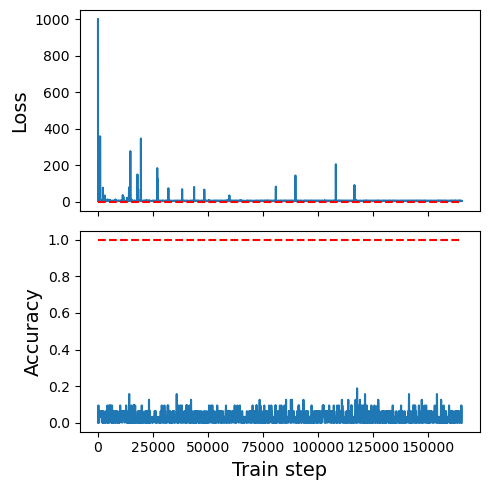

In [29]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [38]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu')
    

# Plotting results

In [39]:
from survey_ops.utils.geometry import angular_separation


## First, visualize healpix's gridding and actual ra, dec of observed fields

In [40]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [41]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

/tmp/ipykernel_20323/415551787.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)


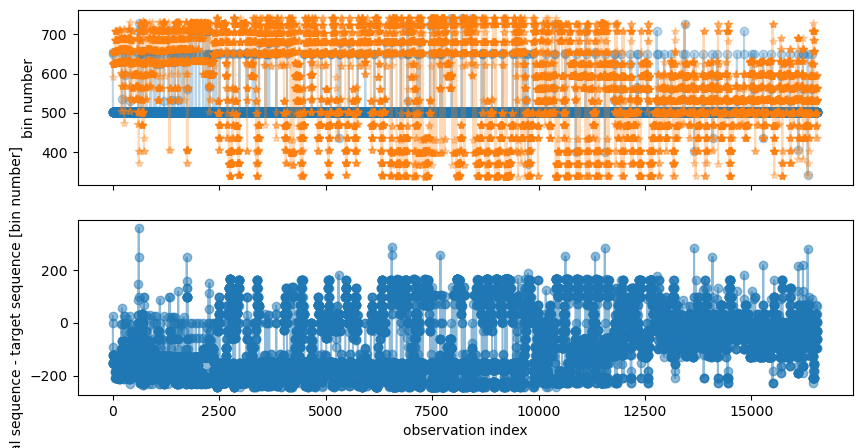

In [42]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(eval_sequence, marker='o', alpha=.3)
axs[0].plot(target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [43]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2015],
    specific_months=[12],
    include_default_features=True,
    include_bin_features=False,
    do_z_score_norm=False,
    do_cyclical_norm=False,
)

In [44]:
with torch.no_grad():
    test_q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    test_eval_actions = torch.argmax(test_q_vals, dim=1).to('cpu')

test_target_sequence = test_dataset.actions.detach().numpy()
test_eval_sequence = test_eval_actions.detach().numpy()

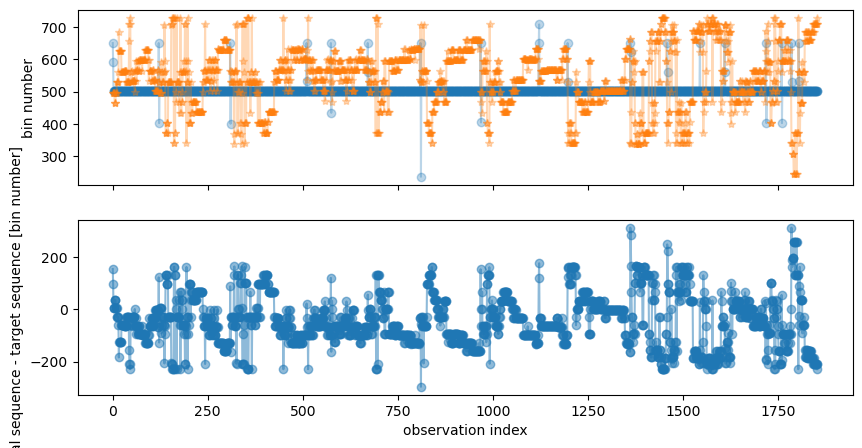

In [46]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(test_eval_sequence, marker='o', alpha=.3)
axs[0].plot(test_target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(test_eval_sequence - test_target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'test_eval_and_target_bin_sequences.png')

In [47]:
import random

In [48]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_target_sequence])

In [1]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], s=50, alpha=.8)
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], alpha=.8, s=50, marker='*')
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();


NameError: name 'plt' is not defined